Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import nltk
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, Add, Activation, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Attention

In [6]:
images_dir = '/Users/shalu/Downloads/Image_Captioning/Dataset/Images/'


In [7]:
def load_captions(captions_file):
    with open(captions_file, 'r') as f:
        captions_doc = f.read().strip().split('\n')

    captions = {}
    skipped_lines = 0  # Counter for skipped lines
    logged_skips = 0  # Counter for how many misformatted lines we log
    max_skips_to_log = 10  # Limit how many misformatted lines we print

    # Skip the first line (header)
    for line in captions_doc[1:]:  # Start from the second line
        parts = line.split(',', 1)  # Split by comma, but only split once
        
        # Check if the line has at least two parts: image ID and caption
        if len(parts) < 2:
            skipped_lines += 1
            if logged_skips < max_skips_to_log:
                print(f"Skipping misformatted line: {line}")
                logged_skips += 1
            continue
        
        image_id, caption = parts

        # Add the caption to the list of captions for that image ID
        image_id = image_id.strip()  # Remove leading/trailing whitespace from image ID
        caption = caption.strip()  # Remove leading/trailing whitespace from caption

        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(caption)

    if skipped_lines > max_skips_to_log:
        print(f"Total skipped lines: {skipped_lines} (Logged first {max_skips_to_log} skipped lines)")

    return captions
# Example usage
captions_file = '/Users/shalu/Downloads/Image_Captioning/Dataset/captions.txt'
captions = load_captions(captions_file)



In [8]:
def preprocess_image(image_path):
    img = Image.open(image_path).resize((299, 299))
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[..., :3]
    img = preprocess_input(img)
    return img

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tqdm import tqdm

model_inception = InceptionV3(weights='imagenet')
model_inception = Model(model_inception.input, model_inception.layers[-2].output)

def encode_image(image):
    image = preprocess_image(image)
    image = np.expand_dims(image, axis=0)
    feature = model_inception.predict(image)
    feature = np.reshape(feature, feature.shape[1])
    return feature

# Encode all images and store features in a dictionary
encoding_train = {}
for img_id in tqdm(captions.keys()):
    img_path = images_dir + img_id
    encoding_train[img_id] = encode_image(img_path)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


  0%|                                                  | 0/8091 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step


  0%|                                        | 1/8091 [00:00<1:20:00,  1.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|                                          | 3/8091 [00:00<26:44,  5.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|                                          | 5/8091 [00:00<17:19,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|                                          | 7/8091 [00:00<13:43,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|                                          | 9/8091 [00:01<11:49, 11.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|                                         | 11/8091 [00:01<10:34, 12.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|                                         | 13/8091 [00:01<09:44, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|                                         | 15/8091 [00:01<09:12, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|                                         | 17/8091 [00:01<08:51, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|                                         | 19/8091 [00:01<08:36, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  0%|                                         | 21/8091 [00:01<08:21, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|                                         | 23/8091 [00:01<08:09, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|▏                                        | 25/8091 [00:02<08:14, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  0%|▏                                        | 27/8091 [00:02<08:09, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|▏                                        | 29/8091 [00:02<08:03, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|▏                                        | 31/8091 [00:02<08:00, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|▏                                        | 33/8091 [00:02<08:03, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  0%|▏                                        | 35/8091 [00:02<08:04, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  0%|▏                                        | 37/8091 [00:02<08:03, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|▏                                        | 39/8091 [00:02<08:04, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▏                                        | 41/8091 [00:03<08:02, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▏                                        | 43/8091 [00:03<07:59, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▏                                        | 45/8091 [00:03<07:59, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▏                                        | 47/8091 [00:03<07:53, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▏                                        | 49/8091 [00:03<07:52, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▎                                        | 51/8091 [00:03<07:52, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▎                                        | 53/8091 [00:03<07:49, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▎                                        | 55/8091 [00:03<07:50, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▎                                        | 57/8091 [00:03<07:53, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▎                                        | 59/8091 [00:04<07:48, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▎                                        | 61/8091 [00:04<07:48, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|▎                                        | 63/8091 [00:04<07:48, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▎                                        | 65/8091 [00:04<08:23, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


  1%|▎                                        | 67/8091 [00:04<10:20, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|▎                                        | 69/8091 [00:04<09:36, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  1%|▎                                        | 71/8091 [00:04<09:20, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▎                                        | 73/8091 [00:05<08:58, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|▍                                        | 75/8091 [00:05<08:42, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▍                                        | 77/8091 [00:05<08:28, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▍                                        | 79/8091 [00:05<08:15, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▍                                        | 81/8091 [00:05<08:04, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|▍                                        | 83/8091 [00:05<08:08, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▍                                        | 85/8091 [00:05<08:06, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▍                                        | 87/8091 [00:05<07:55, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▍                                        | 89/8091 [00:05<07:52, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▍                                        | 91/8091 [00:06<07:49, 17.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▍                                        | 93/8091 [00:06<07:44, 17.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▍                                        | 95/8091 [00:06<07:43, 17.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▍                                        | 97/8091 [00:06<07:47, 17.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                        | 99/8091 [00:06<07:46, 17.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▍                                       | 101/8091 [00:06<07:50, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  1%|▌                                       | 103/8091 [00:06<07:47, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                       | 105/8091 [00:06<07:42, 17.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▌                                       | 107/8091 [00:07<07:44, 17.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▌                                       | 109/8091 [00:07<07:42, 17.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                       | 111/8091 [00:07<07:44, 17.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  1%|▌                                       | 113/8091 [00:07<08:00, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                       | 115/8091 [00:07<07:52, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                       | 117/8091 [00:07<07:49, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                       | 119/8091 [00:07<07:47, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|▌                                       | 121/8091 [00:07<07:45, 17.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▌                                       | 123/8091 [00:07<07:42, 17.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▌                                       | 125/8091 [00:08<07:38, 17.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▋                                       | 127/8091 [00:08<07:40, 17.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▋                                       | 129/8091 [00:08<07:35, 17.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▋                                       | 131/8091 [00:08<07:37, 17.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▋                                       | 133/8091 [00:08<07:43, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▋                                       | 135/8091 [00:08<07:40, 17.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▋                                       | 137/8091 [00:08<07:47, 17.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▋                                       | 139/8091 [00:08<07:50, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▋                                       | 141/8091 [00:09<07:48, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▋                                       | 143/8091 [00:09<07:48, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▋                                       | 145/8091 [00:09<07:51, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▋                                       | 147/8091 [00:09<07:47, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▋                                       | 149/8091 [00:09<07:47, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▋                                       | 151/8091 [00:09<07:51, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▊                                       | 153/8091 [00:09<07:50, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▊                                       | 155/8091 [00:09<07:51, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▊                                       | 157/8091 [00:09<07:55, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▊                                       | 159/8091 [00:10<07:53, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▊                                       | 161/8091 [00:10<07:51, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  2%|▊                                       | 163/8091 [00:10<07:56, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▊                                       | 165/8091 [00:10<07:55, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▊                                       | 167/8091 [00:10<07:50, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▊                                       | 169/8091 [00:10<07:53, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▊                                       | 171/8091 [00:10<07:53, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▊                                       | 173/8091 [00:10<07:51, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▊                                       | 175/8091 [00:11<07:55, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▉                                       | 177/8091 [00:11<08:13, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▉                                       | 179/8091 [00:11<08:11, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▉                                       | 181/8091 [00:11<08:01, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▉                                       | 183/8091 [00:11<08:00, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▉                                       | 185/8091 [00:11<07:58, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  2%|▉                                       | 187/8091 [00:11<07:52, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▉                                       | 189/8091 [00:11<07:53, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▉                                       | 191/8091 [00:12<07:52, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▉                                       | 193/8091 [00:12<07:58, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▉                                       | 195/8091 [00:12<08:02, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▉                                       | 197/8091 [00:12<07:56, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▉                                       | 199/8091 [00:12<07:52, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▉                                       | 201/8091 [00:12<07:48, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█                                       | 203/8091 [00:12<07:48, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█                                       | 205/8091 [00:12<07:50, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|█                                       | 207/8091 [00:12<07:47, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█                                       | 209/8091 [00:13<07:48, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█                                       | 211/8091 [00:13<07:45, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█                                       | 213/8091 [00:13<07:40, 17.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█                                       | 215/8091 [00:13<07:38, 17.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  3%|█                                       | 217/8091 [00:13<07:48, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  3%|█                                       | 219/8091 [00:13<08:00, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|█                                       | 221/8091 [00:13<08:06, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█                                       | 223/8091 [00:13<08:01, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█                                       | 225/8091 [00:14<07:55, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█                                       | 227/8091 [00:14<07:52, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|█▏                                      | 229/8091 [00:14<07:52, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▏                                      | 231/8091 [00:14<07:51, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█▏                                      | 233/8091 [00:14<07:50, 16.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|█▏                                      | 235/8091 [00:14<07:42, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▏                                      | 237/8091 [00:14<07:40, 17.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▏                                      | 239/8091 [00:14<07:39, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█▏                                      | 241/8091 [00:14<07:38, 17.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▏                                      | 243/8091 [00:15<07:39, 17.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▏                                      | 245/8091 [00:15<07:40, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  3%|█▏                                      | 247/8091 [00:15<08:44, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|█▏                                      | 249/8091 [00:15<08:27, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|█▏                                      | 251/8091 [00:15<08:13, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▎                                      | 253/8091 [00:15<08:06, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▎                                      | 255/8091 [00:15<07:57, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|█▎                                      | 257/8091 [00:15<07:46, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█▎                                      | 259/8091 [00:16<07:44, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  3%|█▎                                      | 261/8091 [00:16<07:41, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▎                                      | 263/8091 [00:16<07:39, 17.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█▎                                      | 265/8091 [00:16<07:40, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▎                                      | 267/8091 [00:16<07:41, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▎                                      | 269/8091 [00:16<07:40, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▎                                      | 271/8091 [00:16<07:40, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|█▎                                      | 273/8091 [00:16<07:40, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|█▎                                      | 275/8091 [00:17<07:38, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█▎                                      | 277/8091 [00:17<07:38, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|█▍                                      | 279/8091 [00:17<07:42, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|█▍                                      | 281/8091 [00:17<07:40, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|█▍                                      | 283/8091 [00:17<07:41, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▍                                      | 285/8091 [00:17<07:44, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  4%|█▍                                      | 287/8091 [00:17<07:54, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|█▍                                      | 289/8091 [00:17<07:53, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▍                                      | 291/8091 [00:18<07:47, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▍                                      | 293/8091 [00:18<07:48, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|█▍                                      | 295/8091 [00:18<07:44, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▍                                      | 297/8091 [00:18<07:43, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▍                                      | 299/8091 [00:18<07:42, 16.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▍                                      | 301/8091 [00:18<08:19, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|█▍                                      | 303/8091 [00:18<08:10, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▌                                      | 305/8091 [00:18<08:01, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▌                                      | 307/8091 [00:18<07:56, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▌                                      | 309/8091 [00:19<07:53, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▌                                      | 311/8091 [00:19<07:50, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|█▌                                      | 313/8091 [00:19<07:45, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|█▌                                      | 315/8091 [00:19<07:47, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|█▌                                      | 317/8091 [00:19<07:42, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▌                                      | 319/8091 [00:19<07:42, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|█▌                                      | 321/8091 [00:19<07:41, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  4%|█▌                                      | 323/8091 [00:19<07:43, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▌                                      | 325/8091 [00:20<07:45, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▌                                      | 327/8091 [00:20<07:47, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▋                                      | 329/8091 [00:20<08:19, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▋                                      | 331/8091 [00:20<08:07, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|█▋                                      | 333/8091 [00:20<08:03, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▋                                      | 335/8091 [00:20<07:56, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▋                                      | 337/8091 [00:20<07:51, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▋                                      | 339/8091 [00:20<07:48, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▋                                      | 341/8091 [00:21<07:44, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▋                                      | 343/8091 [00:21<07:42, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▋                                      | 345/8091 [00:21<07:41, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▋                                      | 347/8091 [00:21<07:42, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▋                                      | 349/8091 [00:21<07:44, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▋                                      | 351/8091 [00:21<07:48, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▋                                      | 353/8091 [00:21<07:47, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▊                                      | 355/8091 [00:21<07:49, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|█▊                                      | 357/8091 [00:22<07:49, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▊                                      | 359/8091 [00:22<07:46, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|█▊                                      | 361/8091 [00:22<07:49, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|█▊                                      | 363/8091 [00:22<07:46, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|█▊                                      | 365/8091 [00:22<07:44, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|█▊                                      | 367/8091 [00:22<07:42, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|█▊                                      | 369/8091 [00:22<07:45, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|█▊                                      | 371/8091 [00:22<07:43, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|█▊                                      | 373/8091 [00:22<07:42, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|█▊                                      | 375/8091 [00:23<07:41, 16.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  5%|█▊                                      | 377/8091 [00:23<07:40, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|█▊                                      | 379/8091 [00:23<07:37, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|█▉                                      | 381/8091 [00:23<07:34, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|█▉                                      | 383/8091 [00:23<07:35, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|█▉                                      | 385/8091 [00:23<07:33, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|█▉                                      | 387/8091 [00:23<07:29, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|█▉                                      | 389/8091 [00:23<07:26, 17.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|█▉                                      | 391/8091 [00:24<07:24, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|█▉                                      | 393/8091 [00:24<07:23, 17.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|█▉                                      | 395/8091 [00:24<07:18, 17.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|█▉                                      | 397/8091 [00:24<07:18, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  5%|█▉                                      | 399/8091 [00:24<07:15, 17.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|█▉                                      | 401/8091 [00:24<07:22, 17.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|█▉                                      | 403/8091 [00:24<07:24, 17.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██                                      | 405/8091 [00:24<07:24, 17.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|██                                      | 407/8091 [00:24<07:22, 17.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██                                      | 409/8091 [00:25<07:24, 17.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|██                                      | 411/8091 [00:25<07:19, 17.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|██                                      | 413/8091 [00:25<07:17, 17.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|██                                      | 415/8091 [00:25<07:19, 17.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|██                                      | 417/8091 [00:25<07:22, 17.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|██                                      | 419/8091 [00:25<07:24, 17.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|██                                      | 421/8091 [00:25<07:24, 17.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██                                      | 423/8091 [00:25<07:22, 17.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██                                      | 425/8091 [00:25<07:22, 17.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██                                      | 427/8091 [00:26<07:21, 17.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██                                      | 429/8091 [00:26<07:23, 17.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|██▏                                     | 431/8091 [00:26<07:21, 17.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|██▏                                     | 433/8091 [00:26<07:25, 17.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|██▏                                     | 435/8091 [00:26<07:27, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██▏                                     | 437/8091 [00:26<07:26, 17.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██▏                                     | 439/8091 [00:26<07:27, 17.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|██▏                                     | 441/8091 [00:26<07:28, 17.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██▏                                     | 443/8091 [00:27<07:26, 17.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|██▏                                     | 445/8091 [00:27<07:29, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▏                                     | 447/8091 [00:27<07:26, 17.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▏                                     | 449/8091 [00:27<07:27, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|██▏                                     | 451/8091 [00:27<07:29, 16.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▏                                     | 453/8091 [00:27<07:26, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▏                                     | 455/8091 [00:27<07:25, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▎                                     | 457/8091 [00:27<07:25, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▎                                     | 459/8091 [00:27<07:26, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▎                                     | 461/8091 [00:28<07:27, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▎                                     | 463/8091 [00:28<07:27, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▎                                     | 465/8091 [00:28<07:28, 17.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▎                                     | 467/8091 [00:28<07:28, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▎                                     | 469/8091 [00:28<07:27, 17.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|██▎                                     | 471/8091 [00:28<07:32, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▎                                     | 473/8091 [00:28<07:29, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|██▎                                     | 475/8091 [00:28<07:30, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▎                                     | 477/8091 [00:29<07:28, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▎                                     | 479/8091 [00:29<07:25, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|██▍                                     | 481/8091 [00:29<07:26, 17.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▍                                     | 483/8091 [00:29<07:22, 17.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|██▍                                     | 485/8091 [00:29<07:28, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▍                                     | 487/8091 [00:29<07:26, 17.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|██▍                                     | 489/8091 [00:29<07:29, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▍                                     | 491/8091 [00:29<07:32, 16.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▍                                     | 493/8091 [00:29<07:32, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  6%|██▍                                     | 495/8091 [00:30<07:37, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▍                                     | 497/8091 [00:30<07:38, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


  6%|██▍                                     | 499/8091 [00:30<08:14, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|██▍                                     | 501/8091 [00:30<08:22, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  6%|██▍                                     | 503/8091 [00:30<08:11, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▍                                     | 505/8091 [00:30<08:03, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▌                                     | 507/8091 [00:30<07:52, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▌                                     | 509/8091 [00:30<07:40, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|██▌                                     | 511/8091 [00:31<07:35, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▌                                     | 513/8091 [00:31<07:31, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▌                                     | 515/8091 [00:31<07:26, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|██▌                                     | 517/8091 [00:31<07:30, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  6%|██▌                                     | 519/8091 [00:31<07:34, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▌                                     | 521/8091 [00:31<07:40, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▌                                     | 523/8091 [00:31<07:41, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|██▌                                     | 525/8091 [00:31<07:40, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|██▌                                     | 527/8091 [00:32<07:35, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|██▌                                     | 529/8091 [00:32<07:34, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▋                                     | 531/8091 [00:32<07:40, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|██▋                                     | 533/8091 [00:32<07:35, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|██▋                                     | 535/8091 [00:32<07:32, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|██▋                                     | 537/8091 [00:32<07:34, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▋                                     | 539/8091 [00:32<07:33, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▋                                     | 541/8091 [00:32<07:48, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▋                                     | 543/8091 [00:33<07:54, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|██▋                                     | 545/8091 [00:33<08:03, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|██▋                                     | 547/8091 [00:33<08:14, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▋                                     | 549/8091 [00:33<08:16, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▋                                     | 551/8091 [00:33<08:10, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  7%|██▋                                     | 553/8091 [00:33<08:22, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|██▋                                     | 555/8091 [00:33<08:21, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|██▊                                     | 557/8091 [00:33<08:18, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|██▊                                     | 559/8091 [00:34<08:17, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▊                                     | 561/8091 [00:34<08:32, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|██▊                                     | 563/8091 [00:34<08:24, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|██▊                                     | 565/8091 [00:34<08:29, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▊                                     | 567/8091 [00:34<08:26, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▊                                     | 569/8091 [00:34<08:16, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▊                                     | 571/8091 [00:34<08:18, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|██▊                                     | 573/8091 [00:35<08:11, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  7%|██▊                                     | 575/8091 [00:35<08:14, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▊                                     | 577/8091 [00:35<08:13, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|██▊                                     | 579/8091 [00:35<08:07, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  7%|██▊                                     | 581/8091 [00:35<08:19, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|██▉                                     | 583/8091 [00:35<08:13, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▉                                     | 585/8091 [00:35<08:08, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|██▉                                     | 587/8091 [00:35<08:04, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|██▉                                     | 589/8091 [00:36<08:06, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▉                                     | 591/8091 [00:36<08:04, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|██▉                                     | 593/8091 [00:36<07:58, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|██▉                                     | 595/8091 [00:36<07:57, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▉                                     | 597/8091 [00:36<07:59, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|██▉                                     | 599/8091 [00:36<08:01, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  7%|██▉                                     | 601/8091 [00:36<08:04, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  7%|██▉                                     | 603/8091 [00:36<07:59, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|██▉                                     | 605/8091 [00:37<07:58, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|███                                     | 607/8091 [00:37<08:05, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|███                                     | 609/8091 [00:37<08:13, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███                                     | 611/8091 [00:37<08:27, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  8%|███                                     | 613/8091 [00:37<08:26, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|███                                     | 615/8091 [00:37<08:26, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███                                     | 617/8091 [00:37<08:32, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|███                                     | 619/8091 [00:38<08:24, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|███                                     | 621/8091 [00:38<08:16, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|███                                     | 623/8091 [00:38<08:15, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|███                                     | 625/8091 [00:38<08:09, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|███                                     | 627/8091 [00:38<08:01, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|███                                     | 629/8091 [00:38<08:04, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███                                     | 631/8091 [00:38<08:05, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


  8%|███▏                                    | 633/8091 [00:38<08:19, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|███▏                                    | 635/8091 [00:39<08:14, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|███▏                                    | 637/8091 [00:39<08:13, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|███▏                                    | 639/8091 [00:39<08:05, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|███▏                                    | 641/8091 [00:39<08:01, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███▏                                    | 643/8091 [00:39<07:58, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|███▏                                    | 645/8091 [00:39<07:54, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|███▏                                    | 647/8091 [00:39<07:52, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|███▏                                    | 649/8091 [00:40<07:55, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|███▏                                    | 651/8091 [00:40<08:05, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|███▏                                    | 653/8091 [00:40<08:00, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███▏                                    | 655/8091 [00:40<07:58, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|███▏                                    | 657/8091 [00:40<08:03, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|███▎                                    | 659/8091 [00:40<07:59, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  8%|███▎                                    | 661/8091 [00:40<08:16, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  8%|███▎                                    | 663/8091 [00:40<08:12, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|███▎                                    | 665/8091 [00:41<08:13, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|███▎                                    | 667/8091 [00:41<08:16, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  8%|███▎                                    | 669/8091 [00:41<08:16, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███▎                                    | 671/8091 [00:41<08:13, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  8%|███▎                                    | 673/8091 [00:41<08:17, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|███▎                                    | 675/8091 [00:41<08:18, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|███▎                                    | 677/8091 [00:41<08:16, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|███▎                                    | 679/8091 [00:41<08:06, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|███▎                                    | 681/8091 [00:42<08:11, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  8%|███▍                                    | 683/8091 [00:42<08:24, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  8%|███▍                                    | 685/8091 [00:42<08:32, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  8%|███▍                                    | 687/8091 [00:42<08:25, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  9%|███▍                                    | 689/8091 [00:42<08:20, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▍                                    | 691/8091 [00:42<08:14, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▍                                    | 693/8091 [00:42<08:11, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▍                                    | 695/8091 [00:43<08:04, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|███▍                                    | 697/8091 [00:43<08:08, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|███▍                                    | 699/8091 [00:43<08:14, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|███▍                                    | 701/8091 [00:43<08:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▍                                    | 703/8091 [00:43<08:04, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


  9%|███▍                                    | 705/8091 [00:43<08:18, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  9%|███▍                                    | 707/8091 [00:43<08:21, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  9%|███▌                                    | 709/8091 [00:44<08:25, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|███▌                                    | 711/8091 [00:44<08:17, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|███▌                                    | 713/8091 [00:44<08:13, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|███▌                                    | 715/8091 [00:44<08:11, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|███▌                                    | 717/8091 [00:44<08:08, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  9%|███▌                                    | 719/8091 [00:44<08:25, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  9%|███▌                                    | 721/8091 [00:44<08:37, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  9%|███▌                                    | 723/8091 [00:45<09:08, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


  9%|███▌                                    | 725/8091 [00:45<09:56, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


  9%|███▌                                    | 727/8091 [00:45<09:41, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|███▌                                    | 729/8091 [00:45<09:14, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|███▌                                    | 731/8091 [00:45<08:54, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|███▌                                    | 733/8091 [00:45<08:45, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


  9%|███▋                                    | 735/8091 [00:45<08:48, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  9%|███▋                                    | 737/8091 [00:46<08:34, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  9%|███▋                                    | 739/8091 [00:46<08:28, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▋                                    | 741/8091 [00:46<08:16, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|███▋                                    | 743/8091 [00:46<08:08, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|███▋                                    | 745/8091 [00:46<07:59, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|███▋                                    | 747/8091 [00:46<07:56, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▋                                    | 749/8091 [00:46<07:51, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|███▋                                    | 751/8091 [00:46<07:41, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  9%|███▋                                    | 753/8091 [00:47<07:38, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|███▋                                    | 755/8091 [00:47<07:34, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


  9%|███▋                                    | 757/8091 [00:47<07:44, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


  9%|███▊                                    | 759/8091 [00:47<08:08, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|███▊                                    | 761/8091 [00:47<08:11, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|███▊                                    | 763/8091 [00:47<08:11, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  9%|███▊                                    | 765/8091 [00:47<08:12, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  9%|███▊                                    | 767/8091 [00:47<08:20, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|███▊                                    | 769/8091 [00:48<08:23, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|███▊                                    | 771/8091 [00:48<08:13, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|███▊                                    | 773/8091 [00:48<08:12, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 10%|███▊                                    | 775/8091 [00:48<08:11, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|███▊                                    | 777/8091 [00:48<08:00, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|███▊                                    | 779/8091 [00:48<07:50, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|███▊                                    | 781/8091 [00:48<07:39, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|███▊                                    | 783/8091 [00:49<07:29, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|███▉                                    | 785/8091 [00:49<07:23, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|███▉                                    | 787/8091 [00:49<07:18, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 10%|███▉                                    | 789/8091 [00:49<07:30, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|███▉                                    | 791/8091 [00:49<07:38, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|███▉                                    | 793/8091 [00:49<07:45, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|███▉                                    | 795/8091 [00:49<07:46, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|███▉                                    | 797/8091 [00:49<07:52, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|███▉                                    | 799/8091 [00:50<07:53, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|███▉                                    | 801/8091 [00:50<07:50, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|███▉                                    | 803/8091 [00:50<07:41, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|███▉                                    | 805/8091 [00:50<07:38, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 10%|███▉                                    | 807/8091 [00:50<07:55, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 10%|███▉                                    | 809/8091 [00:50<07:58, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|████                                    | 811/8091 [00:50<07:55, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|████                                    | 813/8091 [00:50<07:57, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|████                                    | 815/8091 [00:51<07:53, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████                                    | 817/8091 [00:51<07:47, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████                                    | 819/8091 [00:51<07:40, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|████                                    | 821/8091 [00:51<07:34, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|████                                    | 823/8091 [00:51<07:28, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 10%|████                                    | 825/8091 [00:51<07:29, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 10%|████                                    | 827/8091 [00:51<07:58, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|████                                    | 829/8091 [00:51<08:25, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|████                                    | 831/8091 [00:52<08:13, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|████                                    | 833/8091 [00:52<08:04, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 10%|████▏                                   | 835/8091 [00:52<08:09, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 10%|████▏                                   | 837/8091 [00:52<07:51, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████▏                                   | 839/8091 [00:52<07:43, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████▏                                   | 841/8091 [00:52<07:41, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████▏                                   | 843/8091 [00:52<07:41, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 10%|████▏                                   | 845/8091 [00:53<07:46, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████▏                                   | 847/8091 [00:53<07:46, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|████▏                                   | 849/8091 [00:53<07:44, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▏                                   | 851/8091 [00:53<07:45, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▏                                   | 853/8091 [00:53<08:02, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▏                                   | 855/8091 [00:53<08:00, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|████▏                                   | 857/8091 [00:53<07:54, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|████▏                                   | 859/8091 [00:53<07:51, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████▎                                   | 861/8091 [00:54<07:45, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████▎                                   | 863/8091 [00:54<07:40, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|████▎                                   | 865/8091 [00:54<07:51, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|████▎                                   | 867/8091 [00:54<07:59, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 11%|████▎                                   | 869/8091 [00:54<08:33, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 11%|████▎                                   | 871/8091 [00:54<08:27, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▎                                   | 873/8091 [00:54<08:19, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████▎                                   | 875/8091 [00:55<08:06, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▎                                   | 877/8091 [00:55<08:04, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 11%|████▎                                   | 879/8091 [00:55<08:02, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▎                                   | 881/8091 [00:55<08:05, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|████▎                                   | 883/8091 [00:55<08:13, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 11%|████▍                                   | 885/8091 [00:55<08:07, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▍                                   | 887/8091 [00:55<08:01, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|████▍                                   | 889/8091 [00:55<08:01, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|████▍                                   | 891/8091 [00:56<07:51, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████▍                                   | 893/8091 [00:56<07:47, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|████▍                                   | 895/8091 [00:56<07:42, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|████▍                                   | 897/8091 [00:56<07:34, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 11%|████▍                                   | 899/8091 [00:56<07:44, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|████▍                                   | 901/8091 [00:56<07:33, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|████▍                                   | 903/8091 [00:56<07:25, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|████▍                                   | 905/8091 [00:56<07:19, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 11%|████▍                                   | 907/8091 [00:57<07:13, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|████▍                                   | 909/8091 [00:57<07:16, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|████▌                                   | 911/8091 [00:57<07:21, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|████▌                                   | 913/8091 [00:57<07:33, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 11%|████▌                                   | 915/8091 [00:57<07:36, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 11%|████▌                                   | 917/8091 [00:57<07:40, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|████▌                                   | 919/8091 [00:57<07:46, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 11%|████▌                                   | 921/8091 [00:57<07:46, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████▌                                   | 923/8091 [00:58<08:02, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|████▌                                   | 925/8091 [00:58<07:52, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 11%|████▌                                   | 927/8091 [00:58<07:39, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 11%|████▌                                   | 929/8091 [00:58<07:30, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|████▌                                   | 931/8091 [00:58<07:37, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|████▌                                   | 933/8091 [00:58<07:38, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|████▌                                   | 935/8091 [00:58<07:36, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|████▋                                   | 937/8091 [00:59<07:41, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|████▋                                   | 939/8091 [00:59<07:59, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|████▋                                   | 941/8091 [00:59<07:56, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|████▋                                   | 943/8091 [00:59<07:59, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|████▋                                   | 945/8091 [00:59<07:56, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|████▋                                   | 947/8091 [00:59<07:58, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|████▋                                   | 949/8091 [00:59<07:52, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|████▋                                   | 951/8091 [00:59<08:05, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 12%|████▋                                   | 953/8091 [01:00<08:06, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 12%|████▋                                   | 955/8091 [01:00<08:04, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|████▋                                   | 957/8091 [01:00<07:55, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|████▋                                   | 959/8091 [01:00<07:54, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 12%|████▊                                   | 961/8091 [01:00<07:57, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|████▊                                   | 963/8091 [01:00<07:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|████▊                                   | 965/8091 [01:00<08:07, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 12%|████▊                                   | 967/8091 [01:01<08:06, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                   | 969/8091 [01:01<07:52, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|████▊                                   | 971/8091 [01:01<07:37, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                   | 973/8091 [01:01<07:32, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|████▊                                   | 975/8091 [01:01<07:23, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|████▊                                   | 977/8091 [01:01<07:15, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                   | 979/8091 [01:01<07:20, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                   | 981/8091 [01:01<07:17, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|████▊                                   | 983/8091 [01:02<07:27, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                   | 985/8091 [01:02<07:27, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|████▉                                   | 987/8091 [01:02<07:23, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 12%|████▉                                   | 989/8091 [01:02<07:22, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▉                                   | 991/8091 [01:02<07:13, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|████▉                                   | 993/8091 [01:02<07:05, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|████▉                                   | 995/8091 [01:02<07:04, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|████▉                                   | 997/8091 [01:02<07:02, 16.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|████▉                                   | 999/8091 [01:02<07:02, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                  | 1001/8091 [01:03<07:04, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                  | 1003/8091 [01:03<07:03, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                  | 1005/8091 [01:03<07:15, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|████▊                                  | 1007/8091 [01:03<07:10, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|████▊                                  | 1009/8091 [01:03<07:11, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|████▊                                  | 1011/8091 [01:03<07:06, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|████▉                                  | 1013/8091 [01:03<07:04, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|████▉                                  | 1015/8091 [01:03<07:01, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|████▉                                  | 1017/8091 [01:04<06:59, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|████▉                                  | 1019/8091 [01:04<07:03, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|████▉                                  | 1021/8091 [01:04<07:09, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|████▉                                  | 1023/8091 [01:04<07:08, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|████▉                                  | 1025/8091 [01:04<07:08, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|████▉                                  | 1027/8091 [01:04<07:16, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|████▉                                  | 1029/8091 [01:04<07:09, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|████▉                                  | 1031/8091 [01:04<07:07, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|████▉                                  | 1033/8091 [01:05<07:08, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|████▉                                  | 1035/8091 [01:05<07:11, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|████▉                                  | 1037/8091 [01:05<07:12, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████                                  | 1039/8091 [01:05<07:10, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████                                  | 1041/8091 [01:05<07:07, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████                                  | 1043/8091 [01:05<07:06, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█████                                  | 1045/8091 [01:05<07:10, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█████                                  | 1047/8091 [01:05<07:08, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████                                  | 1049/8091 [01:06<07:05, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████                                  | 1051/8091 [01:06<07:02, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█████                                  | 1053/8091 [01:06<06:59, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████                                  | 1055/8091 [01:06<07:00, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████                                  | 1057/8091 [01:06<07:03, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█████                                  | 1059/8091 [01:06<07:04, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 13%|█████                                  | 1061/8091 [01:06<07:06, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████                                  | 1063/8091 [01:06<07:04, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████▏                                 | 1065/8091 [01:06<07:02, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 13%|█████▏                                 | 1067/8091 [01:07<06:58, 16.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█████▏                                 | 1069/8091 [01:07<07:03, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████▏                                 | 1071/8091 [01:07<07:06, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████▏                                 | 1073/8091 [01:07<07:01, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████▏                                 | 1075/8091 [01:07<07:04, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████▏                                 | 1077/8091 [01:07<07:07, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█████▏                                 | 1079/8091 [01:07<07:05, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████▏                                 | 1081/8091 [01:07<07:06, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█████▏                                 | 1083/8091 [01:08<07:16, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█████▏                                 | 1085/8091 [01:08<07:15, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█████▏                                 | 1087/8091 [01:08<07:16, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████▏                                 | 1089/8091 [01:08<07:12, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█████▎                                 | 1091/8091 [01:08<07:10, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▎                                 | 1093/8091 [01:08<07:10, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█████▎                                 | 1095/8091 [01:08<07:09, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 14%|█████▎                                 | 1097/8091 [01:08<07:12, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█████▎                                 | 1099/8091 [01:09<07:09, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▎                                 | 1101/8091 [01:09<07:05, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▎                                 | 1103/8091 [01:09<07:04, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▎                                 | 1105/8091 [01:09<07:07, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█████▎                                 | 1107/8091 [01:09<07:20, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█████▎                                 | 1109/8091 [01:09<07:20, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▎                                 | 1111/8091 [01:09<07:18, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▎                                 | 1113/8091 [01:09<07:14, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▎                                 | 1115/8091 [01:10<07:07, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▍                                 | 1117/8091 [01:10<07:22, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█████▍                                 | 1119/8091 [01:10<07:19, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▍                                 | 1121/8091 [01:10<07:18, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█████▍                                 | 1123/8091 [01:10<07:15, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▍                                 | 1125/8091 [01:10<07:11, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█████▍                                 | 1127/8091 [01:10<07:13, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▍                                 | 1129/8091 [01:10<07:14, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▍                                 | 1131/8091 [01:11<07:10, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█████▍                                 | 1133/8091 [01:11<07:11, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█████▍                                 | 1135/8091 [01:11<07:09, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▍                                 | 1137/8091 [01:11<07:08, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▍                                 | 1139/8091 [01:11<07:04, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▍                                 | 1141/8091 [01:11<07:04, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 14%|█████▌                                 | 1143/8091 [01:11<07:15, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▌                                 | 1145/8091 [01:11<07:13, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 14%|█████▌                                 | 1147/8091 [01:12<07:10, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█████▌                                 | 1149/8091 [01:12<07:09, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▌                                 | 1151/8091 [01:12<07:03, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▌                                 | 1153/8091 [01:12<07:03, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▌                                 | 1155/8091 [01:12<07:02, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▌                                 | 1157/8091 [01:12<07:05, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 14%|█████▌                                 | 1159/8091 [01:12<07:25, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 14%|█████▌                                 | 1161/8091 [01:12<07:21, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▌                                 | 1163/8091 [01:13<07:16, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█████▌                                 | 1165/8091 [01:13<09:28, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█████▋                                 | 1167/8091 [01:13<08:58, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█████▋                                 | 1169/8091 [01:13<08:23, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█████▋                                 | 1171/8091 [01:13<07:59, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█████▋                                 | 1173/8091 [01:13<07:41, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█████▋                                 | 1175/8091 [01:13<07:54, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 15%|█████▋                                 | 1177/8091 [01:14<08:43, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█████▋                                 | 1179/8091 [01:14<08:20, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█████▋                                 | 1181/8091 [01:14<07:54, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 15%|█████▋                                 | 1183/8091 [01:14<07:41, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█████▋                                 | 1185/8091 [01:14<07:34, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█████▋                                 | 1187/8091 [01:14<07:33, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█████▋                                 | 1189/8091 [01:14<07:19, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█████▋                                 | 1191/8091 [01:15<07:17, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█████▊                                 | 1193/8091 [01:15<07:23, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█████▊                                 | 1195/8091 [01:15<07:16, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█████▊                                 | 1197/8091 [01:15<07:13, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█████▊                                 | 1199/8091 [01:15<07:09, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█████▊                                 | 1201/8091 [01:15<07:12, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█████▊                                 | 1203/8091 [01:15<07:08, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█████▊                                 | 1205/8091 [01:15<07:06, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█████▊                                 | 1207/8091 [01:15<07:00, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█████▊                                 | 1209/8091 [01:16<07:00, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█████▊                                 | 1211/8091 [01:16<06:56, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█████▊                                 | 1213/8091 [01:16<06:55, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█████▊                                 | 1215/8091 [01:16<06:51, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█████▊                                 | 1217/8091 [01:16<06:50, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█████▉                                 | 1219/8091 [01:16<06:51, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█████▉                                 | 1221/8091 [01:16<06:47, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█████▉                                 | 1223/8091 [01:16<06:47, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█████▉                                 | 1225/8091 [01:17<06:48, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█████▉                                 | 1227/8091 [01:17<06:50, 16.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 15%|█████▉                                 | 1229/8091 [01:17<07:06, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█████▉                                 | 1231/8091 [01:17<07:10, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█████▉                                 | 1233/8091 [01:17<07:09, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█████▉                                 | 1235/8091 [01:17<07:03, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█████▉                                 | 1237/8091 [01:17<07:01, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|█████▉                                 | 1239/8091 [01:17<06:57, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|█████▉                                 | 1241/8091 [01:18<06:59, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█████▉                                 | 1243/8091 [01:18<07:06, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|██████                                 | 1245/8091 [01:18<07:03, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|██████                                 | 1247/8091 [01:18<06:59, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|██████                                 | 1249/8091 [01:18<07:06, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|██████                                 | 1251/8091 [01:18<07:09, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 15%|██████                                 | 1253/8091 [01:18<07:02, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|██████                                 | 1255/8091 [01:18<06:58, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████                                 | 1257/8091 [01:19<06:51, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████                                 | 1259/8091 [01:19<06:51, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|██████                                 | 1261/8091 [01:19<06:54, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|██████                                 | 1263/8091 [01:19<06:53, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|██████                                 | 1265/8091 [01:19<07:02, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|██████                                 | 1267/8091 [01:19<07:00, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|██████                                 | 1269/8091 [01:19<06:59, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 16%|██████▏                                | 1271/8091 [01:19<07:24, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|██████▏                                | 1273/8091 [01:20<07:19, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|██████▏                                | 1275/8091 [01:20<07:09, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▏                                | 1277/8091 [01:20<07:06, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▏                                | 1279/8091 [01:20<07:04, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▏                                | 1281/8091 [01:20<06:58, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|██████▏                                | 1283/8091 [01:20<07:05, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▏                                | 1285/8091 [01:20<07:06, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▏                                | 1287/8091 [01:20<06:56, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▏                                | 1289/8091 [01:21<06:48, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▏                                | 1291/8091 [01:21<06:45, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▏                                | 1293/8091 [01:21<06:41, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▏                                | 1295/8091 [01:21<06:40, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▎                                | 1297/8091 [01:21<06:40, 16.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▎                                | 1299/8091 [01:21<06:38, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▎                                | 1301/8091 [01:21<06:38, 17.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|██████▎                                | 1303/8091 [01:21<06:38, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▎                                | 1305/8091 [01:21<06:38, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▎                                | 1307/8091 [01:22<06:36, 17.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▎                                | 1309/8091 [01:22<06:35, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▎                                | 1311/8091 [01:22<06:37, 17.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|██████▎                                | 1313/8091 [01:22<06:36, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▎                                | 1315/8091 [01:22<06:38, 17.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▎                                | 1317/8091 [01:22<06:40, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 16%|██████▎                                | 1319/8091 [01:22<06:36, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▎                                | 1321/8091 [01:22<06:39, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|██████▍                                | 1323/8091 [01:23<06:37, 17.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|██████▍                                | 1325/8091 [01:23<06:39, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▍                                | 1327/8091 [01:23<06:38, 16.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|██████▍                                | 1329/8091 [01:23<06:39, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▍                                | 1331/8091 [01:23<06:39, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|██████▍                                | 1333/8091 [01:23<06:41, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|██████▍                                | 1335/8091 [01:23<06:42, 16.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|██████▍                                | 1337/8091 [01:23<06:43, 16.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▍                                | 1339/8091 [01:23<06:42, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▍                                | 1341/8091 [01:24<06:39, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▍                                | 1343/8091 [01:24<06:50, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▍                                | 1345/8091 [01:24<06:49, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▍                                | 1347/8091 [01:24<06:43, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▌                                | 1349/8091 [01:24<06:39, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▌                                | 1351/8091 [01:24<06:35, 17.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▌                                | 1353/8091 [01:24<06:36, 16.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|██████▌                                | 1355/8091 [01:24<06:38, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▌                                | 1357/8091 [01:25<06:38, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|██████▌                                | 1359/8091 [01:25<06:39, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▌                                | 1361/8091 [01:25<06:39, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▌                                | 1363/8091 [01:25<06:37, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▌                                | 1365/8091 [01:25<06:38, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▌                                | 1367/8091 [01:25<06:38, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▌                                | 1369/8091 [01:25<06:36, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▌                                | 1371/8091 [01:25<06:37, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▌                                | 1373/8091 [01:25<06:37, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▋                                | 1375/8091 [01:26<06:37, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▋                                | 1377/8091 [01:26<06:37, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▋                                | 1379/8091 [01:26<06:39, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▋                                | 1381/8091 [01:26<06:41, 16.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▋                                | 1383/8091 [01:26<06:38, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|██████▋                                | 1385/8091 [01:26<06:36, 16.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▋                                | 1387/8091 [01:26<06:36, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|██████▋                                | 1389/8091 [01:26<06:37, 16.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▋                                | 1391/8091 [01:27<06:37, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|██████▋                                | 1393/8091 [01:27<06:37, 16.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|██████▋                                | 1395/8091 [01:27<06:34, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|██████▋                                | 1397/8091 [01:27<06:31, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▋                                | 1399/8091 [01:27<06:30, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|██████▊                                | 1401/8091 [01:27<06:37, 16.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|██████▊                                | 1403/8091 [01:27<06:33, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▊                                | 1405/8091 [01:27<06:35, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▊                                | 1407/8091 [01:28<06:38, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|██████▊                                | 1409/8091 [01:28<06:38, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|██████▊                                | 1411/8091 [01:28<06:44, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 17%|██████▊                                | 1413/8091 [01:28<06:39, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 17%|██████▊                                | 1415/8091 [01:28<06:35, 16.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▊                                | 1417/8091 [01:28<06:34, 16.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▊                                | 1419/8091 [01:28<06:29, 17.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▊                                | 1421/8091 [01:28<06:29, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▊                                | 1423/8091 [01:28<06:26, 17.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|██████▊                                | 1425/8091 [01:29<06:30, 17.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|██████▉                                | 1427/8091 [01:29<06:35, 16.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▉                                | 1429/8091 [01:29<06:41, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|██████▉                                | 1431/8091 [01:29<06:37, 16.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▉                                | 1433/8091 [01:29<06:35, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|██████▉                                | 1435/8091 [01:29<06:30, 17.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|██████▉                                | 1437/8091 [01:29<06:33, 16.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|██████▉                                | 1439/8091 [01:29<06:31, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|██████▉                                | 1441/8091 [01:30<06:35, 16.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|██████▉                                | 1443/8091 [01:30<06:32, 16.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|██████▉                                | 1445/8091 [01:30<06:28, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▉                                | 1447/8091 [01:30<06:26, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 18%|██████▉                                | 1449/8091 [01:30<06:27, 17.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|██████▉                                | 1451/8091 [01:30<06:28, 17.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|███████                                | 1453/8091 [01:30<06:27, 17.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|███████                                | 1455/8091 [01:30<06:36, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|███████                                | 1457/8091 [01:30<06:35, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|███████                                | 1459/8091 [01:31<06:31, 16.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|███████                                | 1461/8091 [01:31<06:30, 16.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|███████                                | 1463/8091 [01:31<06:25, 17.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|███████                                | 1465/8091 [01:31<06:26, 17.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 18%|███████                                | 1467/8091 [01:31<06:36, 16.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|███████                                | 1469/8091 [01:31<06:41, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|███████                                | 1471/8091 [01:31<06:45, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|███████                                | 1473/8091 [01:31<06:42, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|███████                                | 1475/8091 [01:32<06:38, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|███████                                | 1477/8091 [01:32<06:42, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|███████▏                               | 1479/8091 [01:32<06:44, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|███████▏                               | 1481/8091 [01:32<06:39, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 18%|███████▏                               | 1483/8091 [01:32<06:47, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|███████▏                               | 1485/8091 [01:32<06:49, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|███████▏                               | 1487/8091 [01:32<06:45, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|███████▏                               | 1489/8091 [01:32<06:43, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|███████▏                               | 1491/8091 [01:33<06:38, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|███████▏                               | 1493/8091 [01:33<06:45, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|███████▏                               | 1495/8091 [01:33<06:55, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████▏                               | 1497/8091 [01:33<06:56, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|███████▏                               | 1499/8091 [01:33<06:58, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▏                               | 1501/8091 [01:33<06:58, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|███████▏                               | 1503/8091 [01:33<07:00, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▎                               | 1505/8091 [01:33<06:58, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 19%|███████▎                               | 1507/8091 [01:34<07:11, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|███████▎                               | 1509/8091 [01:34<07:12, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|███████▎                               | 1511/8091 [01:34<07:14, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|███████▎                               | 1513/8091 [01:34<07:17, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|███████▎                               | 1515/8091 [01:34<07:10, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████▎                               | 1517/8091 [01:34<07:07, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▎                               | 1519/8091 [01:34<07:08, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▎                               | 1521/8091 [01:34<07:06, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████▎                               | 1523/8091 [01:35<07:02, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|███████▎                               | 1525/8091 [01:35<06:55, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|███████▎                               | 1527/8091 [01:35<06:54, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▎                               | 1529/8091 [01:35<06:51, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|███████▍                               | 1531/8091 [01:35<06:57, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|███████▍                               | 1533/8091 [01:35<07:02, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|███████▍                               | 1535/8091 [01:35<07:03, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████▍                               | 1537/8091 [01:35<07:05, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 19%|███████▍                               | 1539/8091 [01:36<07:04, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|███████▍                               | 1541/8091 [01:36<07:01, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▍                               | 1543/8091 [01:36<07:01, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████▍                               | 1545/8091 [01:36<06:55, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▍                               | 1547/8091 [01:36<06:51, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|███████▍                               | 1549/8091 [01:36<06:52, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 19%|███████▍                               | 1551/8091 [01:36<06:50, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████▍                               | 1553/8091 [01:36<06:50, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|███████▍                               | 1555/8091 [01:37<06:48, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████▌                               | 1557/8091 [01:37<06:53, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▌                               | 1559/8091 [01:37<06:52, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 19%|███████▌                               | 1561/8091 [01:37<07:02, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 19%|███████▌                               | 1563/8091 [01:37<06:57, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████▌                               | 1565/8091 [01:37<06:55, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 19%|███████▌                               | 1567/8091 [01:37<06:55, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 19%|███████▌                               | 1569/8091 [01:38<06:57, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|███████▌                               | 1571/8091 [01:38<06:54, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████▌                               | 1573/8091 [01:38<06:47, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████▌                               | 1575/8091 [01:38<06:43, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 19%|███████▌                               | 1577/8091 [01:38<06:40, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|███████▌                               | 1579/8091 [01:38<06:46, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|███████▌                               | 1581/8091 [01:38<06:51, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▋                               | 1583/8091 [01:38<06:53, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▋                               | 1585/8091 [01:39<06:54, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▋                               | 1587/8091 [01:39<06:46, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▋                               | 1589/8091 [01:39<07:49, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▋                               | 1591/8091 [01:39<07:31, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|███████▋                               | 1593/8091 [01:39<07:12, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▋                               | 1595/8091 [01:39<07:02, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|███████▋                               | 1597/8091 [01:39<06:52, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▋                               | 1599/8091 [01:39<06:47, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▋                               | 1601/8091 [01:40<06:47, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▋                               | 1603/8091 [01:40<06:46, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▋                               | 1605/8091 [01:40<06:44, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|███████▋                               | 1607/8091 [01:40<06:56, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▊                               | 1609/8091 [01:40<06:51, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▊                               | 1611/8091 [01:40<06:46, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|███████▊                               | 1613/8091 [01:40<06:42, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▊                               | 1615/8091 [01:40<06:41, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|███████▊                               | 1617/8091 [01:41<06:55, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▊                               | 1619/8091 [01:41<06:57, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▊                               | 1621/8091 [01:41<06:52, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▊                               | 1623/8091 [01:41<06:56, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▊                               | 1625/8091 [01:41<06:50, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 20%|███████▊                               | 1627/8091 [01:41<06:49, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 20%|███████▊                               | 1629/8091 [01:41<06:51, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▊                               | 1631/8091 [01:41<06:52, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|███████▊                               | 1633/8091 [01:42<06:51, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▉                               | 1635/8091 [01:42<06:48, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▉                               | 1637/8091 [01:42<06:41, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|███████▉                               | 1639/8091 [01:42<06:42, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|███████▉                               | 1641/8091 [01:42<06:37, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|███████▉                               | 1643/8091 [01:42<06:42, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▉                               | 1645/8091 [01:42<06:45, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 20%|███████▉                               | 1647/8091 [01:42<06:45, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 20%|███████▉                               | 1649/8091 [01:43<06:49, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|███████▉                               | 1651/8091 [01:43<06:52, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 20%|███████▉                               | 1653/8091 [01:43<06:50, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|███████▉                               | 1655/8091 [01:43<06:46, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|███████▉                               | 1657/8091 [01:43<06:46, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|███████▉                               | 1659/8091 [01:43<06:42, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|████████                               | 1661/8091 [01:43<06:39, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|████████                               | 1663/8091 [01:43<06:42, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|████████                               | 1665/8091 [01:44<06:38, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████                               | 1667/8091 [01:44<06:36, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|████████                               | 1669/8091 [01:44<06:38, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 21%|████████                               | 1671/8091 [01:44<06:49, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████                               | 1673/8091 [01:44<06:45, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████                               | 1675/8091 [01:44<06:42, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████                               | 1677/8091 [01:44<06:34, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████                               | 1679/8091 [01:44<06:36, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|████████                               | 1681/8091 [01:45<06:39, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████                               | 1683/8091 [01:45<06:37, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████                               | 1685/8091 [01:45<06:36, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|████████▏                              | 1687/8091 [01:45<06:39, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████▏                              | 1689/8091 [01:45<06:34, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|████████▏                              | 1691/8091 [01:45<06:31, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|████████▏                              | 1693/8091 [01:45<06:35, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████▏                              | 1695/8091 [01:45<06:42, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|████████▏                              | 1697/8091 [01:46<06:43, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|████████▏                              | 1699/8091 [01:46<06:42, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|████████▏                              | 1701/8091 [01:46<06:41, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|████████▏                              | 1703/8091 [01:46<06:42, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████▏                              | 1705/8091 [01:46<06:41, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████▏                              | 1707/8091 [01:46<06:43, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|████████▏                              | 1709/8091 [01:46<06:43, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████▏                              | 1711/8091 [01:46<06:52, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|████████▎                              | 1713/8091 [01:47<06:54, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 21%|████████▎                              | 1715/8091 [01:47<07:02, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████▎                              | 1717/8091 [01:47<07:01, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|████████▎                              | 1719/8091 [01:47<06:59, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 21%|████████▎                              | 1721/8091 [01:47<07:01, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 21%|████████▎                              | 1723/8091 [01:47<06:53, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 21%|████████▎                              | 1725/8091 [01:47<06:49, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████▎                              | 1727/8091 [01:48<06:46, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|████████▎                              | 1729/8091 [01:48<06:46, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|████████▎                              | 1731/8091 [01:48<06:43, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|████████▎                              | 1733/8091 [01:48<06:41, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 21%|████████▎                              | 1735/8091 [01:48<07:13, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|████████▎                              | 1737/8091 [01:48<07:08, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 21%|████████▍                              | 1739/8091 [01:48<07:02, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▍                              | 1741/8091 [01:48<06:56, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▍                              | 1743/8091 [01:49<06:48, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▍                              | 1745/8091 [01:49<06:49, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|████████▍                              | 1747/8091 [01:49<06:48, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▍                              | 1749/8091 [01:49<06:42, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|████████▍                              | 1751/8091 [01:49<06:42, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|████████▍                              | 1753/8091 [01:49<06:45, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|████████▍                              | 1755/8091 [01:49<06:46, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▍                              | 1757/8091 [01:49<06:43, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▍                              | 1759/8091 [01:50<06:38, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▍                              | 1761/8091 [01:50<06:33, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 22%|████████▍                              | 1763/8091 [01:50<06:33, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▌                              | 1765/8091 [01:50<06:34, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▌                              | 1767/8091 [01:50<06:35, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▌                              | 1769/8091 [01:50<06:33, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|████████▌                              | 1771/8091 [01:50<06:31, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▌                              | 1773/8091 [01:50<06:30, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 22%|████████▌                              | 1775/8091 [01:51<06:41, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|████████▌                              | 1777/8091 [01:51<06:33, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|████████▌                              | 1779/8091 [01:51<06:28, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▌                              | 1781/8091 [01:51<06:24, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▌                              | 1783/8091 [01:51<06:26, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|████████▌                              | 1785/8091 [01:51<06:25, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|████████▌                              | 1787/8091 [01:51<06:22, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|████████▌                              | 1789/8091 [01:51<06:28, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▋                              | 1791/8091 [01:52<06:23, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|████████▋                              | 1793/8091 [01:52<06:20, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▋                              | 1795/8091 [01:52<06:23, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▋                              | 1797/8091 [01:52<06:26, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▋                              | 1799/8091 [01:52<06:25, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▋                              | 1801/8091 [01:52<06:22, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|████████▋                              | 1803/8091 [01:52<06:22, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▋                              | 1805/8091 [01:52<06:22, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|████████▋                              | 1807/8091 [01:53<06:19, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|████████▋                              | 1809/8091 [01:53<06:13, 16.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▋                              | 1811/8091 [01:53<06:12, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|████████▋                              | 1813/8091 [01:53<06:14, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▋                              | 1815/8091 [01:53<06:20, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▊                              | 1817/8091 [01:53<06:23, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|████████▊                              | 1819/8091 [01:53<06:24, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▊                              | 1821/8091 [01:53<06:28, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|████████▊                              | 1823/8091 [01:54<06:23, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|████████▊                              | 1825/8091 [01:54<06:22, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|████████▊                              | 1827/8091 [01:54<06:30, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|████████▊                              | 1829/8091 [01:54<06:29, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|████████▊                              | 1831/8091 [01:54<06:24, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|████████▊                              | 1833/8091 [01:54<06:26, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|████████▊                              | 1835/8091 [01:54<06:28, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|████████▊                              | 1837/8091 [01:54<06:29, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|████████▊                              | 1839/8091 [01:55<06:28, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▊                              | 1841/8091 [01:55<06:30, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▉                              | 1843/8091 [01:55<06:32, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|████████▉                              | 1845/8091 [01:55<06:35, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▉                              | 1847/8091 [01:55<06:35, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▉                              | 1849/8091 [01:55<06:42, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 23%|████████▉                              | 1851/8091 [01:55<06:47, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▉                              | 1853/8091 [01:55<06:44, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|████████▉                              | 1855/8091 [01:56<06:42, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|████████▉                              | 1857/8091 [01:56<06:36, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|████████▉                              | 1859/8091 [01:56<06:30, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|████████▉                              | 1861/8091 [01:56<06:28, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 23%|████████▉                              | 1863/8091 [01:56<06:30, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 23%|████████▉                              | 1865/8091 [01:56<06:27, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|████████▉                              | 1867/8091 [01:56<06:29, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1869/8091 [01:56<06:30, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 23%|█████████                              | 1871/8091 [01:57<06:53, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|█████████                              | 1873/8091 [01:57<06:43, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1875/8091 [01:57<06:39, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|█████████                              | 1877/8091 [01:57<06:33, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|█████████                              | 1879/8091 [01:57<06:35, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|█████████                              | 1881/8091 [01:57<06:32, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1883/8091 [01:57<06:30, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1885/8091 [01:57<06:28, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1887/8091 [01:58<06:27, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1889/8091 [01:58<06:24, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 23%|█████████                              | 1891/8091 [01:58<06:25, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|█████████                              | 1893/8091 [01:58<06:25, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|█████████▏                             | 1895/8091 [01:58<06:25, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|█████████▏                             | 1897/8091 [01:58<06:24, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|█████████▏                             | 1899/8091 [01:58<06:20, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|█████████▏                             | 1901/8091 [01:58<06:18, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▏                             | 1903/8091 [01:59<06:14, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|█████████▏                             | 1905/8091 [01:59<06:10, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|█████████▏                             | 1907/8091 [01:59<06:11, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▏                             | 1909/8091 [01:59<06:16, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████▏                             | 1911/8091 [01:59<06:11, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▏                             | 1913/8091 [01:59<06:11, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▏                             | 1915/8091 [01:59<06:11, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▏                             | 1917/8091 [01:59<06:12, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████▏                             | 1919/8091 [01:59<06:08, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▎                             | 1921/8091 [02:00<06:11, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▎                             | 1923/8091 [02:00<06:11, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████▎                             | 1925/8091 [02:00<06:11, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▎                             | 1927/8091 [02:00<06:07, 16.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▎                             | 1929/8091 [02:00<06:09, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████▎                             | 1931/8091 [02:00<06:09, 16.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▎                             | 1933/8091 [02:00<06:13, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▎                             | 1935/8091 [02:00<06:23, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▎                             | 1937/8091 [02:01<06:23, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▎                             | 1939/8091 [02:01<06:22, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▎                             | 1941/8091 [02:01<06:18, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▎                             | 1943/8091 [02:01<06:16, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 24%|█████████▍                             | 1945/8091 [02:01<06:19, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████▍                             | 1947/8091 [02:01<06:16, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▍                             | 1949/8091 [02:01<06:13, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▍                             | 1951/8091 [02:01<06:15, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|█████████▍                             | 1953/8091 [02:02<06:15, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▍                             | 1955/8091 [02:02<06:14, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|█████████▍                             | 1957/8091 [02:02<06:15, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▍                             | 1959/8091 [02:02<06:14, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▍                             | 1961/8091 [02:02<06:13, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▍                             | 1963/8091 [02:02<06:12, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|█████████▍                             | 1965/8091 [02:02<06:10, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|█████████▍                             | 1967/8091 [02:02<06:15, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 24%|█████████▍                             | 1969/8091 [02:03<06:16, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|█████████▌                             | 1971/8091 [02:03<06:17, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|█████████▌                             | 1973/8091 [02:03<06:19, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▌                             | 1975/8091 [02:03<06:21, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|█████████▌                             | 1977/8091 [02:03<06:17, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|█████████▌                             | 1979/8091 [02:03<06:19, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 24%|█████████▌                             | 1981/8091 [02:03<06:20, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|█████████▌                             | 1983/8091 [02:03<06:23, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▌                             | 1985/8091 [02:04<06:21, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▌                             | 1987/8091 [02:04<06:26, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▌                             | 1989/8091 [02:04<06:26, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▌                             | 1991/8091 [02:04<06:22, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|█████████▌                             | 1993/8091 [02:04<06:18, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 25%|█████████▌                             | 1995/8091 [02:04<06:18, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▋                             | 1997/8091 [02:04<06:22, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▋                             | 1999/8091 [02:04<06:21, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▋                             | 2001/8091 [02:05<06:19, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▋                             | 2003/8091 [02:05<06:18, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▋                             | 2005/8091 [02:05<06:18, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▋                             | 2007/8091 [02:05<06:20, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▋                             | 2009/8091 [02:05<06:22, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▋                             | 2011/8091 [02:05<06:24, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▋                             | 2013/8091 [02:05<06:24, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▋                             | 2015/8091 [02:05<06:26, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▋                             | 2017/8091 [02:06<06:24, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▋                             | 2019/8091 [02:06<06:21, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▋                             | 2021/8091 [02:06<06:17, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▊                             | 2023/8091 [02:06<06:15, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▊                             | 2025/8091 [02:06<06:13, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▊                             | 2027/8091 [02:06<06:15, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▊                             | 2029/8091 [02:06<06:17, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▊                             | 2031/8091 [02:06<06:13, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|█████████▊                             | 2033/8091 [02:07<06:16, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▊                             | 2035/8091 [02:07<06:17, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|█████████▊                             | 2037/8091 [02:07<06:32, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|█████████▊                             | 2039/8091 [02:07<06:29, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▊                             | 2041/8091 [02:07<06:27, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 25%|█████████▊                             | 2043/8091 [02:07<06:22, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▊                             | 2045/8091 [02:07<06:18, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▊                             | 2047/8091 [02:07<06:18, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▉                             | 2049/8091 [02:08<06:14, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|█████████▉                             | 2051/8091 [02:08<06:17, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▉                             | 2053/8091 [02:08<06:17, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|█████████▉                             | 2055/8091 [02:08<06:18, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|█████████▉                             | 2057/8091 [02:08<06:17, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 25%|█████████▉                             | 2059/8091 [02:08<06:18, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|█████████▉                             | 2061/8091 [02:08<06:18, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 25%|█████████▉                             | 2063/8091 [02:08<06:19, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|█████████▉                             | 2065/8091 [02:09<06:25, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|█████████▉                             | 2067/8091 [02:09<06:24, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|█████████▉                             | 2069/8091 [02:09<06:24, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|█████████▉                             | 2071/8091 [02:09<06:28, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|█████████▉                             | 2073/8091 [02:09<06:25, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██████████                             | 2075/8091 [02:09<06:23, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████                             | 2077/8091 [02:09<06:21, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████                             | 2079/8091 [02:09<06:18, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████                             | 2081/8091 [02:10<06:17, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 26%|██████████                             | 2083/8091 [02:10<06:20, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██████████                             | 2085/8091 [02:10<06:25, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 26%|██████████                             | 2087/8091 [02:10<06:35, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████                             | 2089/8091 [02:10<06:32, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████                             | 2091/8091 [02:10<06:31, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██████████                             | 2093/8091 [02:10<06:31, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████                             | 2095/8091 [02:11<06:26, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████                             | 2097/8091 [02:11<06:21, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██████████                             | 2099/8091 [02:11<06:18, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██████████▏                            | 2101/8091 [02:11<06:13, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██████████▏                            | 2103/8091 [02:11<06:12, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ -0s -11663us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 26%|██████████▏                            | 2106/8091 [02:11<05:37, 17.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████▏                            | 2108/8091 [02:11<05:49, 17.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████▏                            | 2110/8091 [02:11<05:57, 16.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████▏                            | 2112/8091 [02:12<06:07, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████▏                            | 2114/8091 [02:12<06:13, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██████████▏                            | 2116/8091 [02:12<06:16, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████▏                            | 2118/8091 [02:12<06:13, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██████████▏                            | 2120/8091 [02:12<06:11, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██████████▏                            | 2122/8091 [02:12<06:08, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██████████▏                            | 2124/8091 [02:12<06:08, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██████████▏                            | 2126/8091 [02:12<06:08, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████▎                            | 2128/8091 [02:13<06:12, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██████████▎                            | 2130/8091 [02:13<06:09, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██████████▎                            | 2132/8091 [02:13<06:04, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 26%|██████████▎                            | 2134/8091 [02:13<06:08, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██████████▎                            | 2136/8091 [02:13<06:09, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 26%|██████████▎                            | 2138/8091 [02:13<06:06, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██████████▎                            | 2140/8091 [02:13<06:06, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██████████▎                            | 2142/8091 [02:13<06:20, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 26%|██████████▎                            | 2144/8091 [02:14<06:18, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▎                            | 2146/8091 [02:14<06:15, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▎                            | 2148/8091 [02:14<06:11, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██████████▎                            | 2150/8091 [02:14<06:07, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▎                            | 2152/8091 [02:14<06:08, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 27%|██████████▍                            | 2154/8091 [02:14<06:14, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▍                            | 2156/8091 [02:14<06:11, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▍                            | 2158/8091 [02:14<06:11, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▍                            | 2160/8091 [02:15<06:07, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▍                            | 2162/8091 [02:15<06:07, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▍                            | 2164/8091 [02:15<06:05, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▍                            | 2166/8091 [02:15<06:01, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██████████▍                            | 2168/8091 [02:15<06:04, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▍                            | 2170/8091 [02:15<06:09, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▍                            | 2172/8091 [02:15<06:24, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▍                            | 2174/8091 [02:15<06:22, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██████████▍                            | 2176/8091 [02:16<06:20, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▍                            | 2178/8091 [02:16<06:17, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▌                            | 2180/8091 [02:16<06:16, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▌                            | 2182/8091 [02:16<06:12, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██████████▌                            | 2184/8091 [02:16<06:08, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██████████▌                            | 2186/8091 [02:16<06:04, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██████████▌                            | 2188/8091 [02:16<06:01, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▌                            | 2190/8091 [02:16<06:01, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▌                            | 2192/8091 [02:17<06:03, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▌                            | 2194/8091 [02:17<06:05, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██████████▌                            | 2196/8091 [02:17<06:05, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▌                            | 2198/8091 [02:17<06:07, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▌                            | 2200/8091 [02:17<06:11, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██████████▌                            | 2202/8091 [02:17<06:06, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▌                            | 2204/8091 [02:17<06:06, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 27%|██████████▋                            | 2206/8091 [02:17<06:07, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▋                            | 2208/8091 [02:18<06:23, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██████████▋                            | 2210/8091 [02:18<06:15, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▋                            | 2212/8091 [02:18<06:10, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▋                            | 2214/8091 [02:18<06:05, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██████████▋                            | 2216/8091 [02:18<06:12, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██████████▋                            | 2218/8091 [02:18<06:16, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██████████▋                            | 2220/8091 [02:18<06:14, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██████████▋                            | 2222/8091 [02:18<06:11, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 27%|██████████▋                            | 2224/8091 [02:19<06:10, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██████████▋                            | 2226/8091 [02:19<06:09, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▋                            | 2228/8091 [02:19<06:03, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██████████▋                            | 2230/8091 [02:19<05:59, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██████████▊                            | 2232/8091 [02:19<06:00, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██████████▊                            | 2234/8091 [02:19<06:10, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██████████▊                            | 2236/8091 [02:19<06:11, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██████████▊                            | 2238/8091 [02:19<06:09, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▊                            | 2240/8091 [02:20<06:05, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▊                            | 2242/8091 [02:20<06:03, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██████████▊                            | 2244/8091 [02:20<06:09, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██████████▊                            | 2246/8091 [02:20<06:13, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▊                            | 2248/8091 [02:20<06:10, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██████████▊                            | 2250/8091 [02:20<06:09, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██████████▊                            | 2252/8091 [02:20<06:02, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██████████▊                            | 2254/8091 [02:20<05:58, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██████████▊                            | 2256/8091 [02:21<05:52, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██████████▉                            | 2258/8091 [02:21<05:56, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██████████▉                            | 2260/8091 [02:21<06:03, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██████████▉                            | 2262/8091 [02:21<05:58, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 28%|██████████▉                            | 2264/8091 [02:21<05:59, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|██████████▉                            | 2266/8091 [02:21<06:08, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██████████▉                            | 2268/8091 [02:21<06:05, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▉                            | 2270/8091 [02:21<06:02, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▉                            | 2272/8091 [02:22<05:58, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██████████▉                            | 2274/8091 [02:22<05:55, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██████████▉                            | 2276/8091 [02:22<05:53, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██████████▉                            | 2278/8091 [02:22<05:50, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██████████▉                            | 2280/8091 [02:22<05:53, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|██████████▉                            | 2282/8091 [02:22<05:56, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|███████████                            | 2284/8091 [02:22<05:54, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|███████████                            | 2286/8091 [02:22<05:59, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|███████████                            | 2288/8091 [02:23<05:59, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|███████████                            | 2290/8091 [02:23<05:57, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|███████████                            | 2292/8091 [02:23<05:52, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 28%|███████████                            | 2294/8091 [02:23<05:52, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|███████████                            | 2296/8091 [02:23<05:56, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|███████████                            | 2298/8091 [02:23<05:58, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|███████████                            | 2300/8091 [02:23<05:57, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 28%|███████████                            | 2302/8091 [02:23<06:00, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|███████████                            | 2304/8091 [02:23<06:01, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|███████████                            | 2306/8091 [02:24<05:58, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████                            | 2308/8091 [02:24<05:58, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▏                           | 2310/8091 [02:24<06:04, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▏                           | 2312/8091 [02:24<06:03, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|███████████▏                           | 2314/8091 [02:24<06:03, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|███████████▏                           | 2316/8091 [02:24<06:05, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▏                           | 2318/8091 [02:24<06:03, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|███████████▏                           | 2320/8091 [02:25<06:02, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▏                           | 2322/8091 [02:25<06:04, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▏                           | 2324/8091 [02:25<06:02, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▏                           | 2326/8091 [02:25<06:03, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▏                           | 2328/8091 [02:25<06:03, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▏                           | 2330/8091 [02:25<06:04, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▏                           | 2332/8091 [02:25<06:13, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▎                           | 2334/8091 [02:25<06:10, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▎                           | 2336/8091 [02:26<06:04, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|███████████▎                           | 2338/8091 [02:26<06:04, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|███████████▎                           | 2340/8091 [02:26<05:59, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|███████████▎                           | 2342/8091 [02:26<05:58, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▎                           | 2344/8091 [02:26<06:01, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|███████████▎                           | 2346/8091 [02:26<05:55, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▎                           | 2348/8091 [02:26<05:55, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|███████████▎                           | 2350/8091 [02:26<06:00, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▎                           | 2352/8091 [02:27<06:00, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▎                           | 2354/8091 [02:27<06:04, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|███████████▎                           | 2356/8091 [02:27<06:06, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|███████████▎                           | 2358/8091 [02:27<06:07, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2360/8091 [02:27<06:03, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 29%|███████████▍                           | 2362/8091 [02:27<06:04, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▍                           | 2364/8091 [02:27<05:57, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2366/8091 [02:27<06:03, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2368/8091 [02:28<06:06, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2370/8091 [02:28<06:06, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 29%|███████████▍                           | 2372/8091 [02:28<06:00, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 29%|███████████▍                           | 2374/8091 [02:28<05:56, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2376/8091 [02:28<06:00, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|███████████▍                           | 2378/8091 [02:28<06:03, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2380/8091 [02:28<06:03, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 29%|███████████▍                           | 2382/8091 [02:28<06:07, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 29%|███████████▍                           | 2384/8091 [02:29<06:03, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 29%|███████████▌                           | 2386/8091 [02:29<06:02, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███████████▌                           | 2388/8091 [02:29<06:05, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▌                           | 2390/8091 [02:29<06:08, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▌                           | 2392/8091 [02:29<06:14, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███████████▌                           | 2394/8091 [02:29<06:10, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███████████▌                           | 2396/8091 [02:29<06:11, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▌                           | 2398/8091 [02:29<06:04, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███████████▌                           | 2400/8091 [02:30<06:04, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▌                           | 2402/8091 [02:30<06:00, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███████████▌                           | 2404/8091 [02:30<06:07, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▌                           | 2406/8091 [02:30<06:10, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███████████▌                           | 2408/8091 [02:30<06:04, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███████████▌                           | 2410/8091 [02:30<06:01, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███████████▋                           | 2412/8091 [02:30<06:06, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███████████▋                           | 2414/8091 [02:30<06:02, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▋                           | 2416/8091 [02:31<05:57, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▋                           | 2418/8091 [02:31<05:54, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▋                           | 2420/8091 [02:31<05:53, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▋                           | 2422/8091 [02:31<05:48, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▋                           | 2424/8091 [02:31<05:46, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███████████▋                           | 2426/8091 [02:31<05:47, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███████████▋                           | 2428/8091 [02:31<05:50, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███████████▋                           | 2430/8091 [02:31<05:48, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▋                           | 2432/8091 [02:32<05:45, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 30%|███████████▋                           | 2434/8091 [02:32<05:47, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 30%|███████████▋                           | 2436/8091 [02:32<06:07, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▊                           | 2438/8091 [02:32<06:29, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▊                           | 2440/8091 [02:32<06:16, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▊                           | 2442/8091 [02:32<06:06, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███████████▊                           | 2444/8091 [02:32<06:06, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▊                           | 2446/8091 [02:33<06:05, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███████████▊                           | 2448/8091 [02:33<05:58, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▊                           | 2450/8091 [02:33<05:54, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 30%|███████████▊                           | 2452/8091 [02:33<05:52, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███████████▊                           | 2454/8091 [02:33<05:58, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███████████▊                           | 2456/8091 [02:33<06:01, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███████████▊                           | 2458/8091 [02:33<05:56, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 30%|███████████▊                           | 2460/8091 [02:33<06:11, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 30%|███████████▊                           | 2462/8091 [02:34<06:15, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███████████▉                           | 2464/8091 [02:34<06:08, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 30%|███████████▉                           | 2466/8091 [02:34<06:02, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|███████████▉                           | 2468/8091 [02:34<06:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███████████▉                           | 2470/8091 [02:34<06:08, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███████████▉                           | 2472/8091 [02:34<06:07, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|███████████▉                           | 2474/8091 [02:34<05:59, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|███████████▉                           | 2476/8091 [02:34<06:03, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███████████▉                           | 2478/8091 [02:35<06:04, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███████████▉                           | 2480/8091 [02:35<05:59, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███████████▉                           | 2482/8091 [02:35<05:56, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|███████████▉                           | 2484/8091 [02:35<05:51, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███████████▉                           | 2486/8091 [02:35<05:52, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|███████████▉                           | 2488/8091 [02:35<05:56, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████                           | 2490/8091 [02:35<05:52, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████                           | 2492/8091 [02:35<05:50, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████                           | 2494/8091 [02:36<05:48, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|████████████                           | 2496/8091 [02:36<05:50, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|████████████                           | 2498/8091 [02:36<05:56, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 31%|████████████                           | 2500/8091 [02:36<06:13, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 31%|████████████                           | 2502/8091 [02:36<06:10, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|████████████                           | 2504/8091 [02:36<06:06, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|████████████                           | 2506/8091 [02:36<06:01, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████                           | 2508/8091 [02:37<05:57, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 31%|████████████                           | 2510/8091 [02:37<05:57, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|████████████                           | 2512/8091 [02:37<05:57, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████                           | 2514/8091 [02:37<05:53, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████▏                          | 2516/8091 [02:37<05:49, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|████████████▏                          | 2518/8091 [02:37<05:46, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████▏                          | 2520/8091 [02:37<05:45, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████▏                          | 2522/8091 [02:37<05:43, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████▏                          | 2524/8091 [02:37<05:43, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|████████████▏                          | 2526/8091 [02:38<05:44, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████▏                          | 2528/8091 [02:38<05:43, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 31%|████████████▏                          | 2530/8091 [02:38<05:53, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████▏                          | 2532/8091 [02:38<05:50, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|████████████▏                          | 2534/8091 [02:38<05:47, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|████████████▏                          | 2536/8091 [02:38<05:46, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 31%|████████████▏                          | 2538/8091 [02:38<05:50, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 31%|████████████▏                          | 2540/8091 [02:38<05:48, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████▎                          | 2542/8091 [02:39<05:44, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 31%|████████████▎                          | 2544/8091 [02:39<05:41, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|████████████▎                          | 2546/8091 [02:39<05:43, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 31%|████████████▎                          | 2548/8091 [02:39<05:43, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▎                          | 2550/8091 [02:39<05:44, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|████████████▎                          | 2552/8091 [02:39<05:42, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|████████████▎                          | 2554/8091 [02:39<05:44, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|████████████▎                          | 2556/8091 [02:39<05:46, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|████████████▎                          | 2558/8091 [02:40<05:50, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▎                          | 2560/8091 [02:40<05:44, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▎                          | 2562/8091 [02:40<05:45, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|████████████▎                          | 2564/8091 [02:40<05:46, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▎                          | 2566/8091 [02:40<05:44, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|████████████▍                          | 2568/8091 [02:40<05:38, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▍                          | 2570/8091 [02:40<05:34, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|████████████▍                          | 2572/8091 [02:40<05:31, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▍                          | 2574/8091 [02:41<05:31, 16.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|████████████▍                          | 2576/8091 [02:41<05:28, 16.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|████████████▍                          | 2578/8091 [02:41<05:28, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|████████████▍                          | 2580/8091 [02:41<05:29, 16.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|████████████▍                          | 2582/8091 [02:41<05:29, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▍                          | 2584/8091 [02:41<05:29, 16.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|████████████▍                          | 2586/8091 [02:41<05:26, 16.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▍                          | 2588/8091 [02:41<05:30, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▍                          | 2590/8091 [02:42<05:32, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▍                          | 2592/8091 [02:42<05:34, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▌                          | 2594/8091 [02:42<05:38, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|████████████▌                          | 2596/8091 [02:42<05:41, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▌                          | 2598/8091 [02:42<05:40, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▌                          | 2600/8091 [02:42<05:41, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|████████████▌                          | 2602/8091 [02:42<05:44, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 32%|████████████▌                          | 2604/8091 [02:42<05:50, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|████████████▌                          | 2606/8091 [02:43<05:48, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|████████████▌                          | 2608/8091 [02:43<05:45, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|████████████▌                          | 2610/8091 [02:43<05:39, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|████████████▌                          | 2612/8091 [02:43<05:40, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 32%|████████████▌                          | 2614/8091 [02:43<05:42, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▌                          | 2616/8091 [02:43<05:41, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|████████████▌                          | 2618/8091 [02:43<05:36, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|████████████▋                          | 2620/8091 [02:43<05:35, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|████████████▋                          | 2622/8091 [02:44<05:34, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 32%|████████████▋                          | 2624/8091 [02:44<05:32, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|████████████▋                          | 2626/8091 [02:44<05:30, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 32%|████████████▋                          | 2628/8091 [02:44<05:34, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|████████████▋                          | 2630/8091 [02:44<05:39, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|████████████▋                          | 2632/8091 [02:44<05:39, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|████████████▋                          | 2634/8091 [02:44<05:40, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|████████████▋                          | 2636/8091 [02:44<05:40, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|████████████▋                          | 2638/8091 [02:45<05:36, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|████████████▋                          | 2640/8091 [02:45<05:30, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|████████████▋                          | 2642/8091 [02:45<05:30, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 33%|████████████▋                          | 2644/8091 [02:45<05:28, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|████████████▊                          | 2646/8091 [02:45<05:28, 16.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 33%|████████████▊                          | 2648/8091 [02:45<05:27, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|████████████▊                          | 2650/8091 [02:45<05:35, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|████████████▊                          | 2652/8091 [02:45<05:49, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|████████████▊                          | 2654/8091 [02:46<05:53, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|████████████▊                          | 2656/8091 [02:46<05:59, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|████████████▊                          | 2658/8091 [02:46<05:59, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|████████████▊                          | 2660/8091 [02:46<05:59, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|████████████▊                          | 2662/8091 [02:46<06:00, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|████████████▊                          | 2664/8091 [02:46<05:58, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|████████████▊                          | 2666/8091 [02:46<05:58, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|████████████▊                          | 2668/8091 [02:46<06:09, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|████████████▊                          | 2670/8091 [02:47<06:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|████████████▉                          | 2672/8091 [02:47<06:06, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|████████████▉                          | 2674/8091 [02:47<06:04, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|████████████▉                          | 2676/8091 [02:47<06:01, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|████████████▉                          | 2678/8091 [02:47<06:04, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|████████████▉                          | 2680/8091 [02:47<06:03, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|████████████▉                          | 2682/8091 [02:47<06:04, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|████████████▉                          | 2684/8091 [02:48<06:19, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 33%|████████████▉                          | 2686/8091 [02:48<06:08, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|████████████▉                          | 2688/8091 [02:48<06:09, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|████████████▉                          | 2690/8091 [02:48<06:09, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|████████████▉                          | 2692/8091 [02:48<06:04, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|████████████▉                          | 2694/8091 [02:48<06:00, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|████████████▉                          | 2696/8091 [02:48<06:02, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|█████████████                          | 2698/8091 [02:49<05:59, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|█████████████                          | 2700/8091 [02:49<06:00, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 33%|█████████████                          | 2702/8091 [02:49<05:58, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 33%|█████████████                          | 2704/8091 [02:49<06:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 33%|█████████████                          | 2706/8091 [02:49<05:57, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 33%|█████████████                          | 2708/8091 [02:49<05:56, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|█████████████                          | 2710/8091 [02:49<05:57, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 34%|█████████████                          | 2712/8091 [02:49<05:57, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████                          | 2714/8091 [02:50<05:59, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████                          | 2716/8091 [02:50<06:00, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████                          | 2718/8091 [02:50<06:02, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████                          | 2720/8091 [02:50<06:02, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████                          | 2722/8091 [02:50<06:04, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|█████████████▏                         | 2724/8091 [02:50<05:59, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████▏                         | 2726/8091 [02:50<05:58, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▏                         | 2728/8091 [02:51<06:01, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 34%|█████████████▏                         | 2730/8091 [02:51<06:06, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|█████████████▏                         | 2732/8091 [02:51<06:26, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████▏                         | 2734/8091 [02:51<06:22, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████▏                         | 2736/8091 [02:51<06:17, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▏                         | 2738/8091 [02:51<06:13, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▏                         | 2740/8091 [02:51<06:12, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████▏                         | 2742/8091 [02:52<06:12, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████▏                         | 2744/8091 [02:52<06:11, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▏                         | 2746/8091 [02:52<06:13, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████▏                         | 2748/8091 [02:52<06:13, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▎                         | 2750/8091 [02:52<06:12, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 34%|█████████████▎                         | 2752/8091 [02:52<06:13, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▎                         | 2754/8091 [02:52<06:09, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▎                         | 2756/8091 [02:52<06:10, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▎                         | 2758/8091 [02:53<06:08, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████▎                         | 2760/8091 [02:53<06:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▎                         | 2762/8091 [02:53<06:03, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████▎                         | 2764/8091 [02:53<06:02, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████▎                         | 2766/8091 [02:53<06:03, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▎                         | 2768/8091 [02:53<06:04, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▎                         | 2770/8091 [02:53<06:04, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 34%|█████████████▎                         | 2772/8091 [02:54<06:03, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▎                         | 2774/8091 [02:54<06:01, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▍                         | 2776/8091 [02:54<06:01, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▍                         | 2778/8091 [02:54<06:02, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 34%|█████████████▍                         | 2780/8091 [02:54<06:03, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▍                         | 2782/8091 [02:54<06:05, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 34%|█████████████▍                         | 2784/8091 [02:54<06:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 34%|█████████████▍                         | 2786/8091 [02:55<06:06, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 34%|█████████████▍                         | 2788/8091 [02:55<06:09, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 34%|█████████████▍                         | 2790/8091 [02:55<06:11, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▍                         | 2792/8091 [02:55<06:08, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▍                         | 2794/8091 [02:55<06:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▍                         | 2796/8091 [02:55<06:03, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|█████████████▍                         | 2798/8091 [02:55<06:03, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|█████████████▍                         | 2800/8091 [02:56<06:13, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▌                         | 2802/8091 [02:56<06:08, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▌                         | 2804/8091 [02:56<06:06, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▌                         | 2806/8091 [02:56<06:03, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|█████████████▌                         | 2808/8091 [02:56<06:00, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 35%|█████████████▌                         | 2810/8091 [02:56<06:01, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▌                         | 2812/8091 [02:56<06:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▌                         | 2814/8091 [02:56<05:57, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▌                         | 2816/8091 [02:57<05:56, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▌                         | 2818/8091 [02:57<05:54, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|█████████████▌                         | 2820/8091 [02:57<05:50, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|█████████████▌                         | 2822/8091 [02:57<05:48, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▌                         | 2824/8091 [02:57<05:49, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▌                         | 2826/8091 [02:57<05:52, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▋                         | 2828/8091 [02:57<05:53, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▋                         | 2830/8091 [02:58<05:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▋                         | 2832/8091 [02:58<05:55, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 35%|█████████████▋                         | 2834/8091 [02:58<06:27, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 35%|█████████████▋                         | 2836/8091 [02:58<07:10, 12.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 35%|█████████████▋                         | 2838/8091 [02:58<07:04, 12.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|█████████████▋                         | 2840/8091 [02:58<06:49, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▋                         | 2842/8091 [02:58<06:33, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 35%|█████████████▋                         | 2844/8091 [02:59<06:19, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▋                         | 2846/8091 [02:59<06:15, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▋                         | 2848/8091 [02:59<06:11, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▋                         | 2850/8091 [02:59<06:08, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 35%|█████████████▋                         | 2852/8091 [02:59<06:05, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▊                         | 2854/8091 [02:59<06:01, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▊                         | 2856/8091 [02:59<05:55, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|█████████████▊                         | 2858/8091 [03:00<05:54, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 35%|█████████████▊                         | 2860/8091 [03:00<05:58, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▊                         | 2862/8091 [03:00<06:11, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▊                         | 2864/8091 [03:00<06:05, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|█████████████▊                         | 2866/8091 [03:00<06:00, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 35%|█████████████▊                         | 2868/8091 [03:00<05:55, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|█████████████▊                         | 2870/8091 [03:00<06:01, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 35%|█████████████▊                         | 2872/8091 [03:01<06:00, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|█████████████▊                         | 2874/8091 [03:01<05:46, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|█████████████▊                         | 2876/8091 [03:01<05:41, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|█████████████▊                         | 2878/8091 [03:01<05:34, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|█████████████▉                         | 2880/8091 [03:01<05:31, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|█████████████▉                         | 2882/8091 [03:01<05:29, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|█████████████▉                         | 2884/8091 [03:01<05:27, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|█████████████▉                         | 2886/8091 [03:01<05:24, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|█████████████▉                         | 2888/8091 [03:02<05:22, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|█████████████▉                         | 2890/8091 [03:02<05:18, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|█████████████▉                         | 2892/8091 [03:02<05:16, 16.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|█████████████▉                         | 2894/8091 [03:02<05:14, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|█████████████▉                         | 2896/8091 [03:02<05:11, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|█████████████▉                         | 2898/8091 [03:02<05:11, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|█████████████▉                         | 2900/8091 [03:02<05:13, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|█████████████▉                         | 2902/8091 [03:02<05:14, 16.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 36%|█████████████▉                         | 2904/8091 [03:02<05:23, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|██████████████                         | 2906/8091 [03:03<05:29, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|██████████████                         | 2908/8091 [03:03<05:33, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|██████████████                         | 2910/8091 [03:03<05:38, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|██████████████                         | 2912/8091 [03:03<05:41, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|██████████████                         | 2914/8091 [03:03<05:47, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|██████████████                         | 2916/8091 [03:03<05:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|██████████████                         | 2918/8091 [03:03<05:47, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|██████████████                         | 2920/8091 [03:04<05:48, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 36%|██████████████                         | 2922/8091 [03:04<05:46, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|██████████████                         | 2924/8091 [03:04<05:47, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|██████████████                         | 2926/8091 [03:04<05:44, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|██████████████                         | 2928/8091 [03:04<05:42, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 36%|██████████████                         | 2930/8091 [03:04<05:41, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|██████████████▏                        | 2932/8091 [03:04<05:41, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|██████████████▏                        | 2934/8091 [03:05<05:53, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|██████████████▏                        | 2936/8091 [03:05<05:50, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 36%|██████████████▏                        | 2938/8091 [03:05<05:38, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|██████████████▏                        | 2940/8091 [03:05<05:45, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|██████████████▏                        | 2942/8091 [03:05<05:46, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 36%|██████████████▏                        | 2944/8091 [03:05<05:49, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|██████████████▏                        | 2946/8091 [03:05<05:53, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 36%|██████████████▏                        | 2948/8091 [03:05<05:55, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 36%|██████████████▏                        | 2950/8091 [03:06<05:59, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|██████████████▏                        | 2952/8091 [03:06<05:57, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|██████████████▏                        | 2954/8091 [03:06<05:57, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|██████████████▏                        | 2956/8091 [03:06<05:57, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 37%|██████████████▎                        | 2958/8091 [03:06<05:58, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|██████████████▎                        | 2960/8091 [03:06<05:59, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 37%|██████████████▎                        | 2962/8091 [03:06<05:53, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 37%|██████████████▎                        | 2964/8091 [03:07<05:52, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 37%|██████████████▎                        | 2966/8091 [03:07<05:51, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 37%|██████████████▎                        | 2968/8091 [03:07<05:55, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▎                        | 2970/8091 [03:07<05:54, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|██████████████▎                        | 2972/8091 [03:07<05:39, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████▎                        | 2974/8091 [03:07<05:33, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|██████████████▎                        | 2976/8091 [03:07<05:24, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████▎                        | 2978/8091 [03:07<05:24, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|██████████████▎                        | 2980/8091 [03:08<05:25, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████▎                        | 2982/8091 [03:08<05:23, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████▍                        | 2984/8091 [03:08<05:22, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|██████████████▍                        | 2986/8091 [03:08<05:17, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|██████████████▍                        | 2988/8091 [03:08<05:14, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|██████████████▍                        | 2990/8091 [03:08<05:16, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|██████████████▍                        | 2992/8091 [03:08<05:16, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|██████████████▍                        | 2994/8091 [03:08<05:13, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|██████████████▍                        | 2996/8091 [03:09<05:28, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|██████████████▍                        | 2998/8091 [03:09<05:26, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|██████████████▍                        | 3000/8091 [03:09<05:23, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▍                        | 3002/8091 [03:09<05:22, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|██████████████▍                        | 3004/8091 [03:09<05:22, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|██████████████▍                        | 3006/8091 [03:09<05:19, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|██████████████▍                        | 3008/8091 [03:09<05:18, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▌                        | 3010/8091 [03:09<05:18, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|██████████████▌                        | 3012/8091 [03:10<05:18, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|██████████████▌                        | 3014/8091 [03:10<05:18, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 37%|██████████████▌                        | 3016/8091 [03:10<05:21, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|██████████████▌                        | 3018/8091 [03:10<05:39, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▌                        | 3020/8091 [03:10<05:29, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▌                        | 3022/8091 [03:10<05:24, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▌                        | 3024/8091 [03:10<05:19, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|██████████████▌                        | 3026/8091 [03:11<05:17, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|██████████████▌                        | 3028/8091 [03:11<05:15, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 37%|██████████████▌                        | 3030/8091 [03:11<05:14, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 37%|██████████████▌                        | 3032/8091 [03:11<05:16, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|██████████████▌                        | 3034/8091 [03:11<05:12, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|██████████████▋                        | 3036/8091 [03:11<05:12, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▋                        | 3038/8091 [03:11<05:14, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|██████████████▋                        | 3040/8091 [03:11<05:13, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▋                        | 3042/8091 [03:12<05:27, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|██████████████▋                        | 3044/8091 [03:12<05:30, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 38%|██████████████▋                        | 3046/8091 [03:12<05:37, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|██████████████▋                        | 3048/8091 [03:12<05:33, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|██████████████▋                        | 3050/8091 [03:12<05:35, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▋                        | 3052/8091 [03:12<05:31, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 38%|██████████████▋                        | 3054/8091 [03:12<05:32, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▋                        | 3056/8091 [03:12<05:29, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|██████████████▋                        | 3058/8091 [03:13<05:25, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▋                        | 3060/8091 [03:13<05:23, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|██████████████▊                        | 3062/8091 [03:13<05:24, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|██████████████▊                        | 3064/8091 [03:13<05:22, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|██████████████▊                        | 3066/8091 [03:13<05:20, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▊                        | 3068/8091 [03:13<05:20, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|██████████████▊                        | 3070/8091 [03:13<05:16, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▊                        | 3072/8091 [03:13<05:18, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|██████████████▊                        | 3074/8091 [03:14<05:18, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▊                        | 3076/8091 [03:14<05:18, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|██████████████▊                        | 3078/8091 [03:14<05:16, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|██████████████▊                        | 3080/8091 [03:14<05:15, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|██████████████▊                        | 3082/8091 [03:14<05:25, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▊                        | 3084/8091 [03:14<05:20, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▉                        | 3086/8091 [03:14<05:18, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 38%|██████████████▉                        | 3088/8091 [03:14<05:21, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▉                        | 3090/8091 [03:15<05:22, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▉                        | 3092/8091 [03:15<05:20, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▉                        | 3094/8091 [03:15<05:17, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▉                        | 3096/8091 [03:15<05:19, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 38%|██████████████▉                        | 3098/8091 [03:15<05:16, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|██████████████▉                        | 3100/8091 [03:15<05:16, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▉                        | 3102/8091 [03:15<05:14, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▉                        | 3104/8091 [03:16<05:15, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|██████████████▉                        | 3106/8091 [03:16<05:28, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▉                        | 3108/8091 [03:16<05:25, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 38%|██████████████▉                        | 3110/8091 [03:16<05:28, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███████████████                        | 3112/8091 [03:16<05:24, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 38%|███████████████                        | 3114/8091 [03:16<05:22, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███████████████                        | 3116/8091 [03:16<05:20, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████                        | 3118/8091 [03:16<05:17, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███████████████                        | 3120/8091 [03:17<05:17, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███████████████                        | 3122/8091 [03:17<05:18, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███████████████                        | 3124/8091 [03:17<05:19, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████                        | 3126/8091 [03:17<05:18, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████                        | 3128/8091 [03:17<05:16, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███████████████                        | 3130/8091 [03:17<05:14, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███████████████                        | 3132/8091 [03:17<05:13, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███████████████                        | 3134/8091 [03:17<05:14, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███████████████                        | 3136/8091 [03:18<05:12, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███████████████▏                       | 3138/8091 [03:18<05:26, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███████████████▏                       | 3140/8091 [03:18<05:24, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▏                       | 3142/8091 [03:18<05:21, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▏                       | 3144/8091 [03:18<05:19, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▏                       | 3146/8091 [03:18<05:16, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███████████████▏                       | 3148/8091 [03:18<05:15, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███████████████▏                       | 3150/8091 [03:18<05:14, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███████████████▏                       | 3152/8091 [03:19<05:14, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███████████████▏                       | 3154/8091 [03:19<05:20, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 39%|███████████████▏                       | 3156/8091 [03:19<05:41, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 39%|███████████████▏                       | 3158/8091 [03:19<06:14, 13.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███████████████▏                       | 3160/8091 [03:19<06:06, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 39%|███████████████▏                       | 3162/8091 [03:19<05:52, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███████████████▎                       | 3164/8091 [03:19<05:39, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|███████████████▎                       | 3166/8091 [03:20<05:29, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▎                       | 3168/8091 [03:20<05:22, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▎                       | 3170/8091 [03:20<05:19, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███████████████▎                       | 3172/8091 [03:20<05:17, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▎                       | 3174/8091 [03:20<05:13, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███████████████▎                       | 3176/8091 [03:20<05:18, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███████████████▎                       | 3178/8091 [03:20<05:25, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███████████████▎                       | 3180/8091 [03:21<05:25, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 39%|███████████████▎                       | 3182/8091 [03:21<05:27, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 39%|███████████████▎                       | 3184/8091 [03:21<05:29, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███████████████▎                       | 3186/8091 [03:21<05:33, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 39%|███████████████▎                       | 3188/8091 [03:21<05:30, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 39%|███████████████▍                       | 3190/8091 [03:21<05:34, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 39%|███████████████▍                       | 3192/8091 [03:21<05:50, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 39%|███████████████▍                       | 3194/8091 [03:22<07:39, 10.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███████████████▍                       | 3196/8091 [03:22<06:51, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███████████████▍                       | 3198/8091 [03:22<06:17, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▍                       | 3200/8091 [03:22<05:53, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▍                       | 3202/8091 [03:22<05:40, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███████████████▍                       | 3204/8091 [03:22<05:26, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███████████████▍                       | 3206/8091 [03:22<05:17, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▍                       | 3208/8091 [03:23<05:11, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▍                       | 3210/8091 [03:23<05:09, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███████████████▍                       | 3212/8091 [03:23<05:04, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███████████████▍                       | 3214/8091 [03:23<04:59, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███████████████▌                       | 3216/8091 [03:23<04:55, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▌                       | 3218/8091 [03:23<04:57, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███████████████▌                       | 3220/8091 [03:23<04:52, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▌                       | 3222/8091 [03:23<04:52, 16.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███████████████▌                       | 3224/8091 [03:23<04:52, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▌                       | 3226/8091 [03:24<04:55, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███████████████▌                       | 3228/8091 [03:24<04:54, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███████████████▌                       | 3230/8091 [03:24<04:55, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███████████████▌                       | 3232/8091 [03:24<04:57, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▌                       | 3234/8091 [03:24<04:59, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▌                       | 3236/8091 [03:24<04:59, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▌                       | 3238/8091 [03:24<04:57, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███████████████▌                       | 3240/8091 [03:24<04:58, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███████████████▋                       | 3242/8091 [03:25<04:57, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▋                       | 3244/8091 [03:25<04:59, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███████████████▋                       | 3246/8091 [03:25<05:00, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 40%|███████████████▋                       | 3248/8091 [03:25<05:09, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▋                       | 3250/8091 [03:25<05:07, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▋                       | 3252/8091 [03:25<05:08, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███████████████▋                       | 3254/8091 [03:25<05:08, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███████████████▋                       | 3256/8091 [03:25<05:02, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 40%|███████████████▋                       | 3258/8091 [03:26<05:04, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███████████████▋                       | 3260/8091 [03:26<05:09, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▋                       | 3262/8091 [03:26<05:06, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▋                       | 3264/8091 [03:26<05:04, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 40%|███████████████▋                       | 3266/8091 [03:26<05:02, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|███████████████▊                       | 3268/8091 [03:26<05:05, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 40%|███████████████▊                       | 3270/8091 [03:26<05:03, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|███████████████▊                       | 3272/8091 [03:26<05:01, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 40%|███████████████▊                       | 3274/8091 [03:27<05:04, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███████████████▊                       | 3276/8091 [03:27<05:07, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|███████████████▊                       | 3278/8091 [03:27<05:03, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|███████████████▊                       | 3280/8091 [03:27<05:02, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|███████████████▊                       | 3282/8091 [03:27<05:10, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|███████████████▊                       | 3284/8091 [03:27<05:04, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|███████████████▊                       | 3286/8091 [03:27<05:05, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|███████████████▊                       | 3288/8091 [03:27<05:12, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|███████████████▊                       | 3290/8091 [03:28<05:14, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|███████████████▊                       | 3292/8091 [03:28<05:09, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|███████████████▉                       | 3294/8091 [03:28<05:03, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|███████████████▉                       | 3296/8091 [03:28<05:06, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|███████████████▉                       | 3298/8091 [03:28<05:08, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|███████████████▉                       | 3300/8091 [03:28<05:01, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|███████████████▉                       | 3302/8091 [03:28<05:02, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|███████████████▉                       | 3304/8091 [03:29<05:07, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|███████████████▉                       | 3306/8091 [03:29<05:08, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|███████████████▉                       | 3308/8091 [03:29<05:06, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|███████████████▉                       | 3310/8091 [03:29<05:06, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|███████████████▉                       | 3312/8091 [03:29<05:02, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|███████████████▉                       | 3314/8091 [03:29<05:00, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|███████████████▉                       | 3316/8091 [03:29<05:00, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|███████████████▉                       | 3318/8091 [03:29<04:57, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████████████████                       | 3320/8091 [03:30<04:55, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████████████████                       | 3322/8091 [03:30<04:54, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████████████████                       | 3324/8091 [03:30<04:55, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████████████████                       | 3326/8091 [03:30<04:53, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████████████████                       | 3328/8091 [03:30<04:53, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████████████████                       | 3330/8091 [03:30<04:51, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████████████████                       | 3332/8091 [03:30<04:50, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████████████████                       | 3334/8091 [03:30<04:54, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████████████████                       | 3336/8091 [03:31<04:56, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████████████████                       | 3338/8091 [03:31<04:52, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████████████████                       | 3340/8091 [03:31<04:56, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████████████████                       | 3342/8091 [03:31<04:54, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 41%|████████████████                       | 3344/8091 [03:31<04:54, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████████████████▏                      | 3346/8091 [03:31<04:55, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████████████████▏                      | 3348/8091 [03:31<04:52, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 41%|████████████████▏                      | 3350/8091 [03:31<04:51, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 41%|████████████████▏                      | 3352/8091 [03:31<04:50, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████████████████▏                      | 3354/8091 [03:32<04:51, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████████████████▏                      | 3356/8091 [03:32<04:48, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▏                      | 3358/8091 [03:32<05:05, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▏                      | 3360/8091 [03:32<04:56, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▏                      | 3362/8091 [03:32<04:53, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▏                      | 3364/8091 [03:32<04:51, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▏                      | 3366/8091 [03:32<04:50, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▏                      | 3368/8091 [03:32<04:48, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████████████████▏                      | 3370/8091 [03:33<04:48, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 42%|████████████████▎                      | 3372/8091 [03:33<04:53, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▎                      | 3374/8091 [03:33<04:52, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████████████████▎                      | 3376/8091 [03:33<04:53, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▎                      | 3378/8091 [03:33<04:51, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▎                      | 3380/8091 [03:33<04:49, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████████████████▎                      | 3382/8091 [03:33<04:47, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▎                      | 3384/8091 [03:33<04:48, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 42%|████████████████▎                      | 3386/8091 [03:34<04:57, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▎                      | 3388/8091 [03:34<04:55, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▎                      | 3390/8091 [03:34<04:53, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▎                      | 3392/8091 [03:34<04:51, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▎                      | 3394/8091 [03:34<04:47, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▎                      | 3396/8091 [03:34<04:46, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▍                      | 3398/8091 [03:34<04:46, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▍                      | 3400/8091 [03:34<04:47, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▍                      | 3402/8091 [03:35<04:48, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▍                      | 3404/8091 [03:35<04:47, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▍                      | 3406/8091 [03:35<04:49, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▍                      | 3408/8091 [03:35<04:47, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▍                      | 3410/8091 [03:35<04:46, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▍                      | 3412/8091 [03:35<04:43, 16.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 42%|████████████████▍                      | 3414/8091 [03:35<04:46, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▍                      | 3416/8091 [03:35<04:46, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▍                      | 3418/8091 [03:36<04:45, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████████████████▍                      | 3420/8091 [03:36<04:44, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▍                      | 3422/8091 [03:36<04:44, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████████████████▌                      | 3424/8091 [03:36<04:44, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▌                      | 3426/8091 [03:36<04:43, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▌                      | 3428/8091 [03:36<04:44, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████████████████▌                      | 3430/8091 [03:36<04:45, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▌                      | 3432/8091 [03:36<04:43, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▌                      | 3434/8091 [03:37<04:43, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████████████████▌                      | 3436/8091 [03:37<04:41, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████████████████▌                      | 3438/8091 [03:37<04:41, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 43%|████████████████▌                      | 3440/8091 [03:37<04:54, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▌                      | 3442/8091 [03:37<04:53, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▌                      | 3444/8091 [03:37<04:54, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▌                      | 3446/8091 [03:37<04:51, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▌                      | 3448/8091 [03:37<04:52, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▋                      | 3450/8091 [03:38<04:52, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▋                      | 3452/8091 [03:38<04:51, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████▋                      | 3454/8091 [03:38<04:52, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3456/8091 [03:38<04:48, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▋                      | 3458/8091 [03:38<04:48, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████▋                      | 3460/8091 [03:38<04:44, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3462/8091 [03:38<04:45, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3464/8091 [03:38<04:43, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3466/8091 [03:39<04:43, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▋                      | 3468/8091 [03:39<04:45, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3470/8091 [03:39<04:43, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3472/8091 [03:39<04:43, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▋                      | 3474/8091 [03:39<04:43, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▊                      | 3476/8091 [03:39<04:43, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▊                      | 3478/8091 [03:39<04:43, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████████████████▊                      | 3480/8091 [03:39<04:41, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▊                      | 3482/8091 [03:40<04:43, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▊                      | 3484/8091 [03:40<04:43, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▊                      | 3486/8091 [03:40<04:43, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▊                      | 3488/8091 [03:40<04:44, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▊                      | 3490/8091 [03:40<04:44, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▊                      | 3492/8091 [03:40<04:45, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████▊                      | 3494/8091 [03:40<04:44, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████████████████▊                      | 3496/8091 [03:40<04:44, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 43%|████████████████▊                      | 3498/8091 [03:41<05:08, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 43%|████████████████▊                      | 3500/8091 [03:41<05:15, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▉                      | 3502/8091 [03:41<05:05, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████▉                      | 3504/8091 [03:41<04:55, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▉                      | 3506/8091 [03:41<04:54, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 43%|████████████████▉                      | 3508/8091 [03:41<04:49, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████████████████▉                      | 3510/8091 [03:41<04:50, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████▉                      | 3512/8091 [03:41<04:47, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|████████████████▉                      | 3514/8091 [03:42<04:48, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 43%|████████████████▉                      | 3516/8091 [03:42<04:50, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 43%|████████████████▉                      | 3518/8091 [03:42<04:49, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|████████████████▉                      | 3520/8091 [03:42<04:50, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████████████████▉                      | 3522/8091 [03:42<04:49, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|████████████████▉                      | 3524/8091 [03:42<04:52, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████████████████▉                      | 3526/8091 [03:42<04:49, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|█████████████████                      | 3528/8091 [03:42<04:46, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████                      | 3530/8091 [03:43<04:45, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████                      | 3532/8091 [03:43<04:46, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|█████████████████                      | 3534/8091 [03:43<04:46, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████                      | 3536/8091 [03:43<04:45, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████                      | 3538/8091 [03:43<04:44, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|█████████████████                      | 3540/8091 [03:43<04:44, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|█████████████████                      | 3542/8091 [03:43<04:46, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████                      | 3544/8091 [03:43<04:47, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████                      | 3546/8091 [03:44<04:44, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████                      | 3548/8091 [03:44<04:42, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████                      | 3550/8091 [03:44<04:40, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████                      | 3552/8091 [03:44<04:39, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████▏                     | 3554/8091 [03:44<04:40, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████▏                     | 3556/8091 [03:44<04:40, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|█████████████████▏                     | 3558/8091 [03:44<04:40, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|█████████████████▏                     | 3560/8091 [03:44<04:38, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████▏                     | 3562/8091 [03:45<04:39, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████▏                     | 3564/8091 [03:45<04:37, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████▏                     | 3566/8091 [03:45<04:38, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|█████████████████▏                     | 3568/8091 [03:45<04:42, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████▏                     | 3570/8091 [03:45<04:40, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 44%|█████████████████▏                     | 3572/8091 [03:45<04:37, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 44%|█████████████████▏                     | 3574/8091 [03:45<04:43, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████▏                     | 3576/8091 [03:45<04:43, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████▏                     | 3578/8091 [03:46<04:54, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 44%|█████████████████▎                     | 3580/8091 [03:46<04:48, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|█████████████████▎                     | 3582/8091 [03:46<04:47, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████▎                     | 3584/8091 [03:46<04:46, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 44%|█████████████████▎                     | 3586/8091 [03:46<04:45, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████▎                     | 3588/8091 [03:46<04:44, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████▎                     | 3590/8091 [03:46<04:40, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████▎                     | 3592/8091 [03:46<04:40, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 44%|█████████████████▎                     | 3594/8091 [03:47<04:42, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 44%|█████████████████▎                     | 3596/8091 [03:47<04:39, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████▎                     | 3598/8091 [03:47<04:38, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|█████████████████▎                     | 3600/8091 [03:47<04:36, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▎                     | 3602/8091 [03:47<04:38, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▎                     | 3604/8091 [03:47<04:34, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▍                     | 3606/8091 [03:47<04:33, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▍                     | 3608/8091 [03:47<04:33, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|█████████████████▍                     | 3610/8091 [03:48<04:35, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▍                     | 3612/8091 [03:48<04:33, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▍                     | 3614/8091 [03:48<04:35, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▍                     | 3616/8091 [03:48<04:34, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▍                     | 3618/8091 [03:48<04:34, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|█████████████████▍                     | 3620/8091 [03:48<04:35, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▍                     | 3622/8091 [03:48<04:36, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▍                     | 3624/8091 [03:48<04:36, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▍                     | 3626/8091 [03:49<04:37, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|█████████████████▍                     | 3628/8091 [03:49<04:38, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▍                     | 3630/8091 [03:49<04:39, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▌                     | 3632/8091 [03:49<04:38, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▌                     | 3634/8091 [03:49<04:36, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▌                     | 3636/8091 [03:49<04:37, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▌                     | 3638/8091 [03:49<04:36, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 45%|█████████████████▌                     | 3640/8091 [03:49<04:37, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 45%|█████████████████▌                     | 3642/8091 [03:50<04:41, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▌                     | 3644/8091 [03:50<04:41, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▌                     | 3646/8091 [03:50<04:39, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|█████████████████▌                     | 3648/8091 [03:50<04:40, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▌                     | 3650/8091 [03:50<04:38, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▌                     | 3652/8091 [03:50<04:35, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▌                     | 3654/8091 [03:50<04:36, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▌                     | 3656/8091 [03:50<04:35, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 45%|█████████████████▋                     | 3658/8091 [03:51<04:36, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▋                     | 3660/8091 [03:51<04:33, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▋                     | 3662/8091 [03:51<04:30, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▋                     | 3664/8091 [03:51<04:28, 16.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▋                     | 3666/8091 [03:51<04:40, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▋                     | 3668/8091 [03:51<04:38, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 45%|█████████████████▋                     | 3670/8091 [03:51<04:33, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▋                     | 3672/8091 [03:51<04:30, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 45%|█████████████████▋                     | 3674/8091 [03:52<04:30, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|█████████████████▋                     | 3676/8091 [03:52<04:31, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▋                     | 3678/8091 [03:52<04:32, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|█████████████████▋                     | 3680/8091 [03:52<04:33, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|█████████████████▋                     | 3682/8091 [03:52<04:34, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|█████████████████▊                     | 3684/8091 [03:52<04:34, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▊                     | 3686/8091 [03:52<04:34, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|█████████████████▊                     | 3688/8091 [03:52<04:31, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|█████████████████▊                     | 3690/8091 [03:53<04:32, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|█████████████████▊                     | 3692/8091 [03:53<04:30, 16.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|█████████████████▊                     | 3694/8091 [03:53<04:29, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▊                     | 3696/8091 [03:53<04:30, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|█████████████████▊                     | 3698/8091 [03:53<04:27, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▊                     | 3700/8091 [03:53<04:25, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|█████████████████▊                     | 3702/8091 [03:53<04:29, 16.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|█████████████████▊                     | 3704/8091 [03:53<04:29, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|█████████████████▊                     | 3706/8091 [03:53<04:26, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|█████████████████▊                     | 3708/8091 [03:54<04:24, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▉                     | 3710/8091 [03:54<04:25, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▉                     | 3712/8091 [03:54<04:26, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|█████████████████▉                     | 3714/8091 [03:54<04:27, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|█████████████████▉                     | 3716/8091 [03:54<04:32, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▉                     | 3718/8091 [03:54<04:33, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 46%|█████████████████▉                     | 3720/8091 [03:54<04:33, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▉                     | 3722/8091 [03:54<04:33, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|█████████████████▉                     | 3724/8091 [03:55<04:32, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|█████████████████▉                     | 3726/8091 [03:55<04:31, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|█████████████████▉                     | 3728/8091 [03:55<04:31, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|█████████████████▉                     | 3730/8091 [03:55<04:28, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|█████████████████▉                     | 3732/8091 [03:55<04:24, 16.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|█████████████████▉                     | 3734/8091 [03:55<04:27, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|██████████████████                     | 3736/8091 [03:55<04:25, 16.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|██████████████████                     | 3738/8091 [03:55<04:24, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 46%|██████████████████                     | 3740/8091 [03:56<04:23, 16.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|██████████████████                     | 3742/8091 [03:56<04:20, 16.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|██████████████████                     | 3744/8091 [03:56<04:21, 16.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|██████████████████                     | 3746/8091 [03:56<04:32, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 46%|██████████████████                     | 3748/8091 [03:56<04:30, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 46%|██████████████████                     | 3750/8091 [03:56<04:27, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|██████████████████                     | 3752/8091 [03:56<04:23, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|██████████████████                     | 3754/8091 [03:56<04:22, 16.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|██████████████████                     | 3756/8091 [03:57<04:21, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|██████████████████                     | 3758/8091 [03:57<04:22, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 46%|██████████████████                     | 3760/8091 [03:57<04:21, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 46%|██████████████████▏                    | 3762/8091 [03:57<04:21, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|██████████████████▏                    | 3764/8091 [03:57<04:21, 16.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▏                    | 3766/8091 [03:57<04:20, 16.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▏                    | 3768/8091 [03:57<04:17, 16.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|██████████████████▏                    | 3770/8091 [03:57<04:18, 16.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▏                    | 3772/8091 [03:58<04:19, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▏                    | 3774/8091 [03:58<04:19, 16.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▏                    | 3776/8091 [03:58<04:20, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|██████████████████▏                    | 3778/8091 [03:58<04:20, 16.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▏                    | 3780/8091 [03:58<04:22, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▏                    | 3782/8091 [03:58<04:23, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▏                    | 3784/8091 [03:58<04:23, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▏                    | 3786/8091 [03:58<04:23, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▎                    | 3788/8091 [03:58<04:22, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▎                    | 3790/8091 [03:59<04:24, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▎                    | 3792/8091 [03:59<04:26, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|██████████████████▎                    | 3794/8091 [03:59<04:26, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▎                    | 3796/8091 [03:59<04:27, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▎                    | 3798/8091 [03:59<04:26, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▎                    | 3800/8091 [03:59<04:25, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▎                    | 3802/8091 [03:59<04:26, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▎                    | 3804/8091 [03:59<04:24, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▎                    | 3806/8091 [04:00<04:25, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▎                    | 3808/8091 [04:00<04:25, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▎                    | 3810/8091 [04:00<04:27, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 47%|██████████████████▎                    | 3812/8091 [04:00<04:26, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▍                    | 3814/8091 [04:00<04:25, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▍                    | 3816/8091 [04:00<04:24, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▍                    | 3818/8091 [04:00<04:28, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 47%|██████████████████▍                    | 3820/8091 [04:00<04:27, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▍                    | 3822/8091 [04:01<04:25, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▍                    | 3824/8091 [04:01<04:34, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▍                    | 3826/8091 [04:01<04:34, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▍                    | 3828/8091 [04:01<04:31, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▍                    | 3830/8091 [04:01<04:39, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 47%|██████████████████▍                    | 3832/8091 [04:01<04:33, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 47%|██████████████████▍                    | 3834/8091 [04:01<04:30, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|██████████████████▍                    | 3836/8091 [04:02<04:27, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 47%|██████████████████▍                    | 3838/8091 [04:02<04:24, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 47%|██████████████████▌                    | 3840/8091 [04:02<04:24, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 47%|██████████████████▌                    | 3842/8091 [04:02<04:36, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|██████████████████▌                    | 3844/8091 [04:02<04:37, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▌                    | 3846/8091 [04:02<04:35, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▌                    | 3848/8091 [04:02<04:34, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▌                    | 3850/8091 [04:02<04:33, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▌                    | 3852/8091 [04:03<04:34, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▌                    | 3854/8091 [04:03<04:32, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▌                    | 3856/8091 [04:03<04:28, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|██████████████████▌                    | 3858/8091 [04:03<04:24, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|██████████████████▌                    | 3860/8091 [04:03<04:23, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|██████████████████▌                    | 3862/8091 [04:03<04:25, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▋                    | 3864/8091 [04:03<04:24, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3866/8091 [04:03<04:22, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▋                    | 3868/8091 [04:04<04:25, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▋                    | 3870/8091 [04:04<04:26, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3872/8091 [04:04<04:27, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3874/8091 [04:04<04:24, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|██████████████████▋                    | 3876/8091 [04:04<04:24, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3878/8091 [04:04<04:24, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3880/8091 [04:04<04:23, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3882/8091 [04:04<04:24, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▋                    | 3884/8091 [04:05<04:27, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▋                    | 3886/8091 [04:05<04:26, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|██████████████████▋                    | 3888/8091 [04:05<04:25, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 48%|██████████████████▊                    | 3890/8091 [04:05<04:25, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▊                    | 3892/8091 [04:05<04:25, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▊                    | 3894/8091 [04:05<04:25, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▊                    | 3896/8091 [04:05<04:23, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|██████████████████▊                    | 3898/8091 [04:05<04:24, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|██████████████████▊                    | 3900/8091 [04:06<04:25, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▊                    | 3902/8091 [04:06<04:26, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|██████████████████▊                    | 3904/8091 [04:06<04:36, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|██████████████████▊                    | 3906/8091 [04:06<04:34, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▊                    | 3908/8091 [04:06<04:32, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▊                    | 3910/8091 [04:06<04:31, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 48%|██████████████████▊                    | 3912/8091 [04:06<04:30, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 48%|██████████████████▊                    | 3914/8091 [04:06<04:28, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|██████████████████▉                    | 3916/8091 [04:07<04:26, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 48%|██████████████████▉                    | 3918/8091 [04:07<04:26, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|██████████████████▉                    | 3920/8091 [04:07<04:27, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 48%|██████████████████▉                    | 3922/8091 [04:07<04:25, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 48%|██████████████████▉                    | 3924/8091 [04:07<04:29, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 49%|██████████████████▉                    | 3926/8091 [04:07<04:35, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 49%|██████████████████▉                    | 3928/8091 [04:07<04:33, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|██████████████████▉                    | 3930/8091 [04:08<04:32, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|██████████████████▉                    | 3932/8091 [04:08<04:29, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|██████████████████▉                    | 3934/8091 [04:08<04:28, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|██████████████████▉                    | 3936/8091 [04:08<04:27, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|██████████████████▉                    | 3938/8091 [04:08<04:25, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|██████████████████▉                    | 3940/8091 [04:08<04:24, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████                    | 3942/8091 [04:08<04:25, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|███████████████████                    | 3944/8091 [04:08<04:24, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████                    | 3946/8091 [04:09<04:24, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████                    | 3948/8091 [04:09<04:22, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████                    | 3950/8091 [04:09<04:21, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████                    | 3952/8091 [04:09<04:29, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████                    | 3954/8091 [04:09<04:26, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|███████████████████                    | 3956/8091 [04:09<04:26, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|███████████████████                    | 3958/8091 [04:09<04:25, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████                    | 3960/8091 [04:09<04:23, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████                    | 3962/8091 [04:10<04:22, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|███████████████████                    | 3964/8091 [04:10<04:32, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|███████████████████                    | 3966/8091 [04:10<04:29, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 49%|███████████████████▏                   | 3968/8091 [04:10<04:28, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████▏                   | 3970/8091 [04:10<04:23, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████▏                   | 3972/8091 [04:10<04:20, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████▏                   | 3974/8091 [04:10<04:19, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████▏                   | 3976/8091 [04:10<04:19, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████▏                   | 3978/8091 [04:11<04:18, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████▏                   | 3980/8091 [04:11<04:20, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████▏                   | 3982/8091 [04:11<04:20, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████▏                   | 3984/8091 [04:11<04:18, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 49%|███████████████████▏                   | 3986/8091 [04:11<04:17, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████▏                   | 3988/8091 [04:11<04:18, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|███████████████████▏                   | 3990/8091 [04:11<04:17, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 49%|███████████████████▏                   | 3992/8091 [04:11<04:19, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 49%|███████████████████▎                   | 3994/8091 [04:12<04:16, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 49%|███████████████████▎                   | 3996/8091 [04:12<04:17, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████▎                   | 3998/8091 [04:12<04:17, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 49%|███████████████████▎                   | 4000/8091 [04:12<04:12, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|███████████████████▎                   | 4002/8091 [04:12<04:14, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 49%|███████████████████▎                   | 4004/8091 [04:12<04:13, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▎                   | 4006/8091 [04:12<04:14, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▎                   | 4008/8091 [04:12<04:13, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|███████████████████▎                   | 4010/8091 [04:13<04:17, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▎                   | 4012/8091 [04:13<04:15, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▎                   | 4014/8091 [04:13<04:16, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▎                   | 4016/8091 [04:13<04:15, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|███████████████████▎                   | 4018/8091 [04:13<04:14, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▍                   | 4020/8091 [04:13<04:12, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▍                   | 4022/8091 [04:13<04:13, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▍                   | 4024/8091 [04:13<04:15, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▍                   | 4026/8091 [04:14<04:16, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|███████████████████▍                   | 4028/8091 [04:14<04:17, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▍                   | 4030/8091 [04:14<04:12, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▍                   | 4032/8091 [04:14<04:11, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▍                   | 4034/8091 [04:14<04:13, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▍                   | 4036/8091 [04:14<04:16, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▍                   | 4038/8091 [04:14<04:15, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|███████████████████▍                   | 4040/8091 [04:14<04:17, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|███████████████████▍                   | 4042/8091 [04:15<04:27, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▍                   | 4044/8091 [04:15<04:23, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▌                   | 4046/8091 [04:15<04:22, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▌                   | 4048/8091 [04:15<04:20, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▌                   | 4050/8091 [04:15<04:17, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|███████████████████▌                   | 4052/8091 [04:15<04:17, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▌                   | 4054/8091 [04:15<04:16, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▌                   | 4056/8091 [04:15<04:14, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▌                   | 4058/8091 [04:16<04:15, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▌                   | 4060/8091 [04:16<04:14, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▌                   | 4062/8091 [04:16<04:13, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▌                   | 4064/8091 [04:16<04:12, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▌                   | 4066/8091 [04:16<04:11, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▌                   | 4068/8091 [04:16<04:13, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 50%|███████████████████▌                   | 4070/8091 [04:16<04:15, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▋                   | 4072/8091 [04:17<04:15, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|███████████████████▋                   | 4074/8091 [04:17<04:14, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▋                   | 4076/8091 [04:17<04:14, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▋                   | 4078/8091 [04:17<04:15, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|███████████████████▋                   | 4080/8091 [04:17<04:14, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|███████████████████▋                   | 4082/8091 [04:17<04:14, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 50%|███████████████████▋                   | 4084/8091 [04:17<04:12, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▋                   | 4086/8091 [04:17<04:12, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|███████████████████▋                   | 4088/8091 [04:18<04:12, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▋                   | 4090/8091 [04:18<04:12, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|███████████████████▋                   | 4092/8091 [04:18<04:08, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▋                   | 4094/8091 [04:18<04:10, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▋                   | 4096/8091 [04:18<04:12, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▊                   | 4098/8091 [04:18<04:13, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|███████████████████▊                   | 4100/8091 [04:18<04:11, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▊                   | 4102/8091 [04:18<04:11, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|███████████████████▊                   | 4104/8091 [04:19<04:08, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▊                   | 4106/8091 [04:19<04:07, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|███████████████████▊                   | 4108/8091 [04:19<04:05, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▊                   | 4110/8091 [04:19<04:05, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▊                   | 4112/8091 [04:19<04:07, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|███████████████████▊                   | 4114/8091 [04:19<04:06, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▊                   | 4116/8091 [04:19<04:09, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▊                   | 4118/8091 [04:19<04:11, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▊                   | 4120/8091 [04:20<04:21, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|███████████████████▊                   | 4122/8091 [04:20<04:15, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▉                   | 4124/8091 [04:20<04:14, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|███████████████████▉                   | 4126/8091 [04:20<04:13, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▉                   | 4128/8091 [04:20<04:11, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|███████████████████▉                   | 4130/8091 [04:20<04:12, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|███████████████████▉                   | 4132/8091 [04:20<04:10, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|███████████████████▉                   | 4134/8091 [04:20<04:08, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|███████████████████▉                   | 4136/8091 [04:21<04:04, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|███████████████████▉                   | 4138/8091 [04:21<04:04, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 51%|███████████████████▉                   | 4140/8091 [04:21<04:06, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|███████████████████▉                   | 4142/8091 [04:21<04:07, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▉                   | 4144/8091 [04:21<04:07, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|███████████████████▉                   | 4146/8091 [04:21<04:06, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|███████████████████▉                   | 4148/8091 [04:21<04:05, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|████████████████████                   | 4150/8091 [04:21<04:04, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 51%|████████████████████                   | 4152/8091 [04:22<04:03, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|████████████████████                   | 4154/8091 [04:22<04:05, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|████████████████████                   | 4156/8091 [04:22<04:04, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|████████████████████                   | 4158/8091 [04:22<04:03, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 51%|████████████████████                   | 4160/8091 [04:22<04:04, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|████████████████████                   | 4162/8091 [04:22<04:03, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|████████████████████                   | 4164/8091 [04:22<04:04, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|████████████████████                   | 4166/8091 [04:22<04:04, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|████████████████████                   | 4168/8091 [04:23<04:05, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████                   | 4170/8091 [04:23<04:03, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████                   | 4172/8091 [04:23<04:03, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|████████████████████                   | 4174/8091 [04:23<04:04, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▏                  | 4176/8091 [04:23<04:03, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|████████████████████▏                  | 4178/8091 [04:23<04:04, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▏                  | 4180/8091 [04:23<04:06, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▏                  | 4182/8091 [04:23<04:05, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|████████████████████▏                  | 4184/8091 [04:24<04:04, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|████████████████████▏                  | 4186/8091 [04:24<04:05, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|████████████████████▏                  | 4188/8091 [04:24<04:06, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|████████████████████▏                  | 4190/8091 [04:24<04:05, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▏                  | 4192/8091 [04:24<04:01, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▏                  | 4194/8091 [04:24<04:02, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▏                  | 4196/8091 [04:24<04:00, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▏                  | 4198/8091 [04:24<04:12, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|████████████████████▏                  | 4200/8091 [04:25<04:06, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▎                  | 4202/8091 [04:25<04:05, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▎                  | 4204/8091 [04:25<04:04, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|████████████████████▎                  | 4206/8091 [04:25<04:06, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 52%|████████████████████▎                  | 4208/8091 [04:25<04:06, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 52%|████████████████████▎                  | 4210/8091 [04:25<04:04, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|████████████████████▎                  | 4212/8091 [04:25<04:02, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▎                  | 4214/8091 [04:25<04:02, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▎                  | 4216/8091 [04:26<04:00, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▎                  | 4218/8091 [04:26<03:57, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|████████████████████▎                  | 4220/8091 [04:26<03:54, 16.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|████████████████████▎                  | 4222/8091 [04:26<03:53, 16.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▎                  | 4224/8091 [04:26<03:52, 16.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▎                  | 4226/8091 [04:26<03:52, 16.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▍                  | 4228/8091 [04:26<03:55, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▍                  | 4230/8091 [04:26<03:53, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|████████████████████▍                  | 4232/8091 [04:27<03:55, 16.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▍                  | 4234/8091 [04:27<03:55, 16.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▍                  | 4236/8091 [04:27<03:54, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 52%|████████████████████▍                  | 4238/8091 [04:27<03:56, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▍                  | 4240/8091 [04:27<03:56, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 52%|████████████████████▍                  | 4242/8091 [04:27<03:55, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|████████████████████▍                  | 4244/8091 [04:27<03:53, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 52%|████████████████████▍                  | 4246/8091 [04:27<03:54, 16.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|████████████████████▍                  | 4248/8091 [04:27<03:53, 16.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▍                  | 4250/8091 [04:28<03:56, 16.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|████████████████████▍                  | 4252/8091 [04:28<03:54, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▌                  | 4254/8091 [04:28<03:54, 16.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▌                  | 4256/8091 [04:28<03:55, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|████████████████████▌                  | 4258/8091 [04:28<03:57, 16.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▌                  | 4260/8091 [04:28<03:57, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▌                  | 4262/8091 [04:28<03:58, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▌                  | 4264/8091 [04:28<03:58, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▌                  | 4266/8091 [04:29<03:57, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▌                  | 4268/8091 [04:29<03:56, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|████████████████████▌                  | 4270/8091 [04:29<03:54, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|████████████████████▌                  | 4272/8091 [04:29<03:54, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▌                  | 4274/8091 [04:29<03:56, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▌                  | 4276/8091 [04:29<03:54, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▌                  | 4278/8091 [04:29<03:56, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▋                  | 4280/8091 [04:29<03:53, 16.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|████████████████████▋                  | 4282/8091 [04:30<03:54, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|████████████████████▋                  | 4284/8091 [04:30<03:57, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▋                  | 4286/8091 [04:30<03:56, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▋                  | 4288/8091 [04:30<03:57, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▋                  | 4290/8091 [04:30<03:57, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|████████████████████▋                  | 4292/8091 [04:30<03:56, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▋                  | 4294/8091 [04:30<03:58, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▋                  | 4296/8091 [04:30<03:55, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|████████████████████▋                  | 4298/8091 [04:31<03:54, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|████████████████████▋                  | 4300/8091 [04:31<03:52, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 53%|████████████████████▋                  | 4302/8091 [04:31<03:53, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▋                  | 4304/8091 [04:31<03:54, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|████████████████████▊                  | 4306/8091 [04:31<03:53, 16.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▊                  | 4308/8091 [04:31<03:52, 16.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▊                  | 4310/8091 [04:31<03:53, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|████████████████████▊                  | 4312/8091 [04:31<03:52, 16.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▊                  | 4314/8091 [04:32<03:51, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|████████████████████▊                  | 4316/8091 [04:32<04:02, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 53%|████████████████████▊                  | 4318/8091 [04:32<04:01, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|████████████████████▊                  | 4320/8091 [04:32<03:59, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|████████████████████▊                  | 4322/8091 [04:32<03:59, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 53%|████████████████████▊                  | 4324/8091 [04:32<04:00, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|████████████████████▊                  | 4326/8091 [04:32<04:01, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 53%|████████████████████▊                  | 4328/8091 [04:32<04:00, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|████████████████████▊                  | 4330/8091 [04:33<04:00, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 54%|████████████████████▉                  | 4332/8091 [04:33<03:59, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|████████████████████▉                  | 4334/8091 [04:33<03:57, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|████████████████████▉                  | 4336/8091 [04:33<03:54, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|████████████████████▉                  | 4338/8091 [04:33<03:54, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|████████████████████▉                  | 4340/8091 [04:33<03:56, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|████████████████████▉                  | 4342/8091 [04:33<04:03, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 54%|████████████████████▉                  | 4344/8091 [04:33<04:05, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|████████████████████▉                  | 4346/8091 [04:34<04:05, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 54%|████████████████████▉                  | 4348/8091 [04:34<04:05, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|████████████████████▉                  | 4350/8091 [04:34<04:03, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|████████████████████▉                  | 4352/8091 [04:34<04:01, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|████████████████████▉                  | 4354/8091 [04:34<03:58, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|████████████████████▉                  | 4356/8091 [04:34<03:59, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 54%|█████████████████████                  | 4358/8091 [04:34<04:09, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 54%|█████████████████████                  | 4360/8091 [04:35<04:25, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████████████████████                  | 4362/8091 [04:35<04:15, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████████████████████                  | 4364/8091 [04:35<04:05, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████████████████████                  | 4366/8091 [04:35<04:00, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████                  | 4368/8091 [04:35<03:56, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████████████████████                  | 4370/8091 [04:35<03:55, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 54%|█████████████████████                  | 4372/8091 [04:35<04:01, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████                  | 4374/8091 [04:35<03:59, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████                  | 4376/8091 [04:36<03:56, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████                  | 4378/8091 [04:36<03:56, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████████████████████                  | 4380/8091 [04:36<03:58, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████████████████████                  | 4382/8091 [04:36<04:00, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████████████████████▏                 | 4384/8091 [04:36<03:59, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████▏                 | 4386/8091 [04:36<03:59, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████████████████████▏                 | 4388/8091 [04:36<03:59, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████████████████████▏                 | 4390/8091 [04:36<03:56, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████████████████████▏                 | 4392/8091 [04:37<03:55, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 54%|█████████████████████▏                 | 4394/8091 [04:37<04:00, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████████████████████▏                 | 4396/8091 [04:37<03:59, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████▏                 | 4398/8091 [04:37<03:56, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████████████████████▏                 | 4400/8091 [04:37<03:55, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████████████████████▏                 | 4402/8091 [04:37<03:54, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████████████████████▏                 | 4404/8091 [04:37<03:56, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 54%|█████████████████████▏                 | 4406/8091 [04:38<03:58, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 54%|█████████████████████▏                 | 4408/8091 [04:38<04:08, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████████████████████▎                 | 4410/8091 [04:38<04:00, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▎                 | 4412/8091 [04:38<03:58, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████████████████████▎                 | 4414/8091 [04:38<03:55, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▎                 | 4416/8091 [04:38<03:54, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▎                 | 4418/8091 [04:38<03:53, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▎                 | 4420/8091 [04:38<03:53, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▎                 | 4422/8091 [04:39<03:55, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▎                 | 4424/8091 [04:39<03:55, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████████████████████▎                 | 4426/8091 [04:39<03:55, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▎                 | 4428/8091 [04:39<03:54, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▎                 | 4430/8091 [04:39<03:56, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████████████████████▎                 | 4432/8091 [04:39<03:57, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▎                 | 4434/8091 [04:39<03:55, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████████████████████▍                 | 4436/8091 [04:39<03:55, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████████████████████▍                 | 4438/8091 [04:40<03:51, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▍                 | 4440/8091 [04:40<03:49, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████████████████████▍                 | 4442/8091 [04:40<03:53, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▍                 | 4444/8091 [04:40<03:52, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▍                 | 4446/8091 [04:40<03:54, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▍                 | 4448/8091 [04:40<03:54, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▍                 | 4450/8091 [04:40<03:54, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▍                 | 4452/8091 [04:40<03:51, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████████████████████▍                 | 4454/8091 [04:41<03:49, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▍                 | 4456/8091 [04:41<03:49, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████████████████████▍                 | 4458/8091 [04:41<03:49, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████████████████████▍                 | 4460/8091 [04:41<03:48, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 55%|█████████████████████▌                 | 4462/8091 [04:41<03:50, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▌                 | 4464/8091 [04:41<03:49, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▌                 | 4466/8091 [04:41<03:50, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 55%|█████████████████████▌                 | 4468/8091 [04:41<03:53, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▌                 | 4470/8091 [04:42<03:53, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▌                 | 4472/8091 [04:42<03:51, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▌                 | 4474/8091 [04:42<03:52, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▌                 | 4476/8091 [04:42<03:51, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▌                 | 4478/8091 [04:42<03:54, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 55%|█████████████████████▌                 | 4480/8091 [04:42<03:55, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 55%|█████████████████████▌                 | 4482/8091 [04:42<03:52, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▌                 | 4484/8091 [04:43<03:51, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 55%|█████████████████████▌                 | 4486/8091 [04:43<03:49, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 55%|█████████████████████▋                 | 4488/8091 [04:43<03:49, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 55%|█████████████████████▋                 | 4490/8091 [04:43<03:51, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▋                 | 4492/8091 [04:43<03:51, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████████████████████▋                 | 4494/8091 [04:43<03:52, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████████████████████▋                 | 4496/8091 [04:43<03:52, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▋                 | 4498/8091 [04:43<03:51, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████████████████████▋                 | 4500/8091 [04:44<03:50, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████████████████████▋                 | 4502/8091 [04:44<03:51, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████████████████████▋                 | 4504/8091 [04:44<03:54, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▋                 | 4506/8091 [04:44<03:50, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████████████████████▋                 | 4508/8091 [04:44<03:50, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████████████████████▋                 | 4510/8091 [04:44<03:48, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▋                 | 4512/8091 [04:44<03:58, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████████████████████▊                 | 4514/8091 [04:44<03:54, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████████████████████▊                 | 4516/8091 [04:45<04:41, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████████████████████▊                 | 4518/8091 [04:45<04:24, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▊                 | 4520/8091 [04:45<04:17, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▊                 | 4522/8091 [04:45<04:08, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 56%|█████████████████████▊                 | 4524/8091 [04:45<04:05, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 56%|█████████████████████▊                 | 4526/8091 [04:45<04:03, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████████████████████▊                 | 4528/8091 [04:45<04:02, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████████████████████▊                 | 4530/8091 [04:46<04:00, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████████████████████▊                 | 4532/8091 [04:46<03:56, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▊                 | 4534/8091 [04:46<03:54, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 56%|█████████████████████▊                 | 4536/8091 [04:46<03:55, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▊                 | 4538/8091 [04:46<03:53, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 56%|█████████████████████▉                 | 4540/8091 [04:46<03:53, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████████████████████▉                 | 4542/8091 [04:46<03:53, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████████████████████▉                 | 4544/8091 [04:47<03:50, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 56%|█████████████████████▉                 | 4546/8091 [04:47<04:00, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 56%|█████████████████████▉                 | 4548/8091 [04:47<03:56, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████████████████████▉                 | 4550/8091 [04:47<03:52, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████████████████████▉                 | 4552/8091 [04:47<03:49, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████████████████████▉                 | 4554/8091 [04:47<03:53, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|█████████████████████▉                 | 4556/8091 [04:47<03:54, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 56%|█████████████████████▉                 | 4558/8091 [04:47<03:54, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████████████████████▉                 | 4560/8091 [04:48<03:53, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 56%|█████████████████████▉                 | 4562/8091 [04:48<03:51, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|█████████████████████▉                 | 4564/8091 [04:48<03:51, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 56%|██████████████████████                 | 4566/8091 [04:48<03:53, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 56%|██████████████████████                 | 4568/8091 [04:48<03:55, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 56%|██████████████████████                 | 4570/8091 [04:48<03:55, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████                 | 4572/8091 [04:48<03:54, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████                 | 4574/8091 [04:49<03:52, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████                 | 4576/8091 [04:49<03:48, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████                 | 4578/8091 [04:49<03:46, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████                 | 4580/8091 [04:49<03:43, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|██████████████████████                 | 4582/8091 [04:49<03:42, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|██████████████████████                 | 4584/8091 [04:49<03:42, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|██████████████████████                 | 4586/8091 [04:49<03:42, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|██████████████████████                 | 4588/8091 [04:49<03:41, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|██████████████████████                 | 4590/8091 [04:50<03:41, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4592/8091 [04:50<03:40, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|██████████████████████▏                | 4594/8091 [04:50<03:51, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|██████████████████████▏                | 4596/8091 [04:50<03:49, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4598/8091 [04:50<03:46, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4600/8091 [04:50<03:43, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|██████████████████████▏                | 4602/8091 [04:50<03:39, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|██████████████████████▏                | 4604/8091 [04:50<03:44, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4606/8091 [04:51<03:42, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▏                | 4608/8091 [04:51<03:42, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 57%|██████████████████████▏                | 4610/8091 [04:51<03:42, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4612/8091 [04:51<03:40, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4614/8091 [04:51<03:40, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▏                | 4616/8091 [04:51<03:40, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|██████████████████████▎                | 4618/8091 [04:51<03:41, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


 57%|██████████████████████▎                | 4620/8091 [04:51<04:05, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▎                | 4622/8091 [04:52<03:58, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|██████████████████████▎                | 4624/8091 [04:52<03:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 57%|██████████████████████▎                | 4626/8091 [04:52<03:47, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 57%|██████████████████████▎                | 4628/8091 [04:52<03:47, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▎                | 4630/8091 [04:52<03:46, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|██████████████████████▎                | 4632/8091 [04:52<03:41, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▎                | 4634/8091 [04:52<03:42, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▎                | 4636/8091 [04:52<03:40, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▎                | 4638/8091 [04:53<03:40, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▎                | 4640/8091 [04:53<03:41, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|██████████████████████▍                | 4642/8091 [04:53<03:41, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▍                | 4644/8091 [04:53<03:41, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 57%|██████████████████████▍                | 4646/8091 [04:53<03:40, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▍                | 4648/8091 [04:53<03:39, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 57%|██████████████████████▍                | 4650/8091 [04:53<03:39, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 57%|██████████████████████▍                | 4652/8091 [04:54<03:38, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████▍                | 4654/8091 [04:54<03:35, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 58%|██████████████████████▍                | 4656/8091 [04:54<03:39, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▍                | 4658/8091 [04:54<03:38, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████▍                | 4660/8091 [04:54<03:37, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▍                | 4662/8091 [04:54<03:37, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|██████████████████████▍                | 4664/8091 [04:54<03:39, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▍                | 4666/8091 [04:54<03:38, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 58%|██████████████████████▌                | 4668/8091 [04:55<03:39, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|██████████████████████▌                | 4670/8091 [04:55<03:42, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▌                | 4672/8091 [04:55<03:39, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████▌                | 4674/8091 [04:55<03:39, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▌                | 4676/8091 [04:55<03:40, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▌                | 4678/8091 [04:55<03:39, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▌                | 4680/8091 [04:55<03:39, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▌                | 4682/8091 [04:55<03:39, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|██████████████████████▌                | 4684/8091 [04:56<03:38, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▌                | 4686/8091 [04:56<03:37, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|██████████████████████▌                | 4688/8091 [04:56<03:36, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▌                | 4690/8091 [04:56<03:36, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|██████████████████████▌                | 4692/8091 [04:56<03:37, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|██████████████████████▋                | 4694/8091 [04:56<03:38, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▋                | 4696/8091 [04:56<03:38, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████▋                | 4698/8091 [04:56<03:37, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▋                | 4700/8091 [04:57<03:36, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▋                | 4702/8091 [04:57<03:35, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|██████████████████████▋                | 4704/8091 [04:57<03:35, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 58%|██████████████████████▋                | 4706/8091 [04:57<03:35, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|██████████████████████▋                | 4708/8091 [04:57<03:36, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▋                | 4710/8091 [04:57<03:39, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 58%|██████████████████████▋                | 4712/8091 [04:57<03:38, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 58%|██████████████████████▋                | 4714/8091 [04:57<03:37, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▋                | 4716/8091 [04:58<03:36, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████▋                | 4718/8091 [04:58<03:36, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▊                | 4720/8091 [04:58<03:37, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 58%|██████████████████████▊                | 4722/8091 [04:58<03:39, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 58%|██████████████████████▊                | 4724/8091 [04:58<03:37, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 58%|██████████████████████▊                | 4726/8091 [04:58<04:03, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 58%|██████████████████████▊                | 4728/8091 [04:59<04:28, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 58%|██████████████████████▊                | 4730/8091 [04:59<04:49, 11.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 58%|██████████████████████▊                | 4732/8091 [04:59<04:39, 12.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 59%|██████████████████████▊                | 4734/8091 [04:59<04:19, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|██████████████████████▊                | 4736/8091 [04:59<04:06, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|██████████████████████▊                | 4738/8091 [04:59<03:59, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|██████████████████████▊                | 4740/8091 [04:59<03:54, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|██████████████████████▊                | 4742/8091 [05:00<04:14, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|██████████████████████▊                | 4744/8091 [05:00<04:06, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|██████████████████████▉                | 4746/8091 [05:00<04:02, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|██████████████████████▉                | 4748/8091 [05:00<04:01, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|██████████████████████▉                | 4750/8091 [05:00<03:56, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|██████████████████████▉                | 4752/8091 [05:00<03:50, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|██████████████████████▉                | 4754/8091 [05:00<03:48, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|██████████████████████▉                | 4756/8091 [05:01<03:47, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|██████████████████████▉                | 4758/8091 [05:01<03:47, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|██████████████████████▉                | 4760/8091 [05:01<03:46, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|██████████████████████▉                | 4762/8091 [05:01<03:49, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|██████████████████████▉                | 4764/8091 [05:01<03:47, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 59%|██████████████████████▉                | 4766/8091 [05:01<03:50, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 59%|██████████████████████▉                | 4768/8091 [05:01<03:52, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|██████████████████████▉                | 4770/8091 [05:02<04:02, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████                | 4772/8091 [05:02<03:59, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████                | 4774/8091 [05:02<03:59, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████                | 4776/8091 [05:02<04:00, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|███████████████████████                | 4778/8091 [05:02<03:56, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|███████████████████████                | 4780/8091 [05:02<03:57, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████                | 4782/8091 [05:02<03:57, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|███████████████████████                | 4784/8091 [05:03<03:57, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|███████████████████████                | 4786/8091 [05:03<03:55, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|███████████████████████                | 4788/8091 [05:03<03:56, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████                | 4790/8091 [05:03<03:51, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████                | 4792/8091 [05:03<03:52, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|███████████████████████                | 4794/8091 [05:03<04:05, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|███████████████████████                | 4796/8091 [05:03<04:02, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 59%|███████████████████████▏               | 4798/8091 [05:04<04:02, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|███████████████████████▏               | 4800/8091 [05:04<04:02, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 59%|███████████████████████▏               | 4802/8091 [05:04<04:00, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████▏               | 4804/8091 [05:04<04:00, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|███████████████████████▏               | 4806/8091 [05:04<03:54, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 59%|███████████████████████▏               | 4808/8091 [05:04<03:52, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 59%|███████████████████████▏               | 4810/8091 [05:04<03:49, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 59%|███████████████████████▏               | 4812/8091 [05:05<03:48, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 59%|███████████████████████▏               | 4814/8091 [05:05<03:49, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|███████████████████████▏               | 4816/8091 [05:05<03:50, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|███████████████████████▏               | 4818/8091 [05:05<03:53, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 60%|███████████████████████▏               | 4820/8091 [05:05<03:53, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|███████████████████████▏               | 4822/8091 [05:05<03:52, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 60%|███████████████████████▎               | 4824/8091 [05:05<04:01, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 60%|███████████████████████▎               | 4826/8091 [05:06<04:05, 13.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|███████████████████████▎               | 4828/8091 [05:06<04:02, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|███████████████████████▎               | 4830/8091 [05:06<03:56, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 60%|███████████████████████▎               | 4832/8091 [05:06<03:54, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 60%|███████████████████████▎               | 4834/8091 [05:06<03:57, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 60%|███████████████████████▎               | 4836/8091 [05:06<03:58, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 60%|███████████████████████▎               | 4838/8091 [05:06<03:58, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|███████████████████████▎               | 4840/8091 [05:07<04:00, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 60%|███████████████████████▎               | 4842/8091 [05:07<03:56, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 60%|███████████████████████▎               | 4844/8091 [05:07<03:59, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 60%|███████████████████████▎               | 4846/8091 [05:07<03:55, 13.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|███████████████████████▎               | 4848/8091 [05:07<03:51, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|███████████████████████▍               | 4850/8091 [05:07<03:49, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|███████████████████████▍               | 4852/8091 [05:07<03:47, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 60%|███████████████████████▍               | 4854/8091 [05:08<03:42, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|███████████████████████▍               | 4856/8091 [05:08<03:43, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|███████████████████████▍               | 4858/8091 [05:08<03:37, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|███████████████████████▍               | 4860/8091 [05:08<03:35, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 60%|███████████████████████▍               | 4862/8091 [05:08<03:55, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|███████████████████████▍               | 4864/8091 [05:08<03:46, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|███████████████████████▍               | 4866/8091 [05:08<03:41, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|███████████████████████▍               | 4868/8091 [05:09<03:36, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 60%|███████████████████████▍               | 4870/8091 [05:09<03:31, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▍               | 4872/8091 [05:09<03:28, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▍               | 4874/8091 [05:09<03:26, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▌               | 4876/8091 [05:09<03:24, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▌               | 4878/8091 [05:09<03:23, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▌               | 4880/8091 [05:09<03:21, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|███████████████████████▌               | 4882/8091 [05:09<03:18, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|███████████████████████▌               | 4884/8091 [05:10<03:17, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▌               | 4886/8091 [05:10<03:18, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|███████████████████████▌               | 4888/8091 [05:10<03:17, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 60%|███████████████████████▌               | 4890/8091 [05:10<03:19, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 60%|███████████████████████▌               | 4892/8091 [05:10<03:17, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|███████████████████████▌               | 4894/8091 [05:10<03:18, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|███████████████████████▌               | 4896/8091 [05:10<03:18, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▌               | 4898/8091 [05:10<03:18, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▌               | 4900/8091 [05:10<03:18, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|███████████████████████▋               | 4902/8091 [05:11<03:16, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▋               | 4904/8091 [05:11<03:15, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▋               | 4906/8091 [05:11<03:16, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|███████████████████████▋               | 4908/8091 [05:11<03:16, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▋               | 4910/8091 [05:11<03:16, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|███████████████████████▋               | 4912/8091 [05:11<03:15, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|███████████████████████▋               | 4914/8091 [05:11<03:18, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▋               | 4916/8091 [05:11<03:21, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|███████████████████████▋               | 4918/8091 [05:12<03:20, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▋               | 4920/8091 [05:12<03:19, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|███████████████████████▋               | 4922/8091 [05:12<03:18, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▋               | 4924/8091 [05:12<03:17, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|███████████████████████▋               | 4926/8091 [05:12<03:17, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▊               | 4928/8091 [05:12<03:17, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▊               | 4930/8091 [05:12<03:17, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▊               | 4932/8091 [05:12<03:15, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▊               | 4934/8091 [05:13<03:14, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▊               | 4936/8091 [05:13<03:14, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▊               | 4938/8091 [05:13<03:14, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▊               | 4940/8091 [05:13<03:13, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▊               | 4942/8091 [05:13<03:15, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|███████████████████████▊               | 4944/8091 [05:13<03:15, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▊               | 4946/8091 [05:13<03:16, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▊               | 4948/8091 [05:13<03:18, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 61%|███████████████████████▊               | 4950/8091 [05:14<03:18, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|███████████████████████▊               | 4952/8091 [05:14<03:18, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|███████████████████████▉               | 4954/8091 [05:14<03:24, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▉               | 4956/8091 [05:14<03:25, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 61%|███████████████████████▉               | 4958/8091 [05:14<03:24, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 61%|███████████████████████▉               | 4960/8091 [05:14<03:35, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|███████████████████████▉               | 4962/8091 [05:14<03:33, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|███████████████████████▉               | 4964/8091 [05:15<03:31, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▉               | 4966/8091 [05:15<03:29, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|███████████████████████▉               | 4968/8091 [05:15<03:26, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|███████████████████████▉               | 4970/8091 [05:15<03:30, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 61%|███████████████████████▉               | 4972/8091 [05:15<03:27, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 61%|███████████████████████▉               | 4974/8091 [05:15<03:25, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 62%|███████████████████████▉               | 4976/8091 [05:15<03:29, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|███████████████████████▉               | 4978/8091 [05:15<03:28, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|████████████████████████               | 4980/8091 [05:16<03:24, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████               | 4982/8091 [05:16<03:26, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████               | 4984/8091 [05:16<03:26, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|████████████████████████               | 4986/8091 [05:16<03:22, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|████████████████████████               | 4988/8091 [05:16<03:24, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|████████████████████████               | 4990/8091 [05:16<03:19, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|████████████████████████               | 4992/8091 [05:16<03:17, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████               | 4994/8091 [05:17<03:20, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 62%|████████████████████████               | 4996/8091 [05:17<03:33, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████               | 4998/8091 [05:17<03:34, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████               | 5000/8091 [05:17<03:29, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████               | 5002/8091 [05:17<03:25, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████               | 5004/8091 [05:17<03:21, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▏              | 5006/8091 [05:17<03:21, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|████████████████████████▏              | 5008/8091 [05:17<03:21, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▏              | 5010/8091 [05:18<03:19, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▏              | 5012/8091 [05:18<03:17, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|████████████████████████▏              | 5014/8091 [05:18<03:16, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|████████████████████████▏              | 5016/8091 [05:18<03:14, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▏              | 5018/8091 [05:18<03:14, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▏              | 5020/8091 [05:18<03:13, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████▏              | 5022/8091 [05:18<03:14, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|████████████████████████▏              | 5024/8091 [05:18<03:13, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▏              | 5026/8091 [05:19<03:14, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|████████████████████████▏              | 5028/8091 [05:19<03:14, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 62%|████████████████████████▏              | 5030/8091 [05:19<03:13, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▎              | 5032/8091 [05:19<03:12, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|████████████████████████▎              | 5034/8091 [05:19<03:14, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████▎              | 5036/8091 [05:19<03:14, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|████████████████████████▎              | 5038/8091 [05:19<03:15, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▎              | 5040/8091 [05:19<03:16, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▎              | 5042/8091 [05:20<03:16, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████▎              | 5044/8091 [05:20<03:15, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step


 62%|████████████████████████▎              | 5046/8091 [05:20<04:19, 11.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████▎              | 5048/8091 [05:20<04:06, 12.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 62%|████████████████████████▎              | 5050/8091 [05:20<03:49, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|████████████████████████▎              | 5052/8091 [05:20<03:37, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 62%|████████████████████████▎              | 5054/8091 [05:21<03:30, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|████████████████████████▎              | 5056/8091 [05:21<03:23, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▍              | 5058/8091 [05:21<03:20, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▍              | 5060/8091 [05:21<03:18, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▍              | 5062/8091 [05:21<03:14, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▍              | 5064/8091 [05:21<03:11, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▍              | 5066/8091 [05:21<03:10, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▍              | 5068/8091 [05:21<03:10, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▍              | 5070/8091 [05:22<03:08, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|████████████████████████▍              | 5072/8091 [05:22<03:10, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▍              | 5074/8091 [05:22<03:11, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▍              | 5076/8091 [05:22<03:08, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 63%|████████████████████████▍              | 5078/8091 [05:22<03:08, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▍              | 5080/8091 [05:22<03:09, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▍              | 5082/8091 [05:22<03:11, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|████████████████████████▌              | 5084/8091 [05:22<03:23, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▌              | 5086/8091 [05:23<03:17, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▌              | 5088/8091 [05:23<03:14, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▌              | 5090/8091 [05:23<03:14, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|████████████████████████▌              | 5092/8091 [05:23<03:12, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▌              | 5094/8091 [05:23<03:17, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▌              | 5096/8091 [05:23<03:16, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▌              | 5098/8091 [05:23<03:15, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▌              | 5100/8091 [05:23<03:13, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▌              | 5102/8091 [05:24<03:13, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▌              | 5104/8091 [05:24<03:14, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 63%|████████████████████████▌              | 5106/8091 [05:24<03:14, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▌              | 5108/8091 [05:24<03:14, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▋              | 5110/8091 [05:24<03:11, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▋              | 5112/8091 [05:24<03:11, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▋              | 5114/8091 [05:24<03:11, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 63%|████████████████████████▋              | 5116/8091 [05:25<03:10, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▋              | 5118/8091 [05:25<03:10, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 63%|████████████████████████▋              | 5120/8091 [05:25<03:11, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▋              | 5122/8091 [05:25<03:27, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▋              | 5124/8091 [05:25<03:22, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▋              | 5126/8091 [05:25<03:18, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|████████████████████████▋              | 5128/8091 [05:25<03:18, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 63%|████████████████████████▋              | 5130/8091 [05:25<03:16, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 63%|████████████████████████▋              | 5132/8091 [05:26<03:15, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 63%|████████████████████████▋              | 5134/8091 [05:26<03:14, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 63%|████████████████████████▊              | 5136/8091 [05:26<03:12, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|████████████████████████▊              | 5138/8091 [05:26<03:12, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|████████████████████████▊              | 5140/8091 [05:26<03:12, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|████████████████████████▊              | 5142/8091 [05:26<03:13, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|████████████████████████▊              | 5144/8091 [05:26<03:10, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|████████████████████████▊              | 5146/8091 [05:26<03:11, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|████████████████████████▊              | 5148/8091 [05:27<03:14, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|████████████████████████▊              | 5150/8091 [05:27<03:10, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|████████████████████████▊              | 5152/8091 [05:27<03:12, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|████████████████████████▊              | 5154/8091 [05:27<03:10, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|████████████████████████▊              | 5156/8091 [05:27<03:11, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|████████████████████████▊              | 5158/8091 [05:27<03:10, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|████████████████████████▊              | 5160/8091 [05:27<03:09, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|████████████████████████▉              | 5162/8091 [05:28<03:10, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|████████████████████████▉              | 5164/8091 [05:28<03:10, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|████████████████████████▉              | 5166/8091 [05:28<03:09, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|████████████████████████▉              | 5168/8091 [05:28<03:08, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|████████████████████████▉              | 5170/8091 [05:28<03:08, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|████████████████████████▉              | 5172/8091 [05:28<03:08, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|████████████████████████▉              | 5174/8091 [05:28<03:08, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|████████████████████████▉              | 5176/8091 [05:28<03:07, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|████████████████████████▉              | 5178/8091 [05:29<03:06, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|████████████████████████▉              | 5180/8091 [05:29<03:08, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|████████████████████████▉              | 5182/8091 [05:29<03:10, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|████████████████████████▉              | 5184/8091 [05:29<03:07, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 64%|████████████████████████▉              | 5186/8091 [05:29<03:05, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|█████████████████████████              | 5188/8091 [05:29<03:06, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|█████████████████████████              | 5190/8091 [05:29<03:08, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|█████████████████████████              | 5192/8091 [05:29<03:05, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 64%|█████████████████████████              | 5194/8091 [05:30<03:07, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|█████████████████████████              | 5196/8091 [05:30<03:07, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|█████████████████████████              | 5198/8091 [05:30<03:09, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 64%|█████████████████████████              | 5200/8091 [05:30<03:09, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 64%|█████████████████████████              | 5202/8091 [05:30<03:10, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|█████████████████████████              | 5204/8091 [05:30<03:08, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|█████████████████████████              | 5206/8091 [05:30<03:08, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|█████████████████████████              | 5208/8091 [05:31<03:10, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 64%|█████████████████████████              | 5210/8091 [05:31<03:16, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 64%|█████████████████████████              | 5212/8091 [05:31<04:20, 11.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 64%|█████████████████████████▏             | 5214/8091 [05:31<03:57, 12.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|█████████████████████████▏             | 5216/8091 [05:31<03:39, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 64%|█████████████████████████▏             | 5218/8091 [05:31<03:28, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|█████████████████████████▏             | 5220/8091 [05:31<03:25, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▏             | 5222/8091 [05:32<03:19, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|█████████████████████████▏             | 5224/8091 [05:32<03:14, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|█████████████████████████▏             | 5226/8091 [05:32<03:12, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▏             | 5228/8091 [05:32<03:08, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|█████████████████████████▏             | 5230/8091 [05:32<03:07, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▏             | 5232/8091 [05:32<03:07, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|█████████████████████████▏             | 5234/8091 [05:32<03:09, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▏             | 5236/8091 [05:33<03:07, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|█████████████████████████▏             | 5238/8091 [05:33<03:02, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▎             | 5240/8091 [05:33<03:02, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|█████████████████████████▎             | 5242/8091 [05:33<03:02, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▎             | 5244/8091 [05:33<03:02, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|█████████████████████████▎             | 5246/8091 [05:33<03:04, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▎             | 5248/8091 [05:33<03:02, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▎             | 5250/8091 [05:33<03:01, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|█████████████████████████▎             | 5252/8091 [05:34<03:05, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|█████████████████████████▎             | 5254/8091 [05:34<03:04, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 65%|█████████████████████████▎             | 5256/8091 [05:34<03:06, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 65%|█████████████████████████▎             | 5258/8091 [05:34<03:08, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|█████████████████████████▎             | 5260/8091 [05:34<03:08, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 65%|█████████████████████████▎             | 5262/8091 [05:34<03:23, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|█████████████████████████▎             | 5264/8091 [05:34<03:18, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|█████████████████████████▍             | 5266/8091 [05:35<03:13, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|█████████████████████████▍             | 5268/8091 [05:35<03:09, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▍             | 5270/8091 [05:35<03:10, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 65%|█████████████████████████▍             | 5272/8091 [05:35<03:10, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|█████████████████████████▍             | 5274/8091 [05:35<03:09, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 65%|█████████████████████████▍             | 5276/8091 [05:35<03:08, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|█████████████████████████▍             | 5278/8091 [05:35<03:06, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▍             | 5280/8091 [05:35<03:05, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|█████████████████████████▍             | 5282/8091 [05:36<03:05, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▍             | 5284/8091 [05:36<03:04, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▍             | 5286/8091 [05:36<03:04, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▍             | 5288/8091 [05:36<03:04, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|█████████████████████████▍             | 5290/8091 [05:36<03:04, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 65%|█████████████████████████▌             | 5292/8091 [05:36<03:02, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 65%|█████████████████████████▌             | 5294/8091 [05:36<03:02, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 65%|█████████████████████████▌             | 5296/8091 [05:36<03:06, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 65%|█████████████████████████▌             | 5298/8091 [05:37<03:06, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|█████████████████████████▌             | 5300/8091 [05:37<03:05, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|█████████████████████████▌             | 5302/8091 [05:37<03:00, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▌             | 5304/8091 [05:37<03:00, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▌             | 5306/8091 [05:37<03:00, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|█████████████████████████▌             | 5308/8091 [05:37<03:03, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▌             | 5310/8091 [05:37<03:05, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|█████████████████████████▌             | 5312/8091 [05:38<03:05, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▌             | 5314/8091 [05:38<03:02, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|█████████████████████████▌             | 5316/8091 [05:38<03:03, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|█████████████████████████▋             | 5318/8091 [05:38<03:04, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|█████████████████████████▋             | 5320/8091 [05:38<03:02, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▋             | 5322/8091 [05:38<03:00, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▋             | 5324/8091 [05:38<02:59, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|█████████████████████████▋             | 5326/8091 [05:38<02:57, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▋             | 5328/8091 [05:39<02:58, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|█████████████████████████▋             | 5330/8091 [05:39<02:56, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▋             | 5332/8091 [05:39<02:57, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|█████████████████████████▋             | 5334/8091 [05:39<02:57, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▋             | 5336/8091 [05:39<02:57, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|█████████████████████████▋             | 5338/8091 [05:39<02:57, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▋             | 5340/8091 [05:39<02:56, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|█████████████████████████▋             | 5342/8091 [05:39<02:55, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▊             | 5344/8091 [05:40<02:55, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 66%|█████████████████████████▊             | 5346/8091 [05:40<02:57, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|█████████████████████████▊             | 5348/8091 [05:40<02:55, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|█████████████████████████▊             | 5350/8091 [05:40<02:54, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▊             | 5352/8091 [05:40<02:55, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|█████████████████████████▊             | 5354/8091 [05:40<02:55, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|█████████████████████████▊             | 5356/8091 [05:40<02:56, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 66%|█████████████████████████▊             | 5358/8091 [05:41<03:02, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 66%|█████████████████████████▊             | 5360/8091 [05:41<03:12, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|█████████████████████████▊             | 5362/8091 [05:41<03:07, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|█████████████████████████▊             | 5364/8091 [05:41<03:06, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▊             | 5366/8091 [05:41<03:02, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 66%|█████████████████████████▊             | 5368/8091 [05:41<03:18, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 66%|█████████████████████████▉             | 5370/8091 [05:41<03:13, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▉             | 5372/8091 [05:42<03:09, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▉             | 5374/8091 [05:42<03:06, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 66%|█████████████████████████▉             | 5376/8091 [05:42<03:01, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 66%|█████████████████████████▉             | 5378/8091 [05:42<02:59, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 66%|█████████████████████████▉             | 5380/8091 [05:42<02:56, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|█████████████████████████▉             | 5382/8091 [05:42<02:56, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|█████████████████████████▉             | 5384/8091 [05:42<02:54, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|█████████████████████████▉             | 5386/8091 [05:42<02:53, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|█████████████████████████▉             | 5388/8091 [05:43<02:51, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|█████████████████████████▉             | 5390/8091 [05:43<02:50, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|█████████████████████████▉             | 5392/8091 [05:43<02:50, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████             | 5394/8091 [05:43<02:50, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████             | 5396/8091 [05:43<02:50, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████████████████████████             | 5398/8091 [05:43<02:47, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████████████████████████             | 5400/8091 [05:43<02:46, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████             | 5402/8091 [05:43<02:48, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████             | 5404/8091 [05:44<02:48, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████████████████████████             | 5406/8091 [05:44<02:49, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████             | 5408/8091 [05:44<02:50, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████             | 5410/8091 [05:44<02:50, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████████████████████████             | 5412/8091 [05:44<02:48, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████████████████████████             | 5414/8091 [05:44<02:47, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████             | 5416/8091 [05:44<02:46, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████████████████████████             | 5418/8091 [05:44<02:46, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████████████████████████▏            | 5420/8091 [05:45<02:47, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████▏            | 5422/8091 [05:45<02:47, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████████████████████████▏            | 5424/8091 [05:45<02:48, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████████████████████████▏            | 5426/8091 [05:45<02:48, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████████████████████████▏            | 5428/8091 [05:45<02:48, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████▏            | 5430/8091 [05:45<02:47, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████████████████████████▏            | 5432/8091 [05:45<02:47, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████▏            | 5434/8091 [05:45<02:49, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████▏            | 5436/8091 [05:46<02:49, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████████████████████████▏            | 5438/8091 [05:46<02:46, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████████████████████████▏            | 5440/8091 [05:46<02:45, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████████████████████████▏            | 5442/8091 [05:46<02:44, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 67%|██████████████████████████▏            | 5444/8091 [05:46<02:49, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 67%|██████████████████████████▎            | 5446/8091 [05:46<02:52, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████▎            | 5448/8091 [05:46<02:52, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████▎            | 5450/8091 [05:46<02:50, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 67%|██████████████████████████▎            | 5452/8091 [05:47<02:51, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████████████████████████▎            | 5454/8091 [05:47<02:50, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 67%|██████████████████████████▎            | 5456/8091 [05:47<02:50, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████████████████████████▎            | 5458/8091 [05:47<02:49, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████████████████████████▎            | 5460/8091 [05:47<02:51, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▎            | 5462/8091 [05:47<02:54, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▎            | 5464/8091 [05:47<02:53, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▎            | 5466/8091 [05:47<02:51, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████████████████████████▎            | 5468/8091 [05:48<02:49, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████████████████████████▎            | 5470/8091 [05:48<02:47, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▍            | 5472/8091 [05:48<02:45, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▍            | 5474/8091 [05:48<02:46, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▍            | 5476/8091 [05:48<02:47, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████████████████████████▍            | 5478/8091 [05:48<02:46, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▍            | 5480/8091 [05:48<02:45, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▍            | 5482/8091 [05:49<02:44, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▍            | 5484/8091 [05:49<02:44, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▍            | 5486/8091 [05:49<02:44, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▍            | 5488/8091 [05:49<02:45, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▍            | 5490/8091 [05:49<02:44, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▍            | 5492/8091 [05:49<02:43, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▍            | 5494/8091 [05:49<02:42, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████████████████████████▍            | 5496/8091 [05:49<02:44, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▌            | 5498/8091 [05:50<02:44, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████████████████████████▌            | 5500/8091 [05:50<02:45, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▌            | 5502/8091 [05:50<02:46, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▌            | 5504/8091 [05:50<02:46, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████████████████████████▌            | 5506/8091 [05:50<02:46, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▌            | 5508/8091 [05:50<02:59, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████████████████████████▌            | 5510/8091 [05:50<02:54, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▌            | 5512/8091 [05:50<02:53, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████████████████████████▌            | 5514/8091 [05:51<02:48, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▌            | 5516/8091 [05:51<02:47, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▌            | 5518/8091 [05:51<02:45, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████████████████████████▌            | 5520/8091 [05:51<02:45, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▌            | 5522/8091 [05:51<02:48, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████████████████████████▋            | 5524/8091 [05:51<02:45, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████████████████████████▋            | 5526/8091 [05:51<02:45, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████████████████████████▋            | 5528/8091 [05:51<02:46, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 68%|██████████████████████████▋            | 5530/8091 [05:52<02:44, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▋            | 5532/8091 [05:52<02:47, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 68%|██████████████████████████▋            | 5534/8091 [05:52<02:49, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▋            | 5536/8091 [05:52<02:48, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 68%|██████████████████████████▋            | 5538/8091 [05:52<02:47, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 68%|██████████████████████████▋            | 5540/8091 [05:52<02:47, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████████████████████████▋            | 5542/8091 [05:52<02:47, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▋            | 5544/8091 [05:53<02:48, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▋            | 5546/8091 [05:53<02:47, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████████████████████████▋            | 5548/8091 [05:53<02:47, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████████████████████████▊            | 5550/8091 [05:53<02:45, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|██████████████████████████▊            | 5552/8091 [05:53<02:46, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▊            | 5554/8091 [05:53<02:45, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████████████████████████▊            | 5556/8091 [05:53<02:43, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████████████████████████▊            | 5558/8091 [05:53<02:43, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████████████████████████▊            | 5560/8091 [05:54<02:45, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▊            | 5562/8091 [05:54<02:44, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████████████████████████▊            | 5564/8091 [05:54<02:42, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▊            | 5566/8091 [05:54<02:43, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████████████████████████▊            | 5568/8091 [05:54<02:41, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▊            | 5570/8091 [05:54<02:42, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████████████████████████▊            | 5572/8091 [05:54<02:44, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████████████████████████▊            | 5574/8091 [05:54<02:42, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▉            | 5576/8091 [05:55<02:41, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████████████████████████▉            | 5578/8091 [05:55<02:43, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▉            | 5580/8091 [05:55<02:42, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████████████████████████▉            | 5582/8091 [05:55<02:40, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████████████████████████▉            | 5584/8091 [05:55<02:42, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████████████████████████▉            | 5586/8091 [05:55<02:42, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▉            | 5588/8091 [05:55<02:43, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|██████████████████████████▉            | 5590/8091 [05:56<02:43, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████████████████████████▉            | 5592/8091 [05:56<02:43, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|██████████████████████████▉            | 5594/8091 [05:56<02:41, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 69%|██████████████████████████▉            | 5596/8091 [05:56<02:42, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████████████████████████▉            | 5598/8091 [05:56<02:41, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████████████████████████▉            | 5600/8091 [05:56<02:41, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|███████████████████████████            | 5602/8091 [05:56<02:42, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 69%|███████████████████████████            | 5604/8091 [05:56<02:44, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|███████████████████████████            | 5606/8091 [05:57<02:42, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 69%|███████████████████████████            | 5608/8091 [05:57<02:43, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|███████████████████████████            | 5610/8091 [05:57<02:42, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|███████████████████████████            | 5612/8091 [05:57<02:43, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|███████████████████████████            | 5614/8091 [05:57<02:42, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|███████████████████████████            | 5616/8091 [05:57<02:40, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|███████████████████████████            | 5618/8091 [05:57<02:42, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 69%|███████████████████████████            | 5620/8091 [05:57<02:42, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 69%|███████████████████████████            | 5622/8091 [05:58<02:44, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████████████████████████            | 5624/8091 [05:58<02:42, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████████████████████████            | 5626/8091 [05:58<02:42, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████████████████████████▏           | 5628/8091 [05:58<02:41, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 70%|███████████████████████████▏           | 5630/8091 [05:58<02:44, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▏           | 5632/8091 [05:58<02:47, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▏           | 5634/8091 [05:58<02:45, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████████████████████████▏           | 5636/8091 [05:59<02:44, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▏           | 5638/8091 [05:59<02:40, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▏           | 5640/8091 [05:59<02:38, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████████████████████████▏           | 5642/8091 [05:59<02:39, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▏           | 5644/8091 [05:59<02:40, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████████████████████████▏           | 5646/8091 [05:59<02:46, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▏           | 5648/8091 [05:59<02:44, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▏           | 5650/8091 [05:59<02:42, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▏           | 5652/8091 [06:00<02:40, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▎           | 5654/8091 [06:00<02:37, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▎           | 5656/8091 [06:00<02:36, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████████████████████████▎           | 5658/8091 [06:00<02:34, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▎           | 5660/8091 [06:00<02:34, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▎           | 5662/8091 [06:00<02:34, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▎           | 5664/8091 [06:00<02:35, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▎           | 5666/8091 [06:00<02:33, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████████████████████████▎           | 5668/8091 [06:01<02:32, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|███████████████████████████▎           | 5670/8091 [06:01<02:34, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████████████████████████▎           | 5672/8091 [06:01<02:37, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▎           | 5674/8091 [06:01<02:36, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|███████████████████████████▎           | 5676/8091 [06:01<02:36, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▎           | 5678/8091 [06:01<02:37, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████████████████████████▍           | 5680/8091 [06:01<02:36, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▍           | 5682/8091 [06:02<02:36, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▍           | 5684/8091 [06:02<02:35, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▍           | 5686/8091 [06:02<02:35, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████████████████████████▍           | 5688/8091 [06:02<02:36, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 70%|███████████████████████████▍           | 5690/8091 [06:02<02:34, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████████████████████████▍           | 5692/8091 [06:02<02:33, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████████████████████████▍           | 5694/8091 [06:02<02:32, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████████████████████████▍           | 5696/8091 [06:02<02:33, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▍           | 5698/8091 [06:03<02:32, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████████████████████████▍           | 5700/8091 [06:03<02:33, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 70%|███████████████████████████▍           | 5702/8091 [06:03<02:33, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████████████████████████▍           | 5704/8091 [06:03<02:31, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▌           | 5706/8091 [06:03<02:31, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████████████████████████▌           | 5708/8091 [06:03<02:32, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████████████████████████▌           | 5710/8091 [06:03<02:34, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████████████████████████▌           | 5712/8091 [06:03<02:34, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████████████████████████▌           | 5714/8091 [06:04<02:33, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▌           | 5716/8091 [06:04<02:34, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████████████████████████▌           | 5718/8091 [06:04<02:34, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████████████████████████▌           | 5720/8091 [06:04<02:41, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 71%|███████████████████████████▌           | 5722/8091 [06:04<02:40, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████████████████████████▌           | 5724/8091 [06:04<02:38, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████████████████████████▌           | 5726/8091 [06:04<02:36, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▌           | 5728/8091 [06:05<02:36, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▌           | 5730/8091 [06:05<02:35, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████████████████████████▋           | 5732/8091 [06:05<02:33, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▋           | 5734/8091 [06:05<02:32, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▋           | 5736/8091 [06:05<02:32, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████████████████████████▋           | 5738/8091 [06:05<02:31, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 71%|███████████████████████████▋           | 5740/8091 [06:05<02:31, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████████████████████████▋           | 5742/8091 [06:05<02:29, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████████████████████████▋           | 5744/8091 [06:06<02:30, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████████████████████████▋           | 5746/8091 [06:06<02:30, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████████████████████████▋           | 5748/8091 [06:06<02:31, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████████████████████████▋           | 5750/8091 [06:06<02:31, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████████████████████████▋           | 5752/8091 [06:06<02:32, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████████████████████████▋           | 5754/8091 [06:06<02:32, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████████████████████████▋           | 5756/8091 [06:06<02:35, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████████████████████████▊           | 5758/8091 [06:06<02:34, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▊           | 5760/8091 [06:07<02:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████████████████████████▊           | 5762/8091 [06:07<02:36, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████████████████████████▊           | 5764/8091 [06:07<02:37, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████████████████████████▊           | 5766/8091 [06:07<02:34, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 71%|███████████████████████████▊           | 5768/8091 [06:07<02:33, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▊           | 5770/8091 [06:07<02:33, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 71%|███████████████████████████▊           | 5772/8091 [06:07<02:34, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████████████████████████▊           | 5774/8091 [06:08<02:34, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


 71%|███████████████████████████▊           | 5776/8091 [06:08<03:03, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


 71%|███████████████████████████▊           | 5778/8091 [06:08<03:15, 11.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████████████████████████▊           | 5780/8091 [06:08<03:08, 12.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 71%|███████████████████████████▊           | 5782/8091 [06:08<02:58, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 71%|███████████████████████████▉           | 5784/8091 [06:08<02:50, 13.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|███████████████████████████▉           | 5786/8091 [06:09<02:43, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████████████████████████▉           | 5788/8091 [06:09<02:39, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 72%|███████████████████████████▉           | 5790/8091 [06:09<02:34, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|███████████████████████████▉           | 5792/8091 [06:09<02:34, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 72%|███████████████████████████▉           | 5794/8091 [06:09<02:35, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 72%|███████████████████████████▉           | 5796/8091 [06:09<02:39, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████████████████████████▉           | 5798/8091 [06:09<02:36, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████████████████████████▉           | 5800/8091 [06:09<02:33, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████████████████████████▉           | 5802/8091 [06:10<02:34, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████████████████████████▉           | 5804/8091 [06:10<02:32, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|███████████████████████████▉           | 5806/8091 [06:10<02:32, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████████████████████████▉           | 5808/8091 [06:10<02:28, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|████████████████████████████           | 5810/8091 [06:10<02:27, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|████████████████████████████           | 5812/8091 [06:10<02:26, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|████████████████████████████           | 5814/8091 [06:10<02:30, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████           | 5816/8091 [06:10<02:30, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|████████████████████████████           | 5818/8091 [06:11<02:30, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|████████████████████████████           | 5820/8091 [06:11<02:30, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|████████████████████████████           | 5822/8091 [06:11<02:26, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|████████████████████████████           | 5824/8091 [06:11<02:27, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████           | 5826/8091 [06:11<02:26, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 72%|████████████████████████████           | 5828/8091 [06:11<02:28, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 72%|████████████████████████████           | 5830/8091 [06:11<02:32, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|████████████████████████████           | 5832/8091 [06:12<02:34, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████           | 5834/8091 [06:12<02:33, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|████████████████████████████▏          | 5836/8091 [06:12<02:33, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|████████████████████████████▏          | 5838/8091 [06:12<02:32, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|████████████████████████████▏          | 5840/8091 [06:12<02:30, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|████████████████████████████▏          | 5842/8091 [06:12<02:30, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████▏          | 5844/8091 [06:12<02:28, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████▏          | 5846/8091 [06:12<02:28, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████▏          | 5848/8091 [06:13<02:27, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|████████████████████████████▏          | 5850/8091 [06:13<02:27, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████▏          | 5852/8091 [06:13<02:27, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


 72%|████████████████████████████▏          | 5854/8091 [06:13<02:45, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|████████████████████████████▏          | 5856/8091 [06:13<03:03, 12.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|████████████████████████████▏          | 5858/8091 [06:13<02:54, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████▏          | 5860/8091 [06:14<02:46, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|████████████████████████████▎          | 5862/8091 [06:14<02:44, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 72%|████████████████████████████▎          | 5864/8091 [06:14<02:38, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|████████████████████████████▎          | 5866/8091 [06:14<02:35, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|████████████████████████████▎          | 5868/8091 [06:14<02:31, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|████████████████████████████▎          | 5870/8091 [06:14<02:30, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|████████████████████████████▎          | 5872/8091 [06:14<02:30, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|████████████████████████████▎          | 5874/8091 [06:14<02:31, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|████████████████████████████▎          | 5876/8091 [06:15<02:31, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|████████████████████████████▎          | 5878/8091 [06:15<02:30, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|████████████████████████████▎          | 5880/8091 [06:15<02:28, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|████████████████████████████▎          | 5882/8091 [06:15<02:27, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|████████████████████████████▎          | 5884/8091 [06:15<02:26, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|████████████████████████████▎          | 5886/8091 [06:15<02:25, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|████████████████████████████▍          | 5888/8091 [06:15<02:26, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|████████████████████████████▍          | 5890/8091 [06:16<02:26, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|████████████████████████████▍          | 5892/8091 [06:16<02:24, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|████████████████████████████▍          | 5894/8091 [06:16<02:24, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|████████████████████████████▍          | 5896/8091 [06:16<02:25, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|████████████████████████████▍          | 5898/8091 [06:16<02:23, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|████████████████████████████▍          | 5900/8091 [06:16<02:28, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 73%|████████████████████████████▍          | 5902/8091 [06:16<02:44, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|████████████████████████████▍          | 5904/8091 [06:17<02:36, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|████████████████████████████▍          | 5906/8091 [06:17<02:33, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|████████████████████████████▍          | 5908/8091 [06:17<02:31, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 73%|████████████████████████████▍          | 5910/8091 [06:17<02:32, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|████████████████████████████▍          | 5912/8091 [06:17<02:27, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 73%|████████████████████████████▌          | 5914/8091 [06:17<02:28, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|████████████████████████████▌          | 5916/8091 [06:17<02:25, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 73%|████████████████████████████▌          | 5918/8091 [06:17<02:30, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|████████████████████████████▌          | 5920/8091 [06:18<02:27, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|████████████████████████████▌          | 5922/8091 [06:18<02:24, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|████████████████████████████▌          | 5924/8091 [06:18<02:21, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 73%|████████████████████████████▌          | 5926/8091 [06:18<02:19, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|████████████████████████████▌          | 5928/8091 [06:18<02:18, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|████████████████████████████▌          | 5930/8091 [06:18<02:18, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 73%|████████████████████████████▌          | 5932/8091 [06:18<02:18, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 73%|████████████████████████████▌          | 5934/8091 [06:18<02:19, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|████████████████████████████▌          | 5936/8091 [06:19<02:17, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 73%|████████████████████████████▌          | 5938/8091 [06:19<02:19, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 73%|████████████████████████████▋          | 5940/8091 [06:19<02:20, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 73%|████████████████████████████▋          | 5942/8091 [06:19<02:19, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|████████████████████████████▋          | 5944/8091 [06:19<02:17, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 73%|████████████████████████████▋          | 5946/8091 [06:19<02:22, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▋          | 5948/8091 [06:19<02:22, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|████████████████████████████▋          | 5950/8091 [06:20<02:21, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|████████████████████████████▋          | 5952/8091 [06:20<02:20, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▋          | 5954/8091 [06:20<02:20, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|████████████████████████████▋          | 5956/8091 [06:20<02:19, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▋          | 5958/8091 [06:20<02:19, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|████████████████████████████▋          | 5960/8091 [06:20<02:21, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|████████████████████████████▋          | 5962/8091 [06:20<02:20, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|████████████████████████████▋          | 5964/8091 [06:20<02:19, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 74%|████████████████████████████▊          | 5966/8091 [06:21<02:21, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▊          | 5968/8091 [06:21<02:21, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|████████████████████████████▊          | 5970/8091 [06:21<02:19, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|████████████████████████████▊          | 5972/8091 [06:21<02:18, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▊          | 5974/8091 [06:21<02:18, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|████████████████████████████▊          | 5976/8091 [06:21<02:16, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|████████████████████████████▊          | 5978/8091 [06:21<02:16, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|████████████████████████████▊          | 5980/8091 [06:22<02:17, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▊          | 5982/8091 [06:22<02:19, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|████████████████████████████▊          | 5984/8091 [06:22<02:19, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|████████████████████████████▊          | 5986/8091 [06:22<02:19, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▊          | 5988/8091 [06:22<02:18, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|████████████████████████████▊          | 5990/8091 [06:22<02:16, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 74%|████████████████████████████▉          | 5992/8091 [06:22<02:17, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▉          | 5994/8091 [06:22<02:19, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|████████████████████████████▉          | 5996/8091 [06:23<02:20, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|████████████████████████████▉          | 5998/8091 [06:23<02:20, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 74%|████████████████████████████▉          | 6000/8091 [06:23<02:21, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|████████████████████████████▉          | 6002/8091 [06:23<02:21, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|████████████████████████████▉          | 6004/8091 [06:23<02:23, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|████████████████████████████▉          | 6006/8091 [06:23<02:23, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|████████████████████████████▉          | 6008/8091 [06:23<02:21, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|████████████████████████████▉          | 6010/8091 [06:24<02:21, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|████████████████████████████▉          | 6012/8091 [06:24<02:18, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 74%|████████████████████████████▉          | 6014/8091 [06:24<02:20, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 74%|████████████████████████████▉          | 6016/8091 [06:24<02:23, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 74%|█████████████████████████████          | 6018/8091 [06:24<02:21, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|█████████████████████████████          | 6020/8091 [06:24<02:18, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 74%|█████████████████████████████          | 6022/8091 [06:24<02:22, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|█████████████████████████████          | 6024/8091 [06:24<02:20, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


 74%|█████████████████████████████          | 6026/8091 [06:25<02:33, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|█████████████████████████████          | 6028/8091 [06:25<02:31, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|█████████████████████████████          | 6030/8091 [06:25<02:26, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|█████████████████████████████          | 6032/8091 [06:25<02:21, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████          | 6034/8091 [06:25<02:20, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████          | 6036/8091 [06:25<02:21, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|█████████████████████████████          | 6038/8091 [06:25<02:18, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████          | 6040/8091 [06:26<02:17, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|█████████████████████████████          | 6042/8091 [06:26<02:17, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████▏         | 6044/8091 [06:26<02:16, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|█████████████████████████████▏         | 6046/8091 [06:26<02:20, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|█████████████████████████████▏         | 6048/8091 [06:26<02:20, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|█████████████████████████████▏         | 6050/8091 [06:26<02:22, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|█████████████████████████████▏         | 6052/8091 [06:26<02:21, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|█████████████████████████████▏         | 6054/8091 [06:27<02:18, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 75%|█████████████████████████████▏         | 6056/8091 [06:27<02:21, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|█████████████████████████████▏         | 6058/8091 [06:27<02:22, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|█████████████████████████████▏         | 6060/8091 [06:27<02:19, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 75%|█████████████████████████████▏         | 6062/8091 [06:27<02:21, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|█████████████████████████████▏         | 6064/8091 [06:27<02:17, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████▏         | 6066/8091 [06:27<02:15, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|█████████████████████████████▏         | 6068/8091 [06:28<02:15, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████▎         | 6070/8091 [06:28<02:14, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████▎         | 6072/8091 [06:28<02:14, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|█████████████████████████████▎         | 6074/8091 [06:28<02:12, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|█████████████████████████████▎         | 6076/8091 [06:28<02:13, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████▎         | 6078/8091 [06:28<02:12, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|█████████████████████████████▎         | 6080/8091 [06:28<02:11, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 75%|█████████████████████████████▎         | 6082/8091 [06:28<02:13, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████▎         | 6084/8091 [06:29<02:14, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|█████████████████████████████▎         | 6086/8091 [06:29<02:15, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|█████████████████████████████▎         | 6088/8091 [06:29<02:13, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 75%|█████████████████████████████▎         | 6090/8091 [06:29<02:15, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 75%|█████████████████████████████▎         | 6092/8091 [06:29<02:16, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 75%|█████████████████████████████▎         | 6094/8091 [06:29<02:15, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████▍         | 6096/8091 [06:29<02:15, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|█████████████████████████████▍         | 6098/8091 [06:30<02:11, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 75%|█████████████████████████████▍         | 6100/8091 [06:30<02:12, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████▍         | 6102/8091 [06:30<02:12, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████▍         | 6104/8091 [06:30<02:12, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|█████████████████████████████▍         | 6106/8091 [06:30<02:11, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|█████████████████████████████▍         | 6108/8091 [06:30<02:11, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▍         | 6110/8091 [06:30<02:12, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|█████████████████████████████▍         | 6112/8091 [06:30<02:12, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|█████████████████████████████▍         | 6114/8091 [06:31<02:11, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|█████████████████████████████▍         | 6116/8091 [06:31<02:11, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|█████████████████████████████▍         | 6118/8091 [06:31<02:10, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|█████████████████████████████▍         | 6120/8091 [06:31<02:10, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▌         | 6122/8091 [06:31<02:12, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|█████████████████████████████▌         | 6124/8091 [06:31<02:11, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|█████████████████████████████▌         | 6126/8091 [06:31<02:11, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|█████████████████████████████▌         | 6128/8091 [06:32<02:10, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 76%|█████████████████████████████▌         | 6130/8091 [06:32<02:21, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|█████████████████████████████▌         | 6132/8091 [06:32<02:29, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|█████████████████████████████▌         | 6134/8091 [06:32<02:28, 13.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|█████████████████████████████▌         | 6136/8091 [06:32<02:22, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 76%|█████████████████████████████▌         | 6138/8091 [06:32<02:19, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▌         | 6140/8091 [06:32<02:18, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|█████████████████████████████▌         | 6142/8091 [06:33<02:19, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|█████████████████████████████▌         | 6144/8091 [06:33<02:16, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 76%|█████████████████████████████▌         | 6146/8091 [06:33<02:21, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▋         | 6148/8091 [06:33<02:20, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|█████████████████████████████▋         | 6150/8091 [06:33<02:17, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|█████████████████████████████▋         | 6152/8091 [06:33<02:13, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▋         | 6154/8091 [06:33<02:11, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 76%|█████████████████████████████▋         | 6156/8091 [06:34<02:09, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|█████████████████████████████▋         | 6158/8091 [06:34<02:09, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|█████████████████████████████▋         | 6160/8091 [06:34<02:12, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 76%|█████████████████████████████▋         | 6162/8091 [06:34<02:10, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 76%|█████████████████████████████▋         | 6164/8091 [06:34<02:21, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|█████████████████████████████▋         | 6166/8091 [06:34<02:17, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|█████████████████████████████▋         | 6168/8091 [06:34<02:25, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▋         | 6170/8091 [06:35<02:23, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 76%|█████████████████████████████▊         | 6172/8091 [06:35<02:21, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 76%|█████████████████████████████▊         | 6174/8091 [06:35<02:20, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|█████████████████████████████▊         | 6176/8091 [06:35<02:16, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 76%|█████████████████████████████▊         | 6178/8091 [06:35<02:14, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 76%|█████████████████████████████▊         | 6180/8091 [06:35<02:11, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 76%|█████████████████████████████▊         | 6182/8091 [06:35<02:13, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▊         | 6184/8091 [06:36<02:16, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|█████████████████████████████▊         | 6186/8091 [06:36<02:14, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 76%|█████████████████████████████▊         | 6188/8091 [06:36<02:14, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|█████████████████████████████▊         | 6190/8091 [06:36<02:11, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|█████████████████████████████▊         | 6192/8091 [06:36<02:10, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|█████████████████████████████▊         | 6194/8091 [06:36<02:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|█████████████████████████████▊         | 6196/8091 [06:36<02:06, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|█████████████████████████████▉         | 6198/8091 [06:36<02:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|█████████████████████████████▉         | 6200/8091 [06:37<02:05, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|█████████████████████████████▉         | 6202/8091 [06:37<02:04, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|█████████████████████████████▉         | 6204/8091 [06:37<02:05, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|█████████████████████████████▉         | 6206/8091 [06:37<02:03, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|█████████████████████████████▉         | 6208/8091 [06:37<02:04, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|█████████████████████████████▉         | 6210/8091 [06:37<02:02, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|█████████████████████████████▉         | 6212/8091 [06:37<02:04, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|█████████████████████████████▉         | 6214/8091 [06:38<02:04, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|█████████████████████████████▉         | 6216/8091 [06:38<02:03, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 77%|█████████████████████████████▉         | 6218/8091 [06:38<02:06, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|█████████████████████████████▉         | 6220/8091 [06:38<02:06, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|█████████████████████████████▉         | 6222/8091 [06:38<02:05, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|██████████████████████████████         | 6224/8091 [06:38<02:04, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|██████████████████████████████         | 6226/8091 [06:38<02:03, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|██████████████████████████████         | 6228/8091 [06:38<02:03, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|██████████████████████████████         | 6230/8091 [06:39<02:01, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|██████████████████████████████         | 6232/8091 [06:39<02:01, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 77%|██████████████████████████████         | 6234/8091 [06:39<02:01, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|██████████████████████████████         | 6236/8091 [06:39<02:02, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 77%|██████████████████████████████         | 6238/8091 [06:39<02:00, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|██████████████████████████████         | 6240/8091 [06:39<02:01, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|██████████████████████████████         | 6242/8091 [06:39<02:00, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|██████████████████████████████         | 6244/8091 [06:39<02:00, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|██████████████████████████████         | 6246/8091 [06:40<02:00, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|██████████████████████████████         | 6248/8091 [06:40<02:00, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 77%|██████████████████████████████▏        | 6250/8091 [06:40<02:01, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|██████████████████████████████▏        | 6252/8091 [06:40<02:00, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 77%|██████████████████████████████▏        | 6254/8091 [06:40<01:59, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 77%|██████████████████████████████▏        | 6256/8091 [06:40<02:00, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|██████████████████████████████▏        | 6258/8091 [06:40<01:58, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|██████████████████████████████▏        | 6260/8091 [06:41<01:57, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 77%|██████████████████████████████▏        | 6262/8091 [06:41<01:57, 15.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 77%|██████████████████████████████▏        | 6264/8091 [06:41<01:57, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|██████████████████████████████▏        | 6266/8091 [06:41<01:57, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|██████████████████████████████▏        | 6268/8091 [06:41<01:57, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|██████████████████████████████▏        | 6270/8091 [06:41<01:58, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▏        | 6272/8091 [06:41<01:57, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▏        | 6274/8091 [06:41<01:58, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|██████████████████████████████▎        | 6276/8091 [06:42<01:56, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▎        | 6278/8091 [06:42<01:57, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 78%|██████████████████████████████▎        | 6280/8091 [06:42<01:56, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▎        | 6282/8091 [06:42<01:55, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|██████████████████████████████▎        | 6284/8091 [06:42<01:57, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▎        | 6286/8091 [06:42<01:56, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▎        | 6288/8091 [06:42<01:55, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▎        | 6290/8091 [06:42<01:55, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▎        | 6292/8091 [06:43<01:56, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▎        | 6294/8091 [06:43<01:56, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 78%|██████████████████████████████▎        | 6296/8091 [06:43<01:57, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|██████████████████████████████▎        | 6298/8091 [06:43<01:57, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▎        | 6300/8091 [06:43<01:54, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step


 78%|██████████████████████████████▍        | 6302/8091 [06:43<02:07, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|██████████████████████████████▍        | 6304/8091 [06:43<02:05, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▍        | 6306/8091 [06:44<02:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|██████████████████████████████▍        | 6308/8091 [06:44<01:59, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|██████████████████████████████▍        | 6310/8091 [06:44<01:58, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 78%|██████████████████████████████▍        | 6312/8091 [06:44<01:55, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▍        | 6314/8091 [06:44<01:54, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 78%|██████████████████████████████▍        | 6316/8091 [06:44<01:54, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▍        | 6318/8091 [06:44<01:54, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|██████████████████████████████▍        | 6320/8091 [06:44<01:54, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|██████████████████████████████▍        | 6322/8091 [06:45<01:54, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▍        | 6324/8091 [06:45<01:52, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|██████████████████████████████▍        | 6326/8091 [06:45<01:53, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|██████████████████████████████▌        | 6328/8091 [06:45<01:52, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|██████████████████████████████▌        | 6330/8091 [06:45<01:54, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 78%|██████████████████████████████▌        | 6332/8091 [06:45<01:56, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 78%|██████████████████████████████▌        | 6334/8091 [06:45<02:00, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 78%|██████████████████████████████▌        | 6336/8091 [06:46<01:58, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|██████████████████████████████▌        | 6338/8091 [06:46<01:56, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|██████████████████████████████▌        | 6340/8091 [06:46<01:54, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▌        | 6342/8091 [06:46<01:59, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|██████████████████████████████▌        | 6344/8091 [06:46<01:56, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 78%|██████████████████████████████▌        | 6346/8091 [06:46<02:03, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 78%|██████████████████████████████▌        | 6348/8091 [06:46<02:09, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 78%|██████████████████████████████▌        | 6350/8091 [06:47<02:10, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 79%|██████████████████████████████▌        | 6352/8091 [06:47<02:10, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 79%|██████████████████████████████▋        | 6354/8091 [06:47<02:14, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 79%|██████████████████████████████▋        | 6356/8091 [06:47<02:23, 12.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|██████████████████████████████▋        | 6358/8091 [06:47<02:19, 12.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▋        | 6360/8091 [06:47<02:13, 12.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|██████████████████████████████▋        | 6362/8091 [06:47<02:08, 13.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▋        | 6364/8091 [06:48<02:04, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|██████████████████████████████▋        | 6366/8091 [06:48<02:00, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|██████████████████████████████▋        | 6368/8091 [06:48<01:58, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 79%|██████████████████████████████▋        | 6370/8091 [06:48<01:57, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▋        | 6372/8091 [06:48<01:56, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▋        | 6374/8091 [06:48<01:55, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 79%|██████████████████████████████▋        | 6376/8091 [06:48<01:54, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|██████████████████████████████▋        | 6378/8091 [06:49<01:52, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|██████████████████████████████▊        | 6380/8091 [06:49<01:55, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▊        | 6382/8091 [06:49<01:58, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|██████████████████████████████▊        | 6384/8091 [06:49<02:00, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|██████████████████████████████▊        | 6386/8091 [06:49<01:59, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|██████████████████████████████▊        | 6388/8091 [06:49<02:00, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|██████████████████████████████▊        | 6390/8091 [06:49<01:59, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▊        | 6392/8091 [06:49<01:58, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|██████████████████████████████▊        | 6394/8091 [06:50<01:58, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|██████████████████████████████▊        | 6396/8091 [06:50<01:58, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 79%|██████████████████████████████▊        | 6398/8091 [06:50<01:57, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 79%|██████████████████████████████▊        | 6400/8091 [06:50<01:58, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▊        | 6402/8091 [06:50<01:58, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 79%|██████████████████████████████▊        | 6404/8091 [06:50<01:58, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 79%|██████████████████████████████▉        | 6406/8091 [06:51<02:03, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 79%|██████████████████████████████▉        | 6408/8091 [06:51<02:04, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▉        | 6410/8091 [06:51<02:02, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|██████████████████████████████▉        | 6412/8091 [06:51<02:03, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▉        | 6414/8091 [06:51<02:00, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▉        | 6416/8091 [06:51<02:00, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 79%|██████████████████████████████▉        | 6418/8091 [06:51<02:00, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▉        | 6420/8091 [06:52<01:59, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▉        | 6422/8091 [06:52<01:59, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▉        | 6424/8091 [06:52<01:59, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 79%|██████████████████████████████▉        | 6426/8091 [06:52<01:58, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 79%|██████████████████████████████▉        | 6428/8091 [06:52<01:57, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 79%|██████████████████████████████▉        | 6430/8091 [06:52<02:00, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 79%|███████████████████████████████        | 6432/8091 [06:52<02:00, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████████████████████████████        | 6434/8091 [06:53<01:59, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|███████████████████████████████        | 6436/8091 [06:53<01:59, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████        | 6438/8091 [06:53<02:00, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|███████████████████████████████        | 6440/8091 [06:53<02:00, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|███████████████████████████████        | 6442/8091 [06:53<02:00, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████████████████████████████        | 6444/8091 [06:53<01:59, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 80%|███████████████████████████████        | 6446/8091 [06:53<02:13, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████        | 6448/8091 [06:54<02:10, 12.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████        | 6450/8091 [06:54<02:11, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|███████████████████████████████        | 6452/8091 [06:54<02:07, 12.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 80%|███████████████████████████████        | 6454/8091 [06:54<02:08, 12.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████████████████████████████        | 6456/8091 [06:54<02:04, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████▏       | 6458/8091 [06:54<02:01, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 80%|███████████████████████████████▏       | 6460/8091 [06:55<02:03, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|███████████████████████████████▏       | 6462/8091 [06:55<02:02, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████████████████████████████▏       | 6464/8091 [06:55<02:00, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████████████████████████████▏       | 6466/8091 [06:55<01:59, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|███████████████████████████████▏       | 6468/8091 [06:55<02:00, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 80%|███████████████████████████████▏       | 6470/8091 [06:55<01:57, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 80%|███████████████████████████████▏       | 6472/8091 [06:55<02:00, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████████████████████████████▏       | 6474/8091 [06:56<01:57, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████████████████████████████▏       | 6476/8091 [06:56<01:56, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████████████████████████████▏       | 6478/8091 [06:56<01:55, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 80%|███████████████████████████████▏       | 6480/8091 [06:56<01:55, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 80%|███████████████████████████████▏       | 6482/8091 [06:56<01:57, 13.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████████████████████████████▎       | 6484/8091 [06:56<01:56, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 80%|███████████████████████████████▎       | 6486/8091 [06:56<01:53, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████████████████████████████▎       | 6488/8091 [06:57<01:54, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████████████████████████████▎       | 6490/8091 [06:57<01:55, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████▎       | 6492/8091 [06:57<01:59, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 80%|███████████████████████████████▎       | 6494/8091 [06:57<01:58, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████████████████████████████▎       | 6496/8091 [06:57<01:58, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████████████████████████████▎       | 6498/8091 [06:57<01:57, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████▎       | 6500/8091 [06:57<01:56, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████████████████████████████▎       | 6502/8091 [06:58<01:55, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 80%|███████████████████████████████▎       | 6504/8091 [06:58<01:55, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 80%|███████████████████████████████▎       | 6506/8091 [06:58<01:56, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████▎       | 6508/8091 [06:58<01:56, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 80%|███████████████████████████████▍       | 6510/8091 [06:58<01:55, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 80%|███████████████████████████████▍       | 6512/8091 [06:58<01:59, 13.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▍       | 6514/8091 [06:58<01:57, 13.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▍       | 6516/8091 [06:59<01:54, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 81%|███████████████████████████████▍       | 6518/8091 [06:59<01:56, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▍       | 6520/8091 [06:59<01:55, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 81%|███████████████████████████████▍       | 6522/8091 [06:59<01:56, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|███████████████████████████████▍       | 6524/8091 [06:59<01:53, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|███████████████████████████████▍       | 6526/8091 [06:59<01:53, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|███████████████████████████████▍       | 6528/8091 [06:59<01:53, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▍       | 6530/8091 [07:00<01:57, 13.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|███████████████████████████████▍       | 6532/8091 [07:00<01:53, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▍       | 6534/8091 [07:00<01:53, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|███████████████████████████████▌       | 6536/8091 [07:00<01:51, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 81%|███████████████████████████████▌       | 6538/8091 [07:00<01:52, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 81%|███████████████████████████████▌       | 6540/8091 [07:00<01:52, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|███████████████████████████████▌       | 6542/8091 [07:00<01:52, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|███████████████████████████████▌       | 6544/8091 [07:01<01:50, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|███████████████████████████████▌       | 6546/8091 [07:01<01:50, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|███████████████████████████████▌       | 6548/8091 [07:01<01:49, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|███████████████████████████████▌       | 6550/8091 [07:01<01:50, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|███████████████████████████████▌       | 6552/8091 [07:01<01:52, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|███████████████████████████████▌       | 6554/8091 [07:01<01:51, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▌       | 6556/8091 [07:02<01:52, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|███████████████████████████████▌       | 6558/8091 [07:02<01:51, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|███████████████████████████████▌       | 6560/8091 [07:02<01:49, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|███████████████████████████████▋       | 6562/8091 [07:02<01:50, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|███████████████████████████████▋       | 6564/8091 [07:02<01:47, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 81%|███████████████████████████████▋       | 6566/8091 [07:02<01:45, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|███████████████████████████████▋       | 6568/8091 [07:02<01:45, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|███████████████████████████████▋       | 6570/8091 [07:02<01:46, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 81%|███████████████████████████████▋       | 6572/8091 [07:03<01:45, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|███████████████████████████████▋       | 6574/8091 [07:03<01:44, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 81%|███████████████████████████████▋       | 6576/8091 [07:03<01:44, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 81%|███████████████████████████████▋       | 6578/8091 [07:03<02:05, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|███████████████████████████████▋       | 6580/8091 [07:03<01:58, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 81%|███████████████████████████████▋       | 6582/8091 [07:03<01:53, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|███████████████████████████████▋       | 6584/8091 [07:04<01:49, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|███████████████████████████████▋       | 6586/8091 [07:04<01:44, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|███████████████████████████████▊       | 6588/8091 [07:04<01:42, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|███████████████████████████████▊       | 6590/8091 [07:04<01:41, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|███████████████████████████████▊       | 6592/8091 [07:04<01:42, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 81%|███████████████████████████████▊       | 6594/8091 [07:04<01:41, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|███████████████████████████████▊       | 6596/8091 [07:04<01:42, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|███████████████████████████████▊       | 6598/8091 [07:04<01:47, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 82%|███████████████████████████████▊       | 6600/8091 [07:05<01:47, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|███████████████████████████████▊       | 6602/8091 [07:05<01:46, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|███████████████████████████████▊       | 6604/8091 [07:05<01:46, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|███████████████████████████████▊       | 6606/8091 [07:05<01:45, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|███████████████████████████████▊       | 6608/8091 [07:05<01:45, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|███████████████████████████████▊       | 6610/8091 [07:05<01:44, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 82%|███████████████████████████████▊       | 6612/8091 [07:05<01:41, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|███████████████████████████████▉       | 6614/8091 [07:06<01:40, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|███████████████████████████████▉       | 6616/8091 [07:06<01:40, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|███████████████████████████████▉       | 6618/8091 [07:06<01:38, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 82%|███████████████████████████████▉       | 6620/8091 [07:06<01:38, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|███████████████████████████████▉       | 6622/8091 [07:06<01:38, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|███████████████████████████████▉       | 6624/8091 [07:06<01:37, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|███████████████████████████████▉       | 6626/8091 [07:06<01:37, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|███████████████████████████████▉       | 6628/8091 [07:07<01:37, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|███████████████████████████████▉       | 6630/8091 [07:07<01:35, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|███████████████████████████████▉       | 6632/8091 [07:07<01:35, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|███████████████████████████████▉       | 6634/8091 [07:07<01:35, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|███████████████████████████████▉       | 6636/8091 [07:07<01:35, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|███████████████████████████████▉       | 6638/8091 [07:07<01:36, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 82%|████████████████████████████████       | 6640/8091 [07:07<01:44, 13.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 82%|████████████████████████████████       | 6642/8091 [07:08<01:46, 13.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 82%|████████████████████████████████       | 6644/8091 [07:08<01:49, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████████████████████████████       | 6646/8091 [07:08<01:45, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████████████████████████████       | 6648/8091 [07:08<01:44, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████████████████████████████       | 6650/8091 [07:08<01:42, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████████████████████████████       | 6652/8091 [07:08<01:41, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████████████████████████████       | 6654/8091 [07:08<01:39, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 82%|████████████████████████████████       | 6656/8091 [07:08<01:38, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|████████████████████████████████       | 6658/8091 [07:09<01:36, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████████████████████████████       | 6660/8091 [07:09<01:36, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 82%|████████████████████████████████       | 6662/8091 [07:09<01:36, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████████████████████████████       | 6664/8091 [07:09<01:36, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 82%|████████████████████████████████▏      | 6666/8091 [07:09<01:36, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 82%|████████████████████████████████▏      | 6668/8091 [07:09<01:41, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████████████████████████████▏      | 6670/8091 [07:09<01:40, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 82%|████████████████████████████████▏      | 6672/8091 [07:10<01:40, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 82%|████████████████████████████████▏      | 6674/8091 [07:10<01:40, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████████████████████████████▏      | 6676/8091 [07:10<01:40, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████████████████████████████▏      | 6678/8091 [07:10<01:40, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████████████████████████████▏      | 6680/8091 [07:10<01:40, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▏      | 6682/8091 [07:10<01:42, 13.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████████████████████████████▏      | 6684/8091 [07:10<01:39, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████████████████████████████▏      | 6686/8091 [07:11<01:37, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 83%|████████████████████████████████▏      | 6688/8091 [07:11<01:37, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████████████████████████████▏      | 6690/8091 [07:11<01:38, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 83%|████████████████████████████████▎      | 6692/8091 [07:11<01:38, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████████████████████████████▎      | 6694/8091 [07:11<01:39, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████████████████████████████▎      | 6696/8091 [07:11<01:39, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 83%|████████████████████████████████▎      | 6698/8091 [07:11<01:40, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████████████████████████████▎      | 6700/8091 [07:12<01:44, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████████████████████████████▎      | 6702/8091 [07:12<01:42, 13.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████████████████████████████▎      | 6704/8091 [07:12<01:41, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 83%|████████████████████████████████▎      | 6706/8091 [07:12<01:41, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▎      | 6708/8091 [07:12<01:39, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████████████████████████████▎      | 6710/8091 [07:12<01:40, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████████████████████████████▎      | 6712/8091 [07:12<01:39, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████████████████████████████▎      | 6714/8091 [07:13<01:38, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▎      | 6716/8091 [07:13<01:36, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████████████████████████████▍      | 6718/8091 [07:13<01:35, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████████████████████████████▍      | 6720/8091 [07:13<01:33, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████████████████████████████▍      | 6722/8091 [07:13<01:32, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▍      | 6724/8091 [07:13<01:32, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 83%|████████████████████████████████▍      | 6726/8091 [07:13<01:36, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▍      | 6728/8091 [07:14<01:35, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████████████████████████████▍      | 6730/8091 [07:14<01:31, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step


 83%|████████████████████████████████▍      | 6732/8091 [07:14<01:41, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 83%|████████████████████████████████▍      | 6734/8091 [07:14<01:38, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▍      | 6736/8091 [07:14<01:36, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 83%|████████████████████████████████▍      | 6738/8091 [07:14<01:36, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████████████████████████████▍      | 6740/8091 [07:14<01:34, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 83%|████████████████████████████████▍      | 6742/8091 [07:15<01:35, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████████████████████████████▌      | 6744/8091 [07:15<01:34, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 83%|████████████████████████████████▌      | 6746/8091 [07:15<01:33, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 83%|████████████████████████████████▌      | 6748/8091 [07:15<01:33, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████████████████████████████▌      | 6750/8091 [07:15<01:31, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 83%|████████████████████████████████▌      | 6752/8091 [07:15<01:31, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 83%|████████████████████████████████▌      | 6754/8091 [07:15<01:31, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████████████████████████████▌      | 6756/8091 [07:16<01:31, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▌      | 6758/8091 [07:16<01:30, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████████████████████████████▌      | 6760/8091 [07:16<01:30, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████████████████████████████▌      | 6762/8091 [07:16<01:31, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████████████████████████████▌      | 6764/8091 [07:16<01:31, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▌      | 6766/8091 [07:16<01:30, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████████████████████████████▌      | 6768/8091 [07:16<01:29, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▋      | 6770/8091 [07:16<01:28, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▋      | 6772/8091 [07:17<01:31, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 84%|████████████████████████████████▋      | 6774/8091 [07:17<01:33, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████████████████████████████▋      | 6776/8091 [07:17<01:32, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████████████████████████████▋      | 6778/8091 [07:17<01:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████████████████████████████▋      | 6780/8091 [07:17<01:31, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████████████████████████████▋      | 6782/8091 [07:17<01:31, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████████████████████████████▋      | 6784/8091 [07:17<01:31, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████████████████████████████▋      | 6786/8091 [07:18<01:31, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▋      | 6788/8091 [07:18<01:31, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▋      | 6790/8091 [07:18<01:29, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▋      | 6792/8091 [07:18<01:29, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▋      | 6794/8091 [07:18<01:30, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▊      | 6796/8091 [07:18<01:31, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████████████████████████████▊      | 6798/8091 [07:18<01:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████████████████████████████▊      | 6800/8091 [07:19<01:29, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▊      | 6802/8091 [07:19<01:27, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▊      | 6804/8091 [07:19<01:28, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▊      | 6806/8091 [07:19<01:29, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████████████████████████████▊      | 6808/8091 [07:19<01:28, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▊      | 6810/8091 [07:19<01:27, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 84%|████████████████████████████████▊      | 6812/8091 [07:19<01:28, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 84%|████████████████████████████████▊      | 6814/8091 [07:20<01:27, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 84%|████████████████████████████████▊      | 6816/8091 [07:20<01:25, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████████████████████████████▊      | 6818/8091 [07:20<01:25, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▊      | 6820/8091 [07:20<01:25, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 84%|████████████████████████████████▉      | 6822/8091 [07:20<01:24, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████████████████████████████▉      | 6824/8091 [07:20<01:25, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████████████████████████████▉      | 6826/8091 [07:20<01:25, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 84%|████████████████████████████████▉      | 6828/8091 [07:20<01:25, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 84%|████████████████████████████████▉      | 6830/8091 [07:21<01:23, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 84%|████████████████████████████████▉      | 6832/8091 [07:21<01:26, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████▉      | 6834/8091 [07:21<01:27, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 84%|████████████████████████████████▉      | 6836/8091 [07:21<01:26, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████████████████████████████▉      | 6838/8091 [07:21<01:26, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|████████████████████████████████▉      | 6840/8091 [07:21<01:25, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 85%|████████████████████████████████▉      | 6842/8091 [07:21<01:26, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|████████████████████████████████▉      | 6844/8091 [07:22<01:25, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|████████████████████████████████▉      | 6846/8091 [07:22<01:25, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|█████████████████████████████████      | 6848/8091 [07:22<01:26, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████      | 6850/8091 [07:22<01:25, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|█████████████████████████████████      | 6852/8091 [07:22<01:23, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|█████████████████████████████████      | 6854/8091 [07:22<01:25, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████      | 6856/8091 [07:22<01:25, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████      | 6858/8091 [07:23<01:23, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|█████████████████████████████████      | 6860/8091 [07:23<01:22, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 85%|█████████████████████████████████      | 6862/8091 [07:23<01:21, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 85%|█████████████████████████████████      | 6864/8091 [07:23<01:24, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|█████████████████████████████████      | 6866/8091 [07:23<01:24, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|█████████████████████████████████      | 6868/8091 [07:23<01:22, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step


 85%|█████████████████████████████████      | 6870/8091 [07:23<01:34, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 85%|█████████████████████████████████      | 6872/8091 [07:24<01:32, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|█████████████████████████████████▏     | 6874/8091 [07:24<01:29, 13.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|█████████████████████████████████▏     | 6876/8091 [07:24<01:27, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 85%|█████████████████████████████████▏     | 6878/8091 [07:24<01:26, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████▏     | 6880/8091 [07:24<01:27, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████▏     | 6882/8091 [07:24<01:25, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|█████████████████████████████████▏     | 6884/8091 [07:24<01:24, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|█████████████████████████████████▏     | 6886/8091 [07:25<01:22, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 85%|█████████████████████████████████▏     | 6888/8091 [07:25<01:21, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 85%|█████████████████████████████████▏     | 6890/8091 [07:25<01:21, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|█████████████████████████████████▏     | 6892/8091 [07:25<01:22, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|█████████████████████████████████▏     | 6894/8091 [07:25<01:21, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████▏     | 6896/8091 [07:25<01:21, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 85%|█████████████████████████████████▏     | 6898/8091 [07:25<01:22, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████▎     | 6900/8091 [07:25<01:21, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 85%|█████████████████████████████████▎     | 6902/8091 [07:26<01:20, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 85%|█████████████████████████████████▎     | 6904/8091 [07:26<01:20, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|█████████████████████████████████▎     | 6906/8091 [07:26<01:19, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 85%|█████████████████████████████████▎     | 6908/8091 [07:26<01:18, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|█████████████████████████████████▎     | 6910/8091 [07:26<01:18, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 85%|█████████████████████████████████▎     | 6912/8091 [07:26<01:18, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|█████████████████████████████████▎     | 6914/8091 [07:26<01:17, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 85%|█████████████████████████████████▎     | 6916/8091 [07:27<01:17, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|█████████████████████████████████▎     | 6918/8091 [07:27<01:18, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|█████████████████████████████████▎     | 6920/8091 [07:27<01:18, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 86%|█████████████████████████████████▎     | 6922/8091 [07:27<01:20, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 86%|█████████████████████████████████▎     | 6924/8091 [07:27<01:28, 13.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|█████████████████████████████████▍     | 6926/8091 [07:27<01:26, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|█████████████████████████████████▍     | 6928/8091 [07:27<01:26, 13.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|█████████████████████████████████▍     | 6930/8091 [07:28<01:24, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▍     | 6932/8091 [07:28<01:23, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|█████████████████████████████████▍     | 6934/8091 [07:28<01:22, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|█████████████████████████████████▍     | 6936/8091 [07:28<01:19, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|█████████████████████████████████▍     | 6938/8091 [07:28<01:18, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|█████████████████████████████████▍     | 6940/8091 [07:28<01:17, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|█████████████████████████████████▍     | 6942/8091 [07:28<01:17, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|█████████████████████████████████▍     | 6944/8091 [07:29<01:16, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 86%|█████████████████████████████████▍     | 6946/8091 [07:29<01:16, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|█████████████████████████████████▍     | 6948/8091 [07:29<01:16, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 86%|█████████████████████████████████▌     | 6950/8091 [07:29<01:15, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▌     | 6952/8091 [07:29<01:15, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|█████████████████████████████████▌     | 6954/8091 [07:29<01:14, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▌     | 6956/8091 [07:29<01:15, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 86%|█████████████████████████████████▌     | 6958/8091 [07:29<01:15, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|█████████████████████████████████▌     | 6960/8091 [07:30<01:15, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▌     | 6962/8091 [07:30<01:15, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|█████████████████████████████████▌     | 6964/8091 [07:30<01:15, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|█████████████████████████████████▌     | 6966/8091 [07:30<01:17, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▌     | 6968/8091 [07:30<01:18, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|█████████████████████████████████▌     | 6970/8091 [07:30<01:17, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|█████████████████████████████████▌     | 6972/8091 [07:30<01:17, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|█████████████████████████████████▌     | 6974/8091 [07:31<01:16, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▋     | 6976/8091 [07:31<01:17, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 86%|█████████████████████████████████▋     | 6978/8091 [07:31<01:18, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▋     | 6980/8091 [07:31<01:17, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|█████████████████████████████████▋     | 6982/8091 [07:31<01:16, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|█████████████████████████████████▋     | 6984/8091 [07:31<01:17, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 86%|█████████████████████████████████▋     | 6986/8091 [07:31<01:16, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|█████████████████████████████████▋     | 6988/8091 [07:31<01:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|█████████████████████████████████▋     | 6990/8091 [07:32<01:15, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 86%|█████████████████████████████████▋     | 6992/8091 [07:32<01:15, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|█████████████████████████████████▋     | 6994/8091 [07:32<01:14, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 86%|█████████████████████████████████▋     | 6996/8091 [07:32<01:15, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 86%|█████████████████████████████████▋     | 6998/8091 [07:32<01:15, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|█████████████████████████████████▋     | 7000/8091 [07:32<01:16, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|█████████████████████████████████▊     | 7002/8091 [07:32<01:14, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|█████████████████████████████████▊     | 7004/8091 [07:33<01:12, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 87%|█████████████████████████████████▊     | 7006/8091 [07:33<01:11, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|█████████████████████████████████▊     | 7008/8091 [07:33<01:11, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 87%|█████████████████████████████████▊     | 7010/8091 [07:33<01:13, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|█████████████████████████████████▊     | 7012/8091 [07:33<01:14, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 87%|█████████████████████████████████▊     | 7014/8091 [07:33<01:22, 13.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|█████████████████████████████████▊     | 7016/8091 [07:33<01:18, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|█████████████████████████████████▊     | 7018/8091 [07:34<01:14, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|█████████████████████████████████▊     | 7020/8091 [07:34<01:14, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|█████████████████████████████████▊     | 7022/8091 [07:34<01:14, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|█████████████████████████████████▊     | 7024/8091 [07:34<01:16, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|█████████████████████████████████▊     | 7026/8091 [07:34<01:14, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|█████████████████████████████████▉     | 7028/8091 [07:34<01:14, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|█████████████████████████████████▉     | 7030/8091 [07:34<01:13, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|█████████████████████████████████▉     | 7032/8091 [07:35<01:11, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|█████████████████████████████████▉     | 7034/8091 [07:35<01:11, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|█████████████████████████████████▉     | 7036/8091 [07:35<01:12, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|█████████████████████████████████▉     | 7038/8091 [07:35<01:13, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|█████████████████████████████████▉     | 7040/8091 [07:35<01:12, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|█████████████████████████████████▉     | 7042/8091 [07:35<01:12, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|█████████████████████████████████▉     | 7044/8091 [07:35<01:11, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|█████████████████████████████████▉     | 7046/8091 [07:36<01:12, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|█████████████████████████████████▉     | 7048/8091 [07:36<01:12, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|█████████████████████████████████▉     | 7050/8091 [07:36<01:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|█████████████████████████████████▉     | 7052/8091 [07:36<01:11, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 87%|██████████████████████████████████     | 7054/8091 [07:36<01:11, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|██████████████████████████████████     | 7056/8091 [07:36<01:11, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 87%|██████████████████████████████████     | 7058/8091 [07:36<01:11, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|██████████████████████████████████     | 7060/8091 [07:36<01:12, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 87%|██████████████████████████████████     | 7062/8091 [07:37<01:11, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 87%|██████████████████████████████████     | 7064/8091 [07:37<01:13, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|██████████████████████████████████     | 7066/8091 [07:37<01:12, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|██████████████████████████████████     | 7068/8091 [07:37<01:10, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|██████████████████████████████████     | 7070/8091 [07:37<01:09, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|██████████████████████████████████     | 7072/8091 [07:37<01:08, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 87%|██████████████████████████████████     | 7074/8091 [07:37<01:09, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 87%|██████████████████████████████████     | 7076/8091 [07:38<01:08, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 87%|██████████████████████████████████     | 7078/8091 [07:38<01:08, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|██████████████████████████████████▏    | 7080/8091 [07:38<01:08, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|██████████████████████████████████▏    | 7082/8091 [07:38<01:08, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|██████████████████████████████████▏    | 7084/8091 [07:38<01:08, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|██████████████████████████████████▏    | 7086/8091 [07:38<01:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|██████████████████████████████████▏    | 7088/8091 [07:38<01:08, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████▏    | 7090/8091 [07:39<01:07, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|██████████████████████████████████▏    | 7092/8091 [07:39<01:07, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|██████████████████████████████████▏    | 7094/8091 [07:39<01:07, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|██████████████████████████████████▏    | 7096/8091 [07:39<01:07, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|██████████████████████████████████▏    | 7098/8091 [07:39<01:07, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|██████████████████████████████████▏    | 7100/8091 [07:39<01:06, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▏    | 7102/8091 [07:39<01:06, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████▏    | 7104/8091 [07:39<01:05, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████▎    | 7106/8091 [07:40<01:04, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▎    | 7108/8091 [07:40<01:04, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 88%|██████████████████████████████████▎    | 7110/8091 [07:40<01:04, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▎    | 7112/8091 [07:40<01:03, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▎    | 7114/8091 [07:40<01:02, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████▎    | 7116/8091 [07:40<01:02, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|██████████████████████████████████▎    | 7118/8091 [07:40<01:01, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 88%|██████████████████████████████████▎    | 7120/8091 [07:41<01:03, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 88%|██████████████████████████████████▎    | 7122/8091 [07:41<01:06, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 88%|██████████████████████████████████▎    | 7124/8091 [07:41<01:06, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▎    | 7126/8091 [07:41<01:04, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|██████████████████████████████████▎    | 7128/8091 [07:41<01:04, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 88%|██████████████████████████████████▎    | 7130/8091 [07:41<01:03, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|██████████████████████████████████▍    | 7132/8091 [07:41<01:03, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▍    | 7134/8091 [07:41<01:06, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 88%|██████████████████████████████████▍    | 7136/8091 [07:42<01:14, 12.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|██████████████████████████████████▍    | 7138/8091 [07:42<01:12, 13.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████▍    | 7140/8091 [07:42<01:10, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 88%|██████████████████████████████████▍    | 7142/8091 [07:42<01:09, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|██████████████████████████████████▍    | 7144/8091 [07:42<01:08, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 88%|██████████████████████████████████▍    | 7146/8091 [07:42<01:06, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 88%|██████████████████████████████████▍    | 7148/8091 [07:42<01:04, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|██████████████████████████████████▍    | 7150/8091 [07:43<01:06, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 88%|██████████████████████████████████▍    | 7152/8091 [07:43<01:07, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|██████████████████████████████████▍    | 7154/8091 [07:43<01:05, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 88%|██████████████████████████████████▍    | 7156/8091 [07:43<01:06, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|██████████████████████████████████▌    | 7158/8091 [07:43<01:04, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 88%|██████████████████████████████████▌    | 7160/8091 [07:43<01:04, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|██████████████████████████████████▌    | 7162/8091 [07:43<01:03, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|██████████████████████████████████▌    | 7164/8091 [07:44<01:02, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|██████████████████████████████████▌    | 7166/8091 [07:44<01:01, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|██████████████████████████████████▌    | 7168/8091 [07:44<01:01, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|██████████████████████████████████▌    | 7170/8091 [07:44<01:00, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|██████████████████████████████████▌    | 7172/8091 [07:44<01:01, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|██████████████████████████████████▌    | 7174/8091 [07:44<01:01, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|██████████████████████████████████▌    | 7176/8091 [07:44<01:01, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|██████████████████████████████████▌    | 7178/8091 [07:45<01:01, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 89%|██████████████████████████████████▌    | 7180/8091 [07:45<01:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|██████████████████████████████████▌    | 7182/8091 [07:45<01:00, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|██████████████████████████████████▋    | 7184/8091 [07:45<00:59, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|██████████████████████████████████▋    | 7186/8091 [07:45<00:59, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|██████████████████████████████████▋    | 7188/8091 [07:45<00:59, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 89%|██████████████████████████████████▋    | 7190/8091 [07:45<01:03, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|██████████████████████████████████▋    | 7192/8091 [07:45<01:02, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|██████████████████████████████████▋    | 7194/8091 [07:46<01:01, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|██████████████████████████████████▋    | 7196/8091 [07:46<01:01, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|██████████████████████████████████▋    | 7198/8091 [07:46<01:01, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 89%|██████████████████████████████████▋    | 7200/8091 [07:46<01:02, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|██████████████████████████████████▋    | 7202/8091 [07:46<01:01, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|██████████████████████████████████▋    | 7204/8091 [07:46<01:00, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|██████████████████████████████████▋    | 7206/8091 [07:46<01:00, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 89%|██████████████████████████████████▋    | 7208/8091 [07:47<01:00, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|██████████████████████████████████▊    | 7210/8091 [07:47<00:59, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|██████████████████████████████████▊    | 7212/8091 [07:47<00:58, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|██████████████████████████████████▊    | 7214/8091 [07:47<00:58, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|██████████████████████████████████▊    | 7216/8091 [07:47<00:59, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|██████████████████████████████████▊    | 7218/8091 [07:47<00:59, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 89%|██████████████████████████████████▊    | 7220/8091 [07:47<01:01, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|██████████████████████████████████▊    | 7222/8091 [07:48<01:01, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 89%|██████████████████████████████████▊    | 7224/8091 [07:48<01:03, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|██████████████████████████████████▊    | 7226/8091 [07:48<01:02, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 89%|██████████████████████████████████▊    | 7228/8091 [07:48<01:01, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 89%|██████████████████████████████████▊    | 7230/8091 [07:48<01:00, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|██████████████████████████████████▊    | 7232/8091 [07:48<01:00, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 89%|██████████████████████████████████▊    | 7234/8091 [07:48<00:59, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|██████████████████████████████████▉    | 7236/8091 [07:49<00:59, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 89%|██████████████████████████████████▉    | 7238/8091 [07:49<00:59, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 89%|██████████████████████████████████▉    | 7240/8091 [07:49<00:58, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|██████████████████████████████████▉    | 7242/8091 [07:49<00:56, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|██████████████████████████████████▉    | 7244/8091 [07:49<00:56, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|██████████████████████████████████▉    | 7246/8091 [07:49<00:55, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|██████████████████████████████████▉    | 7248/8091 [07:49<00:55, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|██████████████████████████████████▉    | 7250/8091 [07:49<00:55, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|██████████████████████████████████▉    | 7252/8091 [07:50<00:55, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|██████████████████████████████████▉    | 7254/8091 [07:50<00:55, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|██████████████████████████████████▉    | 7256/8091 [07:50<00:56, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|██████████████████████████████████▉    | 7258/8091 [07:50<00:56, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|██████████████████████████████████▉    | 7260/8091 [07:50<00:56, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|███████████████████████████████████    | 7262/8091 [07:50<00:55, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|███████████████████████████████████    | 7264/8091 [07:51<01:14, 11.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|███████████████████████████████████    | 7266/8091 [07:51<01:08, 12.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|███████████████████████████████████    | 7268/8091 [07:51<01:04, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|███████████████████████████████████    | 7270/8091 [07:51<01:01, 13.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 90%|███████████████████████████████████    | 7272/8091 [07:51<01:00, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 90%|███████████████████████████████████    | 7274/8091 [07:51<01:02, 13.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 90%|███████████████████████████████████    | 7276/8091 [07:51<01:07, 12.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|███████████████████████████████████    | 7278/8091 [07:52<01:02, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|███████████████████████████████████    | 7280/8091 [07:52<01:00, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|███████████████████████████████████    | 7282/8091 [07:52<00:57, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 90%|███████████████████████████████████    | 7284/8091 [07:52<00:56, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 90%|███████████████████████████████████    | 7286/8091 [07:52<00:55, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|███████████████████████████████████▏   | 7288/8091 [07:52<00:54, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|███████████████████████████████████▏   | 7290/8091 [07:52<00:54, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|███████████████████████████████████▏   | 7292/8091 [07:53<00:53, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|███████████████████████████████████▏   | 7294/8091 [07:53<00:54, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|███████████████████████████████████▏   | 7296/8091 [07:53<00:54, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|███████████████████████████████████▏   | 7298/8091 [07:53<00:54, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|███████████████████████████████████▏   | 7300/8091 [07:53<00:54, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|███████████████████████████████████▏   | 7302/8091 [07:53<00:54, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|███████████████████████████████████▏   | 7304/8091 [07:53<00:54, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|███████████████████████████████████▏   | 7306/8091 [07:53<00:54, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|███████████████████████████████████▏   | 7308/8091 [07:54<00:54, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|███████████████████████████████████▏   | 7310/8091 [07:54<00:54, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 90%|███████████████████████████████████▏   | 7312/8091 [07:54<00:54, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 90%|███████████████████████████████████▎   | 7314/8091 [07:54<00:54, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 90%|███████████████████████████████████▎   | 7316/8091 [07:54<00:53, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 90%|███████████████████████████████████▎   | 7318/8091 [07:54<00:53, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 90%|███████████████████████████████████▎   | 7320/8091 [07:54<00:53, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 90%|███████████████████████████████████▎   | 7322/8091 [07:55<00:52, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|███████████████████████████████████▎   | 7324/8091 [07:55<00:52, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▎   | 7326/8091 [07:55<00:52, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████▎   | 7328/8091 [07:55<00:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|███████████████████████████████████▎   | 7330/8091 [07:55<00:52, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▎   | 7332/8091 [07:55<00:52, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|███████████████████████████████████▎   | 7334/8091 [07:55<00:52, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▎   | 7336/8091 [07:56<00:52, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|███████████████████████████████████▎   | 7338/8091 [07:56<00:52, 14.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████▍   | 7340/8091 [07:56<00:51, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 91%|███████████████████████████████████▍   | 7342/8091 [07:56<00:52, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|███████████████████████████████████▍   | 7344/8091 [07:56<00:51, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|███████████████████████████████████▍   | 7346/8091 [07:56<00:50, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▍   | 7348/8091 [07:56<00:50, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████▍   | 7350/8091 [07:57<00:50, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|███████████████████████████████████▍   | 7352/8091 [07:57<00:50, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▍   | 7354/8091 [07:57<00:48, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▍   | 7356/8091 [07:57<00:48, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 91%|███████████████████████████████████▍   | 7358/8091 [07:57<00:49, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|███████████████████████████████████▍   | 7360/8091 [07:57<00:48, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|███████████████████████████████████▍   | 7362/8091 [07:57<00:48, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▍   | 7364/8091 [07:57<00:47, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▌   | 7366/8091 [07:58<00:48, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▌   | 7368/8091 [07:58<00:48, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|███████████████████████████████████▌   | 7370/8091 [07:58<00:48, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▌   | 7372/8091 [07:58<00:47, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████▌   | 7374/8091 [07:58<00:47, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 91%|███████████████████████████████████▌   | 7376/8091 [07:58<00:47, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 91%|███████████████████████████████████▌   | 7378/8091 [07:58<00:47, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|███████████████████████████████████▌   | 7380/8091 [07:59<00:47, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 91%|███████████████████████████████████▌   | 7382/8091 [07:59<00:47, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▌   | 7384/8091 [07:59<00:47, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▌   | 7386/8091 [07:59<00:47, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▌   | 7388/8091 [07:59<00:47, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|███████████████████████████████████▌   | 7390/8091 [07:59<00:47, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████▋   | 7392/8091 [07:59<00:46, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 91%|███████████████████████████████████▋   | 7394/8091 [07:59<00:48, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|███████████████████████████████████▋   | 7396/8091 [08:00<00:47, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 91%|███████████████████████████████████▋   | 7398/8091 [08:00<00:47, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 91%|███████████████████████████████████▋   | 7400/8091 [08:00<00:47, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 91%|███████████████████████████████████▋   | 7402/8091 [08:00<00:47, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|███████████████████████████████████▋   | 7404/8091 [08:00<00:46, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|███████████████████████████████████▋   | 7406/8091 [08:00<00:46, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|███████████████████████████████████▋   | 7408/8091 [08:00<00:46, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|███████████████████████████████████▋   | 7410/8091 [08:01<00:46, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|███████████████████████████████████▋   | 7412/8091 [08:01<00:47, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|███████████████████████████████████▋   | 7414/8091 [08:01<00:47, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|███████████████████████████████████▋   | 7416/8091 [08:01<00:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


 92%|███████████████████████████████████▊   | 7418/8091 [08:01<00:50, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|███████████████████████████████████▊   | 7420/8091 [08:01<00:51, 12.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|███████████████████████████████████▊   | 7422/8091 [08:01<00:50, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|███████████████████████████████████▊   | 7424/8091 [08:02<00:48, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 92%|███████████████████████████████████▊   | 7426/8091 [08:02<00:47, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▊   | 7428/8091 [08:02<00:46, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|███████████████████████████████████▊   | 7430/8091 [08:02<00:46, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▊   | 7432/8091 [08:02<00:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▊   | 7434/8091 [08:02<00:44, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|███████████████████████████████████▊   | 7436/8091 [08:02<00:44, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|███████████████████████████████████▊   | 7438/8091 [08:03<00:43, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|███████████████████████████████████▊   | 7440/8091 [08:03<00:43, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▊   | 7442/8091 [08:03<00:43, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|███████████████████████████████████▉   | 7444/8091 [08:03<00:43, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|███████████████████████████████████▉   | 7446/8091 [08:03<00:43, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▉   | 7448/8091 [08:03<00:42, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|███████████████████████████████████▉   | 7450/8091 [08:03<00:43, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 92%|███████████████████████████████████▉   | 7452/8091 [08:03<00:44, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|███████████████████████████████████▉   | 7454/8091 [08:04<00:44, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▉   | 7456/8091 [08:04<00:44, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|███████████████████████████████████▉   | 7458/8091 [08:04<00:44, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|███████████████████████████████████▉   | 7460/8091 [08:04<00:43, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|███████████████████████████████████▉   | 7462/8091 [08:04<00:43, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|███████████████████████████████████▉   | 7464/8091 [08:04<00:43, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|███████████████████████████████████▉   | 7466/8091 [08:04<00:42, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 92%|███████████████████████████████████▉   | 7468/8091 [08:05<00:42, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|████████████████████████████████████   | 7470/8091 [08:05<00:42, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|████████████████████████████████████   | 7472/8091 [08:05<00:42, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|████████████████████████████████████   | 7474/8091 [08:05<00:42, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 92%|████████████████████████████████████   | 7476/8091 [08:05<00:42, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 92%|████████████████████████████████████   | 7478/8091 [08:05<00:42, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 92%|████████████████████████████████████   | 7480/8091 [08:05<00:42, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 92%|████████████████████████████████████   | 7482/8091 [08:06<00:42, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 92%|████████████████████████████████████   | 7484/8091 [08:06<00:42, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████   | 7486/8091 [08:06<00:41, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|████████████████████████████████████   | 7488/8091 [08:06<00:41, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|████████████████████████████████████   | 7490/8091 [08:06<00:41, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|████████████████████████████████████   | 7492/8091 [08:06<00:41, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|████████████████████████████████████   | 7494/8091 [08:06<00:41, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|████████████████████████████████████▏  | 7496/8091 [08:07<00:41, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|████████████████████████████████████▏  | 7498/8091 [08:07<00:41, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|████████████████████████████████████▏  | 7500/8091 [08:07<00:40, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|████████████████████████████████████▏  | 7502/8091 [08:07<00:40, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|████████████████████████████████████▏  | 7504/8091 [08:07<00:40, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|████████████████████████████████████▏  | 7506/8091 [08:07<00:40, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|████████████████████████████████████▏  | 7508/8091 [08:07<00:41, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 93%|████████████████████████████████████▏  | 7510/8091 [08:08<00:41, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|████████████████████████████████████▏  | 7512/8091 [08:08<00:41, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|████████████████████████████████████▏  | 7514/8091 [08:08<00:40, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|████████████████████████████████████▏  | 7516/8091 [08:08<00:39, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▏  | 7518/8091 [08:08<00:39, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|████████████████████████████████████▏  | 7520/8091 [08:08<00:39, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 93%|████████████████████████████████████▎  | 7522/8091 [08:08<00:39, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|████████████████████████████████████▎  | 7524/8091 [08:08<00:38, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|████████████████████████████████████▎  | 7526/8091 [08:09<00:37, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 93%|████████████████████████████████████▎  | 7528/8091 [08:09<00:37, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▎  | 7530/8091 [08:09<00:37, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▎  | 7532/8091 [08:09<00:37, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▎  | 7534/8091 [08:09<00:37, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|████████████████████████████████████▎  | 7536/8091 [08:09<00:36, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▎  | 7538/8091 [08:09<00:36, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 93%|████████████████████████████████████▎  | 7540/8091 [08:10<00:36, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|████████████████████████████████████▎  | 7542/8091 [08:10<00:35, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▎  | 7544/8091 [08:10<00:36, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 93%|████████████████████████████████████▎  | 7546/8091 [08:10<00:35, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|████████████████████████████████████▍  | 7548/8091 [08:10<00:35, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|████████████████████████████████████▍  | 7550/8091 [08:10<00:35, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 93%|████████████████████████████████████▍  | 7552/8091 [08:10<00:35, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 93%|████████████████████████████████████▍  | 7554/8091 [08:10<00:35, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|████████████████████████████████████▍  | 7556/8091 [08:11<00:35, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|████████████████████████████████████▍  | 7558/8091 [08:11<00:34, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 93%|████████████████████████████████████▍  | 7560/8091 [08:11<00:34, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 93%|████████████████████████████████████▍  | 7562/8091 [08:11<00:40, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 93%|████████████████████████████████████▍  | 7564/8091 [08:11<00:41, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|████████████████████████████████████▍  | 7566/8091 [08:11<00:41, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▍  | 7568/8091 [08:12<00:39, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|████████████████████████████████████▍  | 7570/8091 [08:12<00:39, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 94%|████████████████████████████████████▍  | 7572/8091 [08:12<00:38, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|████████████████████████████████████▌  | 7574/8091 [08:12<00:37, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 94%|████████████████████████████████████▌  | 7576/8091 [08:12<00:38, 13.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|████████████████████████████████████▌  | 7578/8091 [08:12<00:37, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 94%|████████████████████████████████████▌  | 7580/8091 [08:12<00:37, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|████████████████████████████████████▌  | 7582/8091 [08:13<00:36, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|████████████████████████████████████▌  | 7584/8091 [08:13<00:36, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|████████████████████████████████████▌  | 7586/8091 [08:13<00:36, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|████████████████████████████████████▌  | 7588/8091 [08:13<00:35, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|████████████████████████████████████▌  | 7590/8091 [08:13<00:34, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|████████████████████████████████████▌  | 7592/8091 [08:13<00:33, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|████████████████████████████████████▌  | 7594/8091 [08:13<00:33, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|████████████████████████████████████▌  | 7596/8091 [08:13<00:32, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▌  | 7598/8091 [08:14<00:32, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 94%|████████████████████████████████████▋  | 7600/8091 [08:14<00:32, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|████████████████████████████████████▋  | 7602/8091 [08:14<00:32, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|████████████████████████████████████▋  | 7604/8091 [08:14<00:32, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|████████████████████████████████████▋  | 7606/8091 [08:14<00:31, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|████████████████████████████████████▋  | 7608/8091 [08:14<00:31, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▋  | 7610/8091 [08:14<00:31, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▋  | 7612/8091 [08:15<00:31, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|████████████████████████████████████▋  | 7614/8091 [08:15<00:31, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▋  | 7616/8091 [08:15<00:32, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|████████████████████████████████████▋  | 7618/8091 [08:15<00:31, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|████████████████████████████████████▋  | 7620/8091 [08:15<00:31, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▋  | 7622/8091 [08:15<00:31, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|████████████████████████████████████▋  | 7624/8091 [08:15<00:30, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|████████████████████████████████████▊  | 7626/8091 [08:15<00:31, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|████████████████████████████████████▊  | 7628/8091 [08:16<00:30, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 94%|████████████████████████████████████▊  | 7630/8091 [08:16<00:30, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|████████████████████████████████████▊  | 7632/8091 [08:16<00:30, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|████████████████████████████████████▊  | 7634/8091 [08:16<00:30, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|████████████████████████████████████▊  | 7636/8091 [08:16<00:31, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 94%|████████████████████████████████████▊  | 7638/8091 [08:16<00:30, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|████████████████████████████████████▊  | 7640/8091 [08:16<00:30, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 94%|████████████████████████████████████▊  | 7642/8091 [08:17<00:30, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 94%|████████████████████████████████████▊  | 7644/8091 [08:17<00:30, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 95%|████████████████████████████████████▊  | 7646/8091 [08:17<00:30, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|████████████████████████████████████▊  | 7648/8091 [08:17<00:30, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|████████████████████████████████████▊  | 7650/8091 [08:17<00:30, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 95%|████████████████████████████████████▉  | 7652/8091 [08:17<00:30, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|████████████████████████████████████▉  | 7654/8091 [08:17<00:31, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|████████████████████████████████████▉  | 7656/8091 [08:18<00:31, 13.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|████████████████████████████████████▉  | 7658/8091 [08:18<00:30, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|████████████████████████████████████▉  | 7660/8091 [08:18<00:30, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|████████████████████████████████████▉  | 7662/8091 [08:18<00:30, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|████████████████████████████████████▉  | 7664/8091 [08:18<00:30, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|████████████████████████████████████▉  | 7666/8091 [08:18<00:29, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|████████████████████████████████████▉  | 7668/8091 [08:18<00:29, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|████████████████████████████████████▉  | 7670/8091 [08:19<00:28, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|████████████████████████████████████▉  | 7672/8091 [08:19<00:28, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|████████████████████████████████████▉  | 7674/8091 [08:19<00:28, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 95%|████████████████████████████████████▉  | 7676/8091 [08:19<00:27, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████████████████████████████████  | 7678/8091 [08:19<00:28, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 95%|█████████████████████████████████████  | 7680/8091 [08:19<00:29, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████████████████████████████████  | 7682/8091 [08:19<00:29, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 95%|█████████████████████████████████████  | 7684/8091 [08:20<00:29, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████████████████████████████████  | 7686/8091 [08:20<00:29, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████████████████████████████████  | 7688/8091 [08:20<00:28, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████████████████████████████████  | 7690/8091 [08:20<00:28, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████████████████████████████████  | 7692/8091 [08:20<00:27, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████████████████████████████████  | 7694/8091 [08:20<00:27, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 95%|█████████████████████████████████████  | 7696/8091 [08:20<00:27, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████████████████████████████████  | 7698/8091 [08:20<00:26, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████████████████████████████████  | 7700/8091 [08:21<00:26, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 95%|█████████████████████████████████████  | 7702/8091 [08:21<00:26, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 95%|█████████████████████████████████████▏ | 7704/8091 [08:21<00:26, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


 95%|█████████████████████████████████████▏ | 7706/8091 [08:21<00:31, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████████████████████████████████▏ | 7708/8091 [08:21<00:30, 12.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████████████████████████████████▏ | 7710/8091 [08:21<00:29, 12.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████████████████████████████████▏ | 7712/8091 [08:22<00:28, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████████████████████████████████▏ | 7714/8091 [08:22<00:28, 13.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████████████████████████████████▏ | 7716/8091 [08:22<00:27, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 95%|█████████████████████████████████████▏ | 7718/8091 [08:22<00:26, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 95%|█████████████████████████████████████▏ | 7720/8091 [08:22<00:26, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 95%|█████████████████████████████████████▏ | 7722/8091 [08:22<00:26, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 95%|█████████████████████████████████████▏ | 7724/8091 [08:22<00:25, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 95%|█████████████████████████████████████▏ | 7726/8091 [08:22<00:24, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████████████████████████████████▎ | 7728/8091 [08:23<00:24, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▎ | 7730/8091 [08:23<00:24, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▎ | 7732/8091 [08:23<00:24, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▎ | 7734/8091 [08:23<00:24, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████████████████████████████████▎ | 7736/8091 [08:23<00:23, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████████████████████████████████▎ | 7738/8091 [08:23<00:23, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▎ | 7740/8091 [08:23<00:23, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████████████████████████████████▎ | 7742/8091 [08:24<00:24, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████████████████████████████████▎ | 7744/8091 [08:24<00:23, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▎ | 7746/8091 [08:24<00:23, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▎ | 7748/8091 [08:24<00:23, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


 96%|█████████████████████████████████████▎ | 7750/8091 [08:24<00:26, 12.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 96%|█████████████████████████████████████▎ | 7752/8091 [08:24<00:27, 12.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▍ | 7754/8091 [08:25<00:26, 12.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 96%|█████████████████████████████████████▍ | 7756/8091 [08:25<00:26, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▍ | 7758/8091 [08:25<00:25, 13.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████████████████████████████████▍ | 7760/8091 [08:25<00:24, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████████████████████████████████▍ | 7762/8091 [08:25<00:23, 13.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████████████████████████████████▍ | 7764/8091 [08:25<00:23, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▍ | 7766/8091 [08:25<00:22, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████████████████████████████████▍ | 7768/8091 [08:26<00:22, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▍ | 7770/8091 [08:26<00:22, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████████████████████████████████▍ | 7772/8091 [08:26<00:22, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▍ | 7774/8091 [08:26<00:21, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████████████████████████████████▍ | 7776/8091 [08:26<00:21, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████████████████████████████████▍ | 7778/8091 [08:26<00:21, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████████████████████████████████▌ | 7780/8091 [08:26<00:21, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 96%|█████████████████████████████████████▌ | 7782/8091 [08:26<00:21, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▌ | 7784/8091 [08:27<00:20, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████████████████████████████████▌ | 7786/8091 [08:27<00:20, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 96%|█████████████████████████████████████▌ | 7788/8091 [08:27<00:20, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 96%|█████████████████████████████████████▌ | 7790/8091 [08:27<00:21, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 96%|█████████████████████████████████████▌ | 7792/8091 [08:27<00:20, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████████████████████████████████▌ | 7794/8091 [08:27<00:20, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████████████████████████████████▌ | 7796/8091 [08:27<00:20, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████████████████████████████████▌ | 7798/8091 [08:28<00:20, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████████████████████████████████▌ | 7800/8091 [08:28<00:19, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 96%|█████████████████████████████████████▌ | 7802/8091 [08:28<00:19, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 96%|█████████████████████████████████████▌ | 7804/8091 [08:28<00:19, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 96%|█████████████████████████████████████▋ | 7806/8091 [08:28<00:19, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████████████████████████████████▋ | 7808/8091 [08:28<00:19, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████████████████████████████████▋ | 7810/8091 [08:28<00:19, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 97%|█████████████████████████████████████▋ | 7812/8091 [08:29<00:19, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████████████████████████████████▋ | 7814/8091 [08:29<00:19, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████████████████████████████████▋ | 7816/8091 [08:29<00:19, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████████████████████████████████▋ | 7818/8091 [08:29<00:18, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████▋ | 7820/8091 [08:29<00:18, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 97%|█████████████████████████████████████▋ | 7822/8091 [08:29<00:18, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 97%|█████████████████████████████████████▋ | 7824/8091 [08:29<00:19, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████████████████████████████████▋ | 7826/8091 [08:30<00:18, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████████████████████████████████▋ | 7828/8091 [08:30<00:17, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████████████████████████████████▋ | 7830/8091 [08:30<00:17, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7832/8091 [08:30<00:17, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 97%|█████████████████████████████████████▊ | 7834/8091 [08:30<00:17, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7836/8091 [08:30<00:17, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████████████████████████████████▊ | 7838/8091 [08:30<00:17, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████████████████████████████████▊ | 7840/8091 [08:30<00:16, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7842/8091 [08:31<00:16, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████████████████████████████████▊ | 7844/8091 [08:31<00:16, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████████████████████████████████▊ | 7846/8091 [08:31<00:16, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7848/8091 [08:31<00:16, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████████████████████████████████▊ | 7850/8091 [08:31<00:16, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


 97%|█████████████████████████████████████▊ | 7852/8091 [08:31<00:19, 12.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████████████████████████████████▊ | 7854/8091 [08:31<00:18, 12.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████████████████████████████████▊ | 7856/8091 [08:32<00:18, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 97%|█████████████████████████████████████▉ | 7858/8091 [08:32<00:17, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████████████████████████████████▉ | 7860/8091 [08:32<00:16, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 97%|█████████████████████████████████████▉ | 7862/8091 [08:32<00:16, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████████████████████████████████▉ | 7864/8091 [08:32<00:15, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████████████████████████████████▉ | 7866/8091 [08:32<00:15, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 97%|█████████████████████████████████████▉ | 7868/8091 [08:32<00:15, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████████████████████████████████▉ | 7870/8091 [08:33<00:15, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 97%|█████████████████████████████████████▉ | 7872/8091 [08:33<00:15, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 97%|█████████████████████████████████████▉ | 7874/8091 [08:33<00:15, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|█████████████████████████████████████▉ | 7876/8091 [08:33<00:15, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 97%|█████████████████████████████████████▉ | 7878/8091 [08:33<00:15, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 97%|█████████████████████████████████████▉ | 7880/8091 [08:33<00:14, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|█████████████████████████████████████▉ | 7882/8091 [08:33<00:14, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 97%|██████████████████████████████████████ | 7884/8091 [08:34<00:14, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|██████████████████████████████████████ | 7886/8091 [08:34<00:14, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 97%|██████████████████████████████████████ | 7888/8091 [08:34<00:13, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|██████████████████████████████████████ | 7890/8091 [08:34<00:13, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████ | 7892/8091 [08:34<00:13, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████ | 7894/8091 [08:34<00:13, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|██████████████████████████████████████ | 7896/8091 [08:34<00:13, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 98%|██████████████████████████████████████ | 7898/8091 [08:35<00:13, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|██████████████████████████████████████ | 7900/8091 [08:35<00:13, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████ | 7902/8091 [08:35<00:13, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████ | 7904/8091 [08:35<00:13, 14.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████ | 7906/8091 [08:35<00:12, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 98%|██████████████████████████████████████ | 7908/8091 [08:35<00:13, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|██████████████████████████████████████▏| 7910/8091 [08:35<00:12, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 98%|██████████████████████████████████████▏| 7912/8091 [08:36<00:12, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|██████████████████████████████████████▏| 7914/8091 [08:36<00:12, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 98%|██████████████████████████████████████▏| 7916/8091 [08:36<00:12, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|██████████████████████████████████████▏| 7918/8091 [08:36<00:11, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|██████████████████████████████████████▏| 7920/8091 [08:36<00:11, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████▏| 7922/8091 [08:36<00:11, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|██████████████████████████████████████▏| 7924/8091 [08:36<00:11, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████▏| 7926/8091 [08:36<00:11, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████▏| 7928/8091 [08:37<00:11, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████▏| 7930/8091 [08:37<00:11, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████▏| 7932/8091 [08:37<00:10, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 98%|██████████████████████████████████████▏| 7934/8091 [08:37<00:11, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████▎| 7936/8091 [08:37<00:10, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|██████████████████████████████████████▎| 7938/8091 [08:37<00:10, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|██████████████████████████████████████▎| 7940/8091 [08:37<00:10, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|██████████████████████████████████████▎| 7942/8091 [08:38<00:10, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 98%|██████████████████████████████████████▎| 7944/8091 [08:38<00:10, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|██████████████████████████████████████▎| 7946/8091 [08:38<00:10, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████▎| 7948/8091 [08:38<00:10, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|██████████████████████████████████████▎| 7950/8091 [08:38<00:09, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 98%|██████████████████████████████████████▎| 7952/8091 [08:38<00:09, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████▎| 7954/8091 [08:38<00:09, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 98%|██████████████████████████████████████▎| 7956/8091 [08:39<00:09, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 98%|██████████████████████████████████████▎| 7958/8091 [08:39<00:09, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████▎| 7960/8091 [08:39<00:09, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 98%|██████████████████████████████████████▍| 7962/8091 [08:39<00:08, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 98%|██████████████████████████████████████▍| 7964/8091 [08:39<00:08, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 98%|██████████████████████████████████████▍| 7966/8091 [08:39<00:08, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 98%|██████████████████████████████████████▍| 7968/8091 [08:39<00:08, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|██████████████████████████████████████▍| 7970/8091 [08:40<00:08, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|██████████████████████████████████████▍| 7972/8091 [08:40<00:08, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 99%|██████████████████████████████████████▍| 7974/8091 [08:40<00:08, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|██████████████████████████████████████▍| 7976/8091 [08:40<00:08, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|██████████████████████████████████████▍| 7978/8091 [08:40<00:07, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|██████████████████████████████████████▍| 7980/8091 [08:40<00:07, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|██████████████████████████████████████▍| 7982/8091 [08:40<00:07, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|██████████████████████████████████████▍| 7984/8091 [08:41<00:07, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|██████████████████████████████████████▍| 7986/8091 [08:41<00:07, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|██████████████████████████████████████▌| 7988/8091 [08:41<00:07, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|██████████████████████████████████████▌| 7990/8091 [08:41<00:07, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|██████████████████████████████████████▌| 7992/8091 [08:41<00:06, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 99%|██████████████████████████████████████▌| 7994/8091 [08:41<00:06, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 99%|██████████████████████████████████████▌| 7996/8091 [08:41<00:06, 13.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


 99%|██████████████████████████████████████▌| 7998/8091 [08:42<00:07, 12.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 99%|██████████████████████████████████████▌| 8000/8091 [08:42<00:07, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|██████████████████████████████████████▌| 8002/8091 [08:42<00:07, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|██████████████████████████████████████▌| 8004/8091 [08:42<00:06, 12.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|██████████████████████████████████████▌| 8006/8091 [08:42<00:06, 13.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|██████████████████████████████████████▌| 8008/8091 [08:42<00:06, 13.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|██████████████████████████████████████▌| 8010/8091 [08:42<00:05, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|██████████████████████████████████████▌| 8012/8091 [08:43<00:05, 13.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|██████████████████████████████████████▋| 8014/8091 [08:43<00:05, 13.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 99%|██████████████████████████████████████▋| 8016/8091 [08:43<00:05, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|██████████████████████████████████████▋| 8018/8091 [08:43<00:05, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|██████████████████████████████████████▋| 8020/8091 [08:43<00:05, 13.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 99%|██████████████████████████████████████▋| 8022/8091 [08:43<00:04, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 99%|██████████████████████████████████████▋| 8024/8091 [08:43<00:04, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|██████████████████████████████████████▋| 8026/8091 [08:44<00:04, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 99%|██████████████████████████████████████▋| 8028/8091 [08:44<00:04, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 99%|██████████████████████████████████████▋| 8030/8091 [08:44<00:04, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|██████████████████████████████████████▋| 8032/8091 [08:44<00:04, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|██████████████████████████████████████▋| 8034/8091 [08:44<00:03, 14.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 99%|██████████████████████████████████████▋| 8036/8091 [08:44<00:03, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|██████████████████████████████████████▋| 8038/8091 [08:44<00:03, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


 99%|██████████████████████████████████████▊| 8040/8091 [08:45<00:03, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 99%|██████████████████████████████████████▊| 8042/8091 [08:45<00:03, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 99%|██████████████████████████████████████▊| 8044/8091 [08:45<00:03, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|██████████████████████████████████████▊| 8046/8091 [08:45<00:03, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 99%|██████████████████████████████████████▊| 8048/8091 [08:45<00:03, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 99%|██████████████████████████████████████▊| 8050/8091 [08:45<00:02, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|██████████████████████████████████████▊| 8052/8091 [08:45<00:02, 13.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████████████████████████████████▊| 8054/8091 [08:46<00:02, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████████████████████████████████▊| 8056/8091 [08:46<00:02, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████████████████████████████████▊| 8058/8091 [08:46<00:02, 14.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████████████████████████████████▊| 8060/8091 [08:46<00:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


100%|██████████████████████████████████████▊| 8062/8091 [08:46<00:02, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|██████████████████████████████████████▊| 8064/8091 [08:46<00:01, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|██████████████████████████████████████▉| 8066/8091 [08:46<00:01, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████████████████████████████████▉| 8068/8091 [08:47<00:01, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


100%|██████████████████████████████████████▉| 8070/8091 [08:47<00:01, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|██████████████████████████████████████▉| 8072/8091 [08:47<00:01, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|██████████████████████████████████████▉| 8074/8091 [08:47<00:01, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


100%|██████████████████████████████████████▉| 8076/8091 [08:47<00:01, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


100%|██████████████████████████████████████▉| 8078/8091 [08:47<00:00, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


100%|██████████████████████████████████████▉| 8080/8091 [08:47<00:00, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|██████████████████████████████████████▉| 8082/8091 [08:48<00:00, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|██████████████████████████████████████▉| 8084/8091 [08:48<00:00, 14.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


100%|██████████████████████████████████████▉| 8086/8091 [08:48<00:00, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


100%|██████████████████████████████████████▉| 8088/8091 [08:48<00:00, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


100%|██████████████████████████████████████▉| 8090/8091 [08:48<00:00, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


100%|███████████████████████████████████████| 8091/8091 [08:48<00:00, 15.30it/s]


In [10]:
import string

def clean_captions(captions):
    table = str.maketrans('', '', string.punctuation)
    
    for img_id, caps_list in captions.items():
        for i in range(len(caps_list)):
            caption = caps_list[i].lower()  # Convert to lowercase
            caption = caption.translate(table)  # Remove punctuation
            caption = ' '.join(caption.split())  # Remove any extra spaces
            captions[img_id][i] = caption

# Clean the captions before tokenization
clean_captions(captions)


all_captions = []
for caption_list in captions.values():  # Iterate through all the caption lists in the dictionary
    all_captions.extend(caption_list)  # Add all captions from each list to all_captions

# Print the number of captions
print(f"Total number of captions: {len(all_captions)}")

# Now fit the tokenizer on all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

Total number of captions: 40455
Vocabulary Size: 8829


In [11]:
max_length = max(len(caption.split()) for caption in all_captions)
print(f"Maximum Caption Length: {max_length}")

Maximum Caption Length: 36


Image ID: 1000268201_693b08cb0e.jpg
Captions:
 - a child in a pink dress is climbing up a set of stairs in an entry way
 - a girl going into a wooden building
 - a little girl climbing into a wooden playhouse
 - a little girl climbing the stairs to her playhouse
 - a little girl in a pink dress going into a wooden cabin


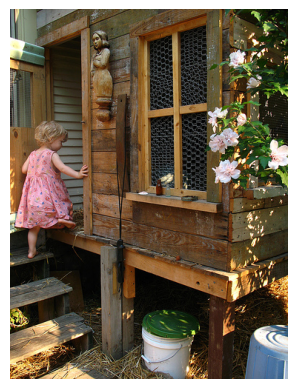

Image ID: 1001773457_577c3a7d70.jpg
Captions:
 - a black dog and a spotted dog are fighting
 - a black dog and a tricolored dog playing with each other on the road
 - a black dog and a white dog with brown spots are staring at each other in the street
 - two dogs of different breeds looking at each other on the road
 - two dogs on pavement moving toward each other


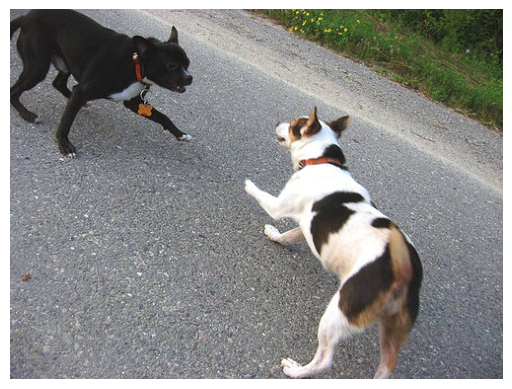

Image ID: 1002674143_1b742ab4b8.jpg
Captions:
 - a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl
 - a little girl is sitting in front of a large painted rainbow
 - a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it
 - there is a girl with pigtails sitting in front of a rainbow painting
 - young girl with pigtails painting outside in the grass


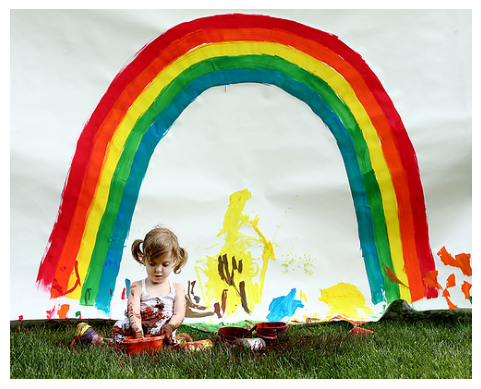

Image ID: 1003163366_44323f5815.jpg
Captions:
 - a man lays on a bench while his dog sits by him
 - a man lays on the bench to which a white dog is also tied
 - a man sleeping on a bench outside with a white and black dog sitting next to him
 - a shirtless man lies on a park bench with his dog
 - man laying on bench holding leash of dog sitting on ground


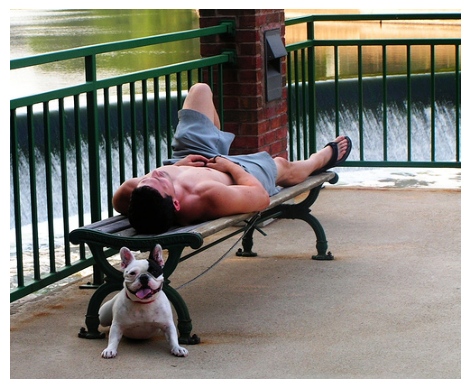

Image ID: 1007129816_e794419615.jpg
Captions:
 - a man in an orange hat starring at something
 - a man wears an orange hat and glasses
 - a man with gauges and glasses is wearing a blitz hat
 - a man with glasses is wearing a beer can crocheted hat
 - the man with pierced ears is wearing glasses and an orange hat


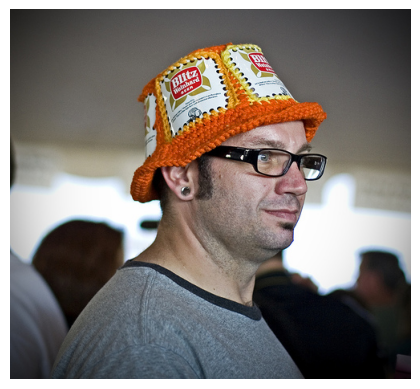

In [12]:
def display_images_and_captions(captions, images_dir, num_images=5):
    # Get a list of image IDs and their captions
    image_ids = list(captions.keys())[:num_images]  # Display only the first few images

    for image_id in image_ids:
        # Print the image ID and its captions
        print(f"Image ID: {image_id}")
        print("Captions:")
        for caption in captions[image_id]:
            print(f" - {caption}")
        
        # Load and display the image
        img_path = images_dir + image_id  # Adjust image path based on your directory structure
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')  # Hide axes for better display
        plt.show()  # Show the image

# Example usag
display_images_and_captions(captions, images_dir, num_images=5)  # 

In [17]:
def create_sequences(tokenizer, max_length, captions, features, vocab_size):
    X1, X2, y = [], [], []
    for key, cap_list in captions.items():
        for cap in cap_list:
            seq = tokenizer.texts_to_sequences([cap])[0]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                X1.append(features[key])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)


In [18]:
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add, Attention

# Define the captioning model with attention
def create_captioning_model_with_attention(vocab_size, max_length):
    # Image feature extractor (InceptionV3 output)
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # Sequence model (LSTM-based)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = LSTM(256, return_sequences=True)(se1)  # Return sequences for attention
    se3 = Dropout(0.5)(se2)
    
    # Attention mechanism
    attention = Attention()([fe2, se3])

    # Decoder (combine image features and LSTM output)
    decoder1 = Add()([fe2, attention])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Create the model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    
    return model

# Use this updated model
model = create_captioning_model_with_attention(vocab_size, max_length)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 36)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 36, 256)   │  2,260,224 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 36)        │          0 │ input_layer_4[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2048)      │          0 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 36, 256)   │    525,312 │ embedding_1[0][0… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    524,544 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 36, 256)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 256)       │          0 │ dense_3[0][0],    │
│ (Attention)         │                   │            │ dropout_3[0][0],  │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dense_3[0][0],    │
│                     │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │     65,792 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8829)      │  2,269,053 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,644,925 (21.53 MB)

 Trainable params: 5,644,925 (21.53 MB)

 Non-trainable params: 0 (0.00 B)

In [1]:
from sklearn.model_selection import train_test_split

# Convert captions to a list before splitting
captions_list = list(captions.items())

# Split the captions into train and validation sets
train_captions, val_captions = train_test_split(captions_list, test_size=0.2)

# Convert back to dictionaries
train_captions = dict(train_captions)
val_captions = dict(val_captions)

# Create sequences for model input
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_captions, encoding_train, vocab_size)
X1val, X2val, yval = create_sequences(tokenizer, max_length, val_captions, encoding_train, vocab_size)

# Train the model
batch_size = 64
epochs = 20
history = model.fit([X1train, X2train], ytrain, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    validation_data=([X1val, X2val], yval),
                    verbose=1)

# Save the trained model
model.save('image_captioning_model_with_attention.h5')

# Evaluate the model
loss = model.evaluate([X1val, X2val], yval)
print(f'Validation Loss: {loss}')

NameError: name 'captions' is not defined

In [48]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


Epoch 1/20
4968/4968 ━━━━━━━━━━━━━━━━━━━━ 612s 123ms/step - loss: 3.9343 - val_loss: 3.6984
Epoch 2/20
4968/4968 ━━━━━━━━━━━━━━━━━━━━ 613s 123ms/step - loss: 3.3414 - val_loss: 3.6191
Epoch 3/20
 540/4968 ━━━━━━━━━━━━━━━━━━━━ 8:48 119ms/step - loss: 3.0799

KeyboardInterrupt: 

2477/2477 ━━━━━━━━━━━━━━━━━━━━ 40s 16ms/step - loss: 3.6238
Validation Loss: 3.650003433227539


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


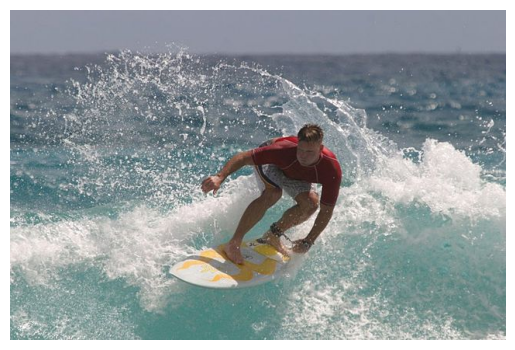

Generated Caption: startseq wave in the water with a wave in the background are in the background are in the background are in the background are in the background are in the background are in the background are in the background


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Generated Caption: startseq a dog is running through a field of grass and a dog in the background and a dog watches him on it and a red and white toy in its mouth and a dog is running on the
